In [1]:
import os
import json
import pickle
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import yfinance as yf
import pandas_datareader.data as web

In [2]:
DAILY_PKL = os.path.join("temp_output", "daily_X_y.pkl")
QUARTERLY_PKL = os.path.join("temp_output", "quarterly_X_y.pkl")
LOG_DIR_DAILY = "model_logs_d"
LOG_DIR_QUARTERLY = "model_logs_q"
MODEL_TYPES = ['RF', 'SVM', 'GB', 'XGB']

In [3]:
USE_LOGS = False
if os.path.exists("temp_ml_logs_Daily") and os.listdir("temp_ml_logs_Daily") and \
   os.path.exists("temp_ml_logs_Quarterly") and os.listdir("temp_ml_logs_Quarterly"):
    USE_LOGS = True
    print("[INFO] Pre-existing log files found in both temp_ml_logs_Daily and temp_ml_logs_Quarterly. Skipping re-fitting and using existing logs.")
else:
    print("[INFO] One or both log directories are empty. Proceeding with model fitting.")

[INFO] Pre-existing log files found in both temp_ml_logs_Daily and temp_ml_logs_Quarterly. Skipping re-fitting and using existing logs.


In [4]:
def load_logs(log_dir):
    """Load all CSV log files from a log directory and return one combined DataFrame."""
    files = [os.path.join(log_dir, f) for f in os.listdir(log_dir) if f.endswith(".csv")]
    if not files:
        print(f"[ERROR] No log files found in {log_dir}")
        return pd.DataFrame()
    dfs = [pd.read_csv(f) for f in files]
    return pd.concat(dfs, ignore_index=True)

def get_best_config(logs_df):
    """
    Group by model_name and hyperparameters, average MSE, MAPE, R^2,
    and then select for each model type the configuration with lowest average MAPE.
    Returns a DataFrame with one best row per model type.
    """
    grouped = logs_df.groupby(["model_name", "model_hyperparameters_dict"])[
        ["MSE_score", "MAPE_score", "R^2_score"]
    ].mean().reset_index()
    best_rows = grouped.loc[grouped.groupby("model_name")["MAPE_score"].idxmin()].reset_index(drop=True)
    return best_rows

def get_test_dates_for_log(row, full_df):
    """
    Given one log row and the full DataFrame, reconstruct the dates corresponding
    to the test portion of that sliding window.
    
    If the log's start_date contains 'Q' (quarterly), it is parsed as a Period and converted 
    to its quarter-end Timestamp. Otherwise, the start_date is parsed as a datetime.
    If an exact match isn't found in full_df.index, the nearest index is used.
    """
    start_date_str = row['start_date']
    if "Q" in start_date_str:
        start_period = pd.Period(start_date_str, freq='Q')
        start_date_parsed = start_period.to_timestamp(how='E').normalize()
    else:
        start_date_parsed = pd.to_datetime(start_date_str).normalize()
    try:
        start_idx = full_df.index.get_loc(start_date_parsed)
    except KeyError:
        #print(f"[ERROR] start_date {start_date_parsed} not found in DataFrame index; attempting nearest match.")
        # Use the nearest matching index
        idx_array = full_df.index.get_indexer([start_date_parsed], method='nearest')
        if idx_array[0] == -1:
            print(f"[ERROR] No nearest match found for {start_date_parsed}.")
            return []
        start_idx = idx_array[0]
    window_size = int(row['window_size'])
    test_ratio = float(row['test_ratio'])
    train_size = int(window_size * (1 - test_ratio))
    return full_df.index[start_idx + train_size : start_idx + window_size]

def aggregate_predictions(log_df, full_df):
    """
    Aggregate predictions from sliding-window log DataFrame.
    Returns two dictionaries:
      - first_preds: {test_date: first prediction}
      - all_preds: {test_date: list of predictions}
    """
    first_preds = {}
    all_preds = {}
    for _, row in log_df.iterrows():
        pred_vals = row['test_data_model_predictions_list']
        if isinstance(pred_vals, str):
            pred_vals = json.loads(pred_vals)
        test_dates = get_test_dates_for_log(row, full_df)
        if len(test_dates) != len(pred_vals):
            continue
        first_preds[test_dates[0]] = pred_vals[0]
        for i, d in enumerate(test_dates):
            all_preds.setdefault(d, []).append(pred_vals[i])
    return first_preds, all_preds

def series_from_dict(pred_dict):
    """
    Convert a dictionary of date: prediction into a sorted pandas Series.
    If keys are Periods, convert them to Timestamps using period end.
    """
    dates = list(pred_dict.keys())
    converted_dates = [d.to_timestamp(how='E') if isinstance(d, pd.Period) else pd.to_datetime(d) for d in dates]
    return pd.Series(list(pred_dict.values()), index=pd.DatetimeIndex(converted_dates)).sort_index()

def convert_quarter_index(df):
    """
    Convert a DataFrame's PeriodIndex (or quarter string index) to Timestamps (quarter-end).
    """
    if isinstance(df.index, pd.PeriodIndex):
        return df.index.to_timestamp(how='E')
    else:
        try:
            period_idx = pd.PeriodIndex(df.index, freq='Q')
            return period_idx.to_timestamp(how='E')
        except:
            return pd.to_datetime(df.index)

def compute_performance_metrics(y_true, y_pred):
    """Compute and return MSE, MAPE, and R²."""
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mape, r2

def build_model(model_name, params):
    """Return a regression model given model type and hyperparameters."""
    if model_name == "RF":
        return RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    elif model_name == "SVM":
        return SVR(**params)
    elif model_name == "GB":
        return GradientBoostingRegressor(**params, random_state=42)
    elif model_name == "XGB":
        return xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
    else:
        raise ValueError(f"Unknown model type: {model_name}")

In [5]:
def sliding_window_forecast_with_scaling(df, target_col, model, model_name, model_params,
                                         window_size=25, test_ratio=0.2, drop_cols=None,
                                         log_dir="model_logs_d", ticker="", domain_label="Daily"):
    """
    Performs sliding-window forecasting with standard scaling on features and target.
    Predictions are inverse-transformed to original units before evaluation.
    Logs predictions and performance metrics to a uniquely named CSV.
    """
    if drop_cols is None:
        drop_cols = []
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    log_filename = f"{model_name}_{domain_label}_{ticker}_full.csv"
    log_path = os.path.join(log_dir, log_filename)
    log_entries = []
    df = df.dropna().sort_index()
    n = len(df)

    for start in range(0, n - window_size + 1):
        window_df = df.iloc[start:start + window_size].copy()
        X_window = window_df.drop(columns=[target_col] + drop_cols, errors='ignore')
        y_window = window_df[target_col].values

        train_size = int(len(X_window) * (1 - test_ratio))
        if train_size < 1 or train_size >= len(X_window):
            continue

        X_train = X_window.iloc[:train_size].values
        X_test = X_window.iloc[train_size:].values
        y_train = y_window[:train_size]
        y_test = y_window[train_size:]

        # Scale X
        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        # Scale y
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

        # Fit model on scaled X and y
        if model_name == "XGB":
            model.fit(X_train_scaled, y_train_scaled,
                      eval_set=[(X_test_scaled, y_test_scaled)], verbose=False
            )

        else:
            model.fit(X_train_scaled, y_train_scaled)

        # Predict
        y_pred_scaled = model.predict(X_test_scaled)

        # Inverse-transform prediction and test y
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_test_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

        # Evaluation
        mse = mean_squared_error(y_test_real, y_pred)
        mape = mean_absolute_percentage_error(y_test_real, y_pred)
        r2 = r2_score(y_test_real, y_pred)

        log_entry = {
            "model_name": model_name,
            "model_hyperparameters_dict": json.dumps(model_params),
            "window_size": window_size,
            "test_ratio": test_ratio,
            "start_date": str(df.index[start]),
            "end_date": str(df.index[start + window_size - 1]),
            "test_data_values_list": y_test_real.tolist(),
            "test_data_model_predictions_list": y_pred.tolist(),
            "MSE_score": mse,
            "MAPE_score": mape,
            "R^2_score": r2
        }
        log_entries.append(log_entry)

    log_df = pd.DataFrame(log_entries)
    if os.path.exists(log_path):
        existing = pd.read_csv(log_path)
        log_df = pd.concat([existing, log_df], ignore_index=True)
    log_df.to_csv(log_path, index=False)
    return log_df

In [6]:
def retrain_and_aggregate(model_type, full_df, target_col, best_config_row, domain_label, window_size, ticker, test_ratio=0.2):
    """
    Retrain the best model using sliding-window forecasting, then aggregate the first predictions.
    For quarterly data, converts the index to datetime.
    Returns a prediction Series and the log DataFrame.
    """
    params = json.loads(best_config_row['model_hyperparameters_dict'])
    model = build_model(model_type, params)
    
    # For quarterly data, convert index to datetime in a local copy.
    df_for_agg = full_df.copy()
    if domain_label.lower() == "quarterly":
        full_df.index = pd.DatetimeIndex(convert_quarter_index(full_df))
        #df_for_agg.index = pd.DatetimeIndex(convert_quarter_index(df_for_agg))
    
    log_df = sliding_window_forecast_with_scaling(
        df=full_df,
        target_col=target_col,
        model=model,
        model_name=model_type,
        model_params=params,
        window_size=window_size,
        test_ratio=test_ratio,
        drop_cols=[],
        log_dir=f"temp_ml_logs_{domain_label}",
        ticker=ticker,
        domain_label=domain_label
    )
    first_preds, _ = aggregate_predictions(log_df, df_for_agg)
    pred_series = series_from_dict(first_preds)
    return pred_series, log_df

In [7]:
def load_pickle_data(pkl_path):
    """Load and return data from a pickle file."""
    if not os.path.exists(pkl_path):
        print(f"[ERROR] Pickle file not found: {pkl_path}")
        return {}
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)
    print(f"[SUCCESS] Loaded data from {pkl_path}")
    return data

In [8]:
def final_line_plot(observations, daily_preds, quarterly_preds, model_label):
    """
    Plot final predictions for a given model type:
      - Observations as a steelblue line.
      - Best daily model predictions as a continuous line.
      - Best quarterly model predictions as a connected line with markers.
    For quarterly predictions, we assume the index has been converted to quarter–end dates.
    The markers and lines are drawn with lower alpha and smaller marker size for transparency.
    """
    plt.figure(figsize=(14, 7))
    # Plot true observations (steelblue line with moderate transparency)
    sns.lineplot(x=observations.index, y=observations.values, color='steelblue', label='Observations', 
                 alpha=0.7, lw=2)
    # Plot daily predictions as a continuous line (coral with moderate transparency)
    sns.lineplot(x=daily_preds.index, y=daily_preds.values, color='red', label='Best Daily Prediction', 
                 alpha=0.7, lw=0.5)
    # Plot quarterly predictions as a connected line with markers (forestgreen, lower alpha, smaller markers)
    sns.lineplot(x=quarterly_preds.index, y=quarterly_preds.values, color='forestgreen', label='Best Quarterly Prediction', 
                 alpha=0.5, marker='o', markersize=6)
    plt.title(f"Final Forecast Comparison for {model_label}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_from_temp_logs(ticker, domain_label, model_type, full_df):
    """
    Reads the log file from the appropriate temp_logs directory for the given ticker and model type,
    aggregates first predictions, and plots forecast comparisons.
    """
    log_filename = f"{model_type}_{domain_label}_{ticker}_full.csv"
    log_dir = f"temp_ml_logs_{domain_label}"
    log_path = os.path.join(log_dir, log_filename)
    if not os.path.exists(log_path):
        print(f"[ERROR] Log file not found for {ticker} {domain_label} {model_type}")
        return
    log_df = pd.read_csv(log_path)
    first_preds, _ = aggregate_predictions(log_df, full_df)
    pred_series = series_from_dict(first_preds)
    if domain_label.lower() == "quarterly":
        obs = full_df["y"]
        obs.index = pd.DatetimeIndex(convert_quarter_index(obs.to_frame()))
    else:
        obs = full_df["y"]
    final_line_plot(observations=obs, daily_preds=pred_series, quarterly_preds=pred_series,
                    model_label=model_type)

In [10]:
def get_preds_from_log(ticker, domain_label, model_type, full_df):
    log_filename = f"{model_type}_{domain_label}_{ticker}_full.csv"
    log_dir = f"temp_ml_logs_{domain_label}"
    log_path = os.path.join(log_dir, log_filename)
    if not os.path.exists(log_path):
        print(f"[ERROR] Log file not found for {ticker} {domain_label} {model_type}")
        return None
    log_df = pd.read_csv(log_path)
    first_preds, _ = aggregate_predictions(log_df, full_df)
    pred_series = series_from_dict(first_preds)
    # Normalize the index to just the date (rounding to midnight)
    pred_series.index = pd.to_datetime(pred_series.index).normalize()
    return pred_series

In [11]:
daily_data_dict = load_pickle_data(DAILY_PKL)
quarterly_data_dict = load_pickle_data(QUARTERLY_PKL)

[SUCCESS] Loaded data from temp_output/daily_X_y.pkl
[SUCCESS] Loaded data from temp_output/quarterly_X_y.pkl


In [12]:
quarterly_data_dict = {
    ticker: df.assign(index=pd.PeriodIndex(df.index.tolist(), freq='Q').to_timestamp(how='end').normalize())
            .set_index('index')
            .rename_axis(None)
    for ticker, df in quarterly_data_dict.items()
}

In [13]:
# Load processed daily and quarterly logs
logs_daily = load_logs(LOG_DIR_DAILY)
logs_quarterly = load_logs(LOG_DIR_QUARTERLY)

if logs_daily.empty or logs_quarterly.empty:
    print("[ERROR] One or both log directories are empty. Exiting.")

# Compute best configuration (lowest average MAPE) for each model type
best_daily = get_best_config(logs_daily)
best_quarterly = get_best_config(logs_quarterly)

print("[SUCCESS] Best Daily Model Configurations:")
for model, config in zip(best_daily["model_name"], best_daily["model_hyperparameters_dict"]):
    print(f"{model}: {json.loads(config)}")

print("\n[SUCCESS] Best Quarterly Model Configurations:")
for model, config in zip(best_quarterly["model_name"], best_quarterly["model_hyperparameters_dict"]):
    print(f"{model}: {json.loads(config)}")

[SUCCESS] Best Daily Model Configurations:
GB: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 800, 'subsample': 0.9}
LR: {'alpha': 100, 'solver': 'sag', 'tol': 0.01}
RF: {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 4000}
SVM: {'C': 0.5, 'epsilon': 2.9999999999999994e-05, 'kernel': 'sigmoid'}

[SUCCESS] Best Quarterly Model Configurations:
GB: {'learning_rate': 0.0125, 'max_depth': 2, 'n_estimators': 9000, 'subsample': 0.95}
LR: {'alpha': 10, 'solver': 'saga', 'tol': 0.01}
RF: {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 800}
SVM: {'C': 1.2000000000000006, 'epsilon': 2.5e-06, 'kernel': 'sigmoid'}
XGB: {'colsample_bytree': 1.0, 'early_stopping_rounds': 50, 'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 4800, 'subsample': 0.825}


In [14]:
quarterly_results = {}
for ticker, df_q in tqdm(quarterly_data_dict.items(), desc="Processing Quarterly Companies"):
    company_quarterly_metrics = {"Ticker": ticker}
    for m in MODEL_TYPES:
        if USE_LOGS:
            quarterly_preds = get_preds_from_log(ticker, "Quarterly", m, df_q)
        else:
            best_quarterly_m = best_quarterly[best_quarterly['model_name'] == m].iloc[0]
            quarterly_preds, log_quarterly = retrain_and_aggregate(
                model_type=m,
                full_df=df_q,
                target_col="y",
                best_config_row=best_quarterly_m,
                domain_label="Quarterly",
                window_size=10,
                ticker=ticker
            )
        # Convert indices to datetime
        obs_quarterly = df_q["y"]
        obs_quarterly.index = pd.DatetimeIndex(convert_quarter_index(obs_quarterly.to_frame()))
        quarterly_preds.index = pd.DatetimeIndex(convert_quarter_index(quarterly_preds.to_frame()))
        common_quarterly = obs_quarterly[obs_quarterly.index.isin(quarterly_preds.index)]
        quarterly_preds = quarterly_preds[quarterly_preds.index.isin(common_quarterly.index)]
        mse_q, mape_q, r2_q = compute_performance_metrics(common_quarterly, quarterly_preds)
        company_quarterly_metrics[f"{m}_MSE"] = mse_q
        company_quarterly_metrics[f"{m}_MAPE"] = mape_q
        company_quarterly_metrics[f"{m}_R2"] = r2_q
    quarterly_results[ticker] = company_quarterly_metrics

Processing Quarterly Companies: 100%|██████████| 22/22 [00:00<00:00, 33.70it/s]


In [15]:
daily_results = {}
for ticker, df_d in tqdm(daily_data_dict.items(), desc="Processing Daily Companies"):
    company_daily_metrics = {"Ticker": ticker}
    for m in MODEL_TYPES:
        if USE_LOGS:
            daily_preds = get_preds_from_log(ticker, "Daily", m, df_d)
        else:
            best_daily_m = best_daily[best_daily['model_name'] == m].iloc[0]
            daily_preds, log_daily = retrain_and_aggregate(
                model_type=m,
                full_df=df_d,
                target_col="y",
                best_config_row=best_daily_m,
                domain_label="Daily",
                window_size=25,
                ticker=ticker
            )
        obs_daily = df_d["y"]
        common_daily = obs_daily[obs_daily.index.isin(daily_preds.index)]
        daily_preds = daily_preds[daily_preds.index.isin(common_daily.index)]
        mse_d, mape_d, r2_d = compute_performance_metrics(common_daily, daily_preds)
        company_daily_metrics[f"{m}_MSE"] = mse_d
        company_daily_metrics[f"{m}_MAPE"] = mape_d
        company_daily_metrics[f"{m}_R2"] = r2_d
    daily_results[ticker] = company_daily_metrics

Processing Daily Companies:  65%|██████▌   | 15/23 [00:25<00:13,  1.72s/it]

[ERROR] Log file not found for CVX Daily XGB


AttributeError: 'NoneType' object has no attribute 'index'

[INFO] Plotting RF forecasts for AAPL...


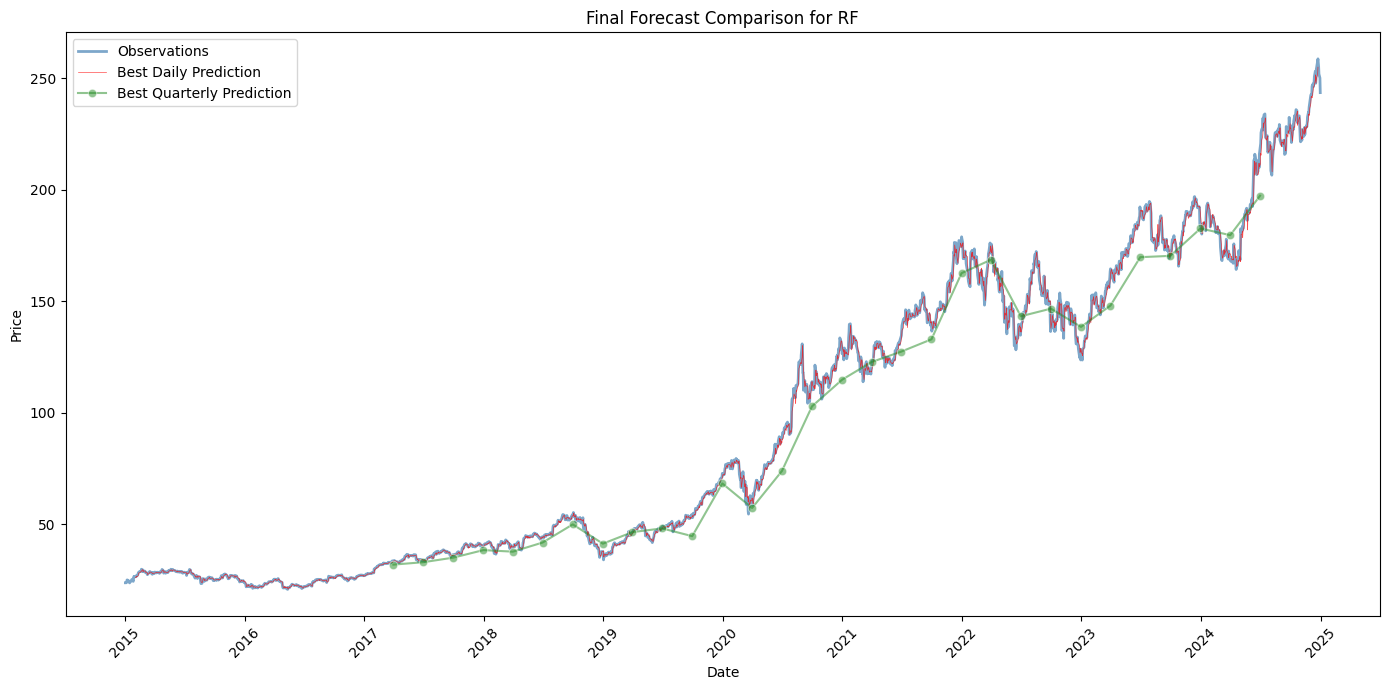

[INFO] Plotting SVM forecasts for AAPL...


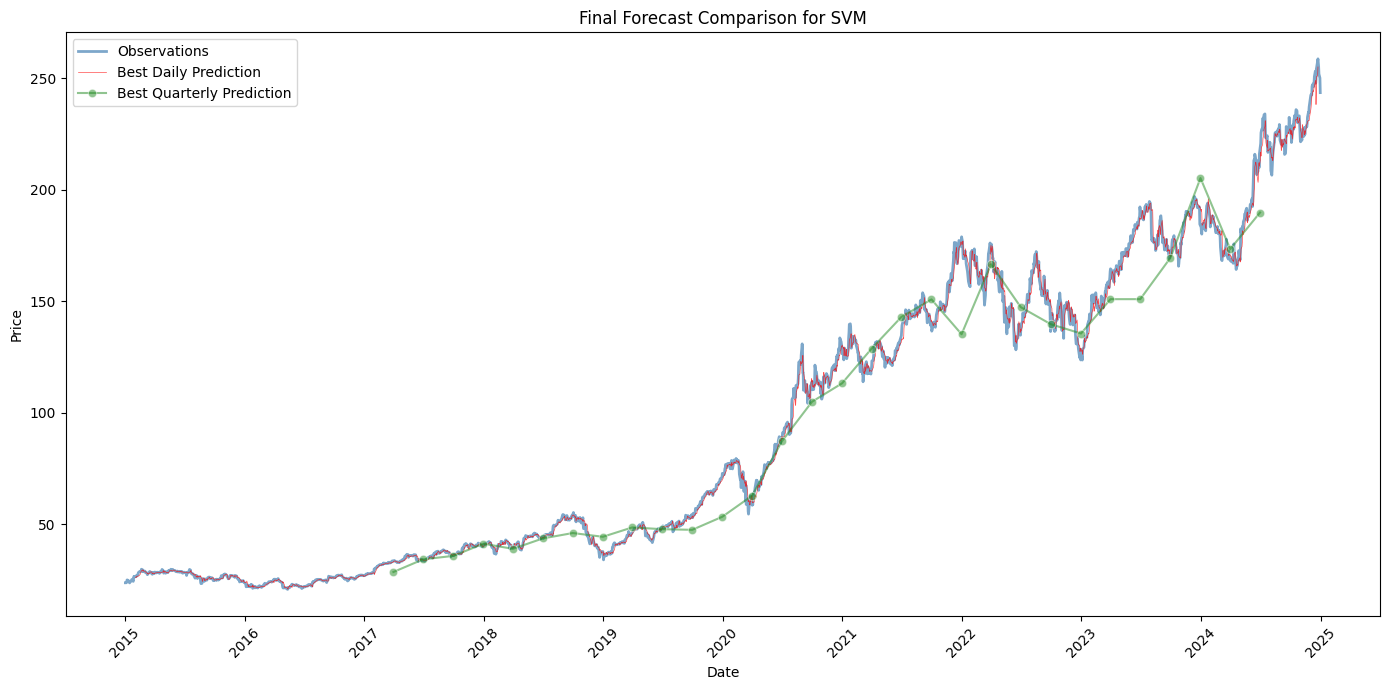

[INFO] Plotting GB forecasts for AAPL...


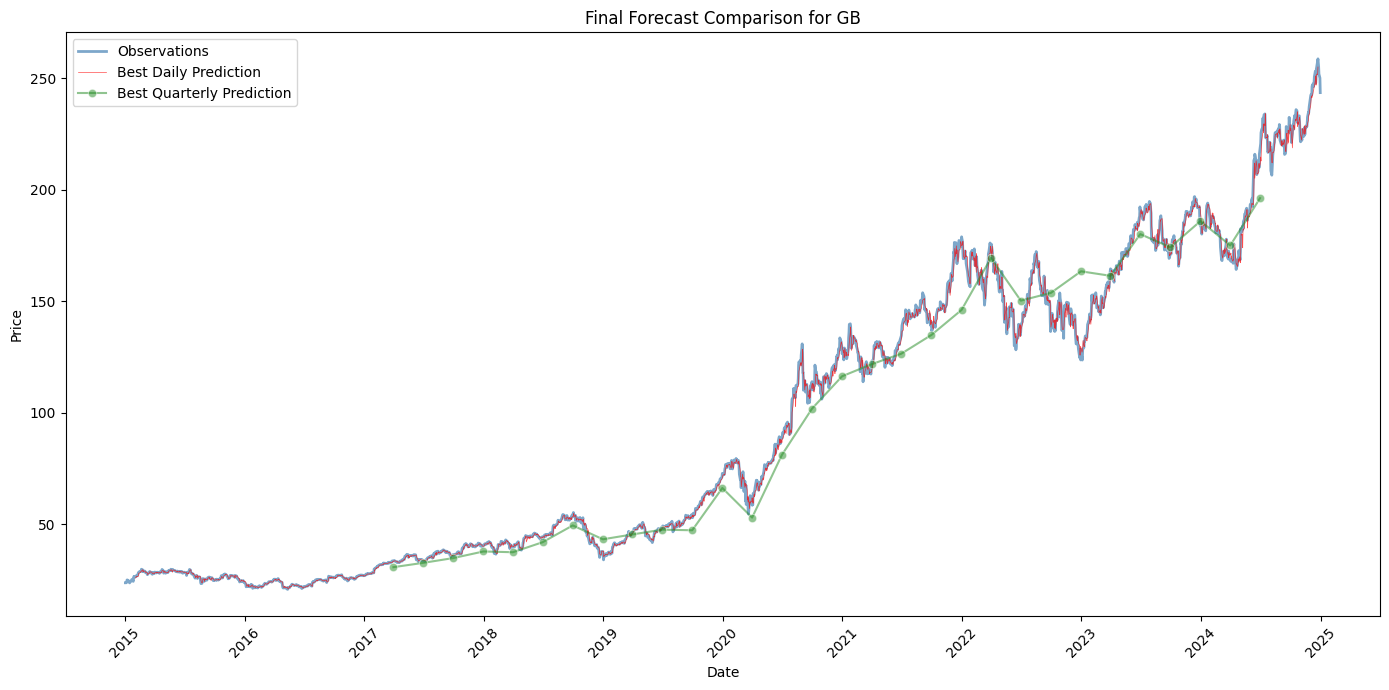

[INFO] Plotting XGB forecasts for AAPL...


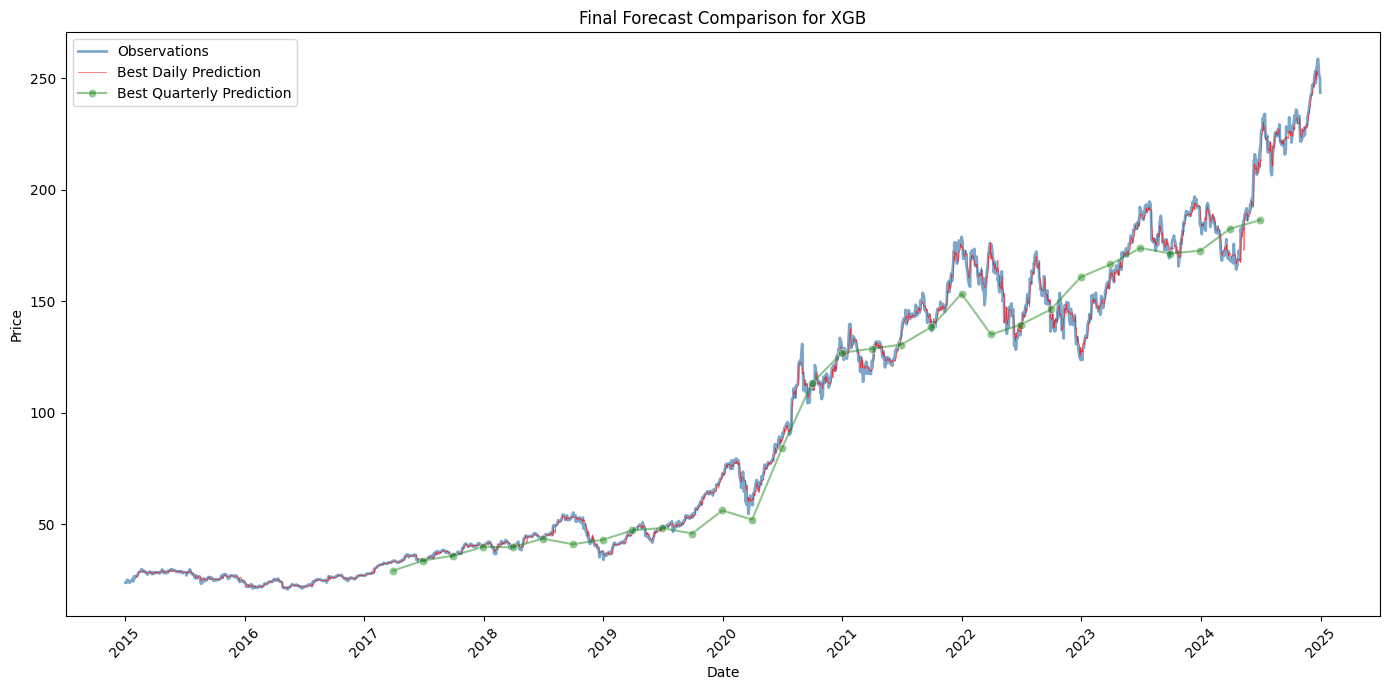

[INFO] Plotting RF forecasts for MSFT...


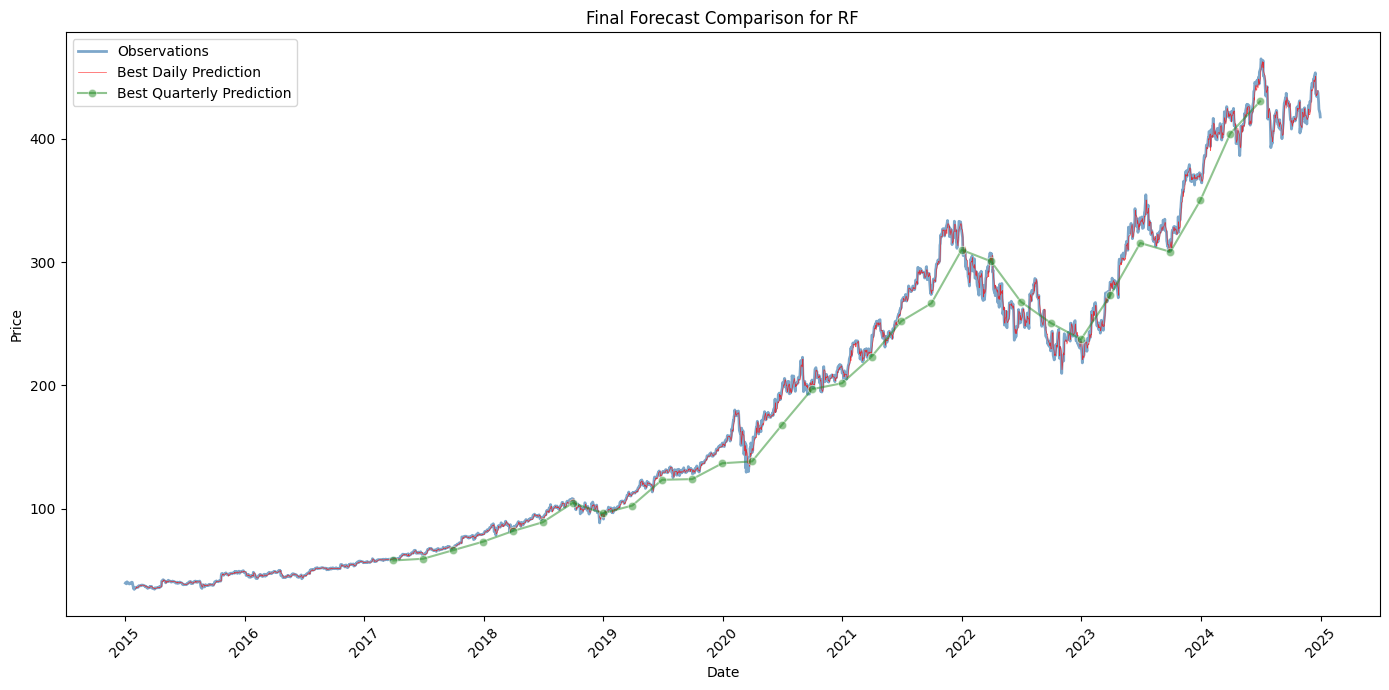

[INFO] Plotting SVM forecasts for MSFT...


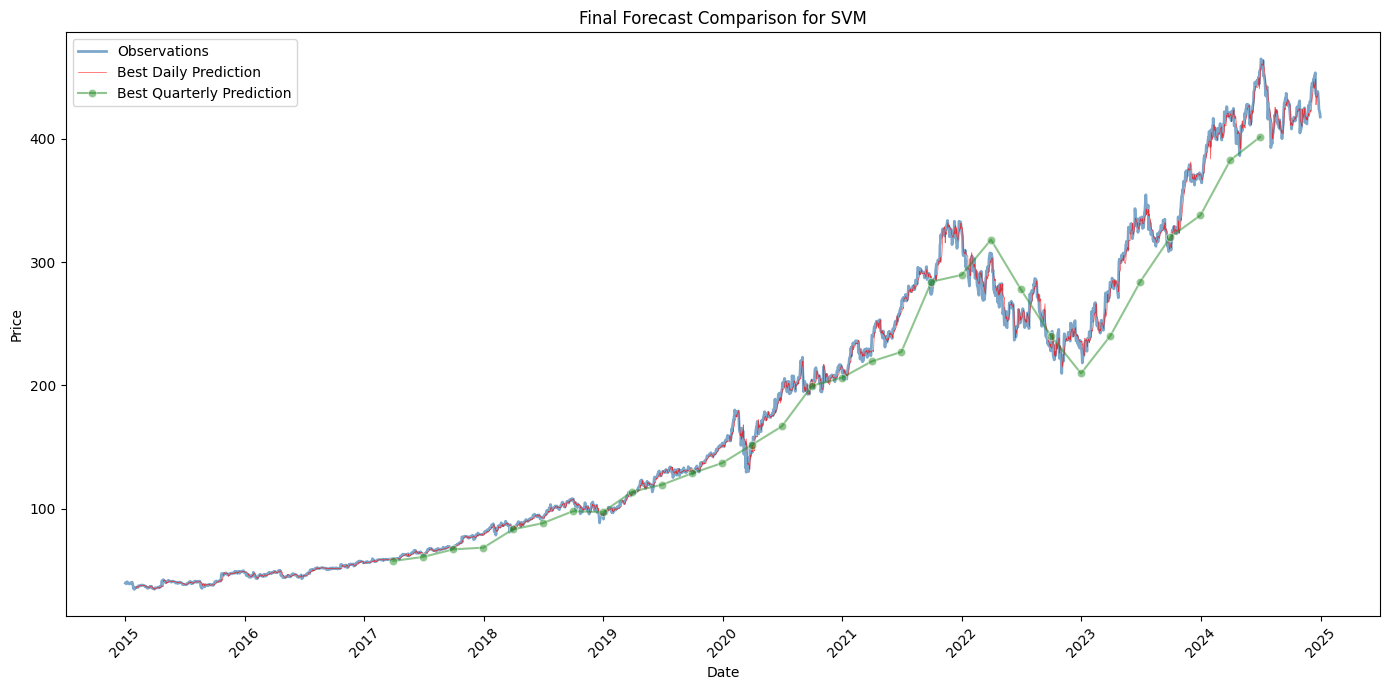

[INFO] Plotting GB forecasts for MSFT...


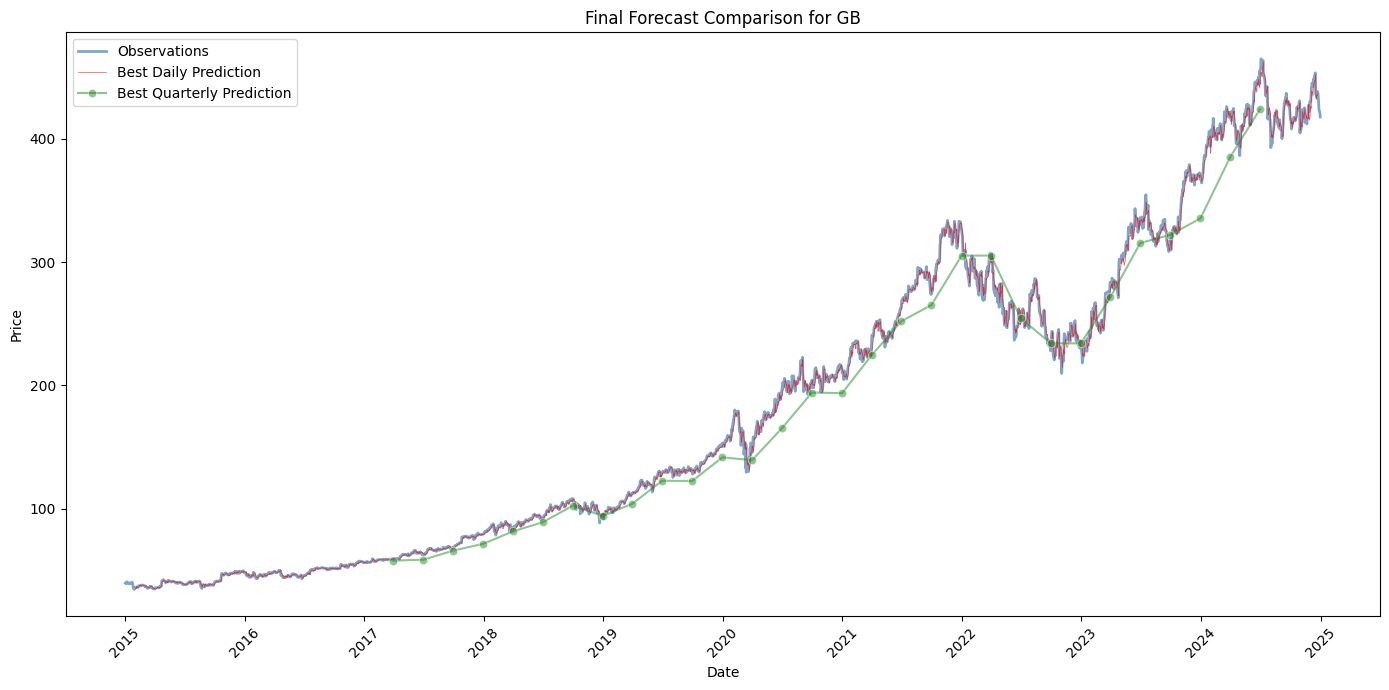

[INFO] Plotting XGB forecasts for MSFT...


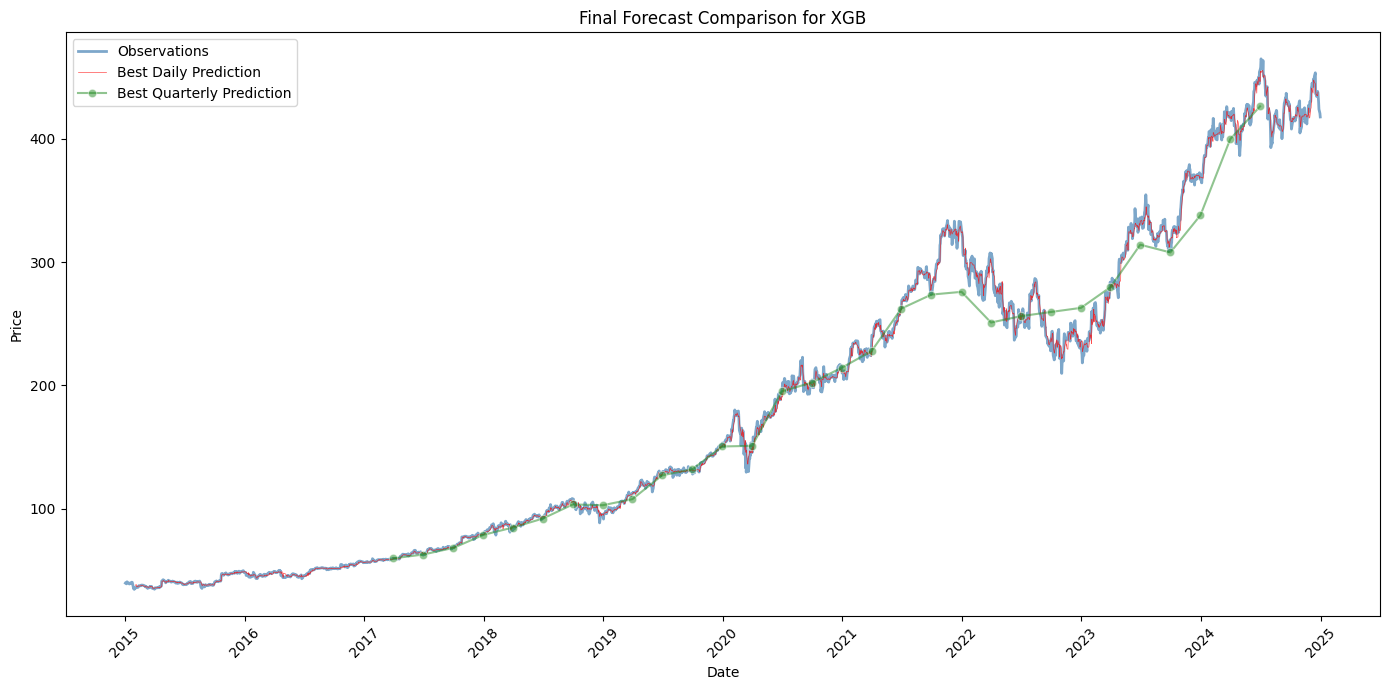

[INFO] Plotting RF forecasts for LLY...


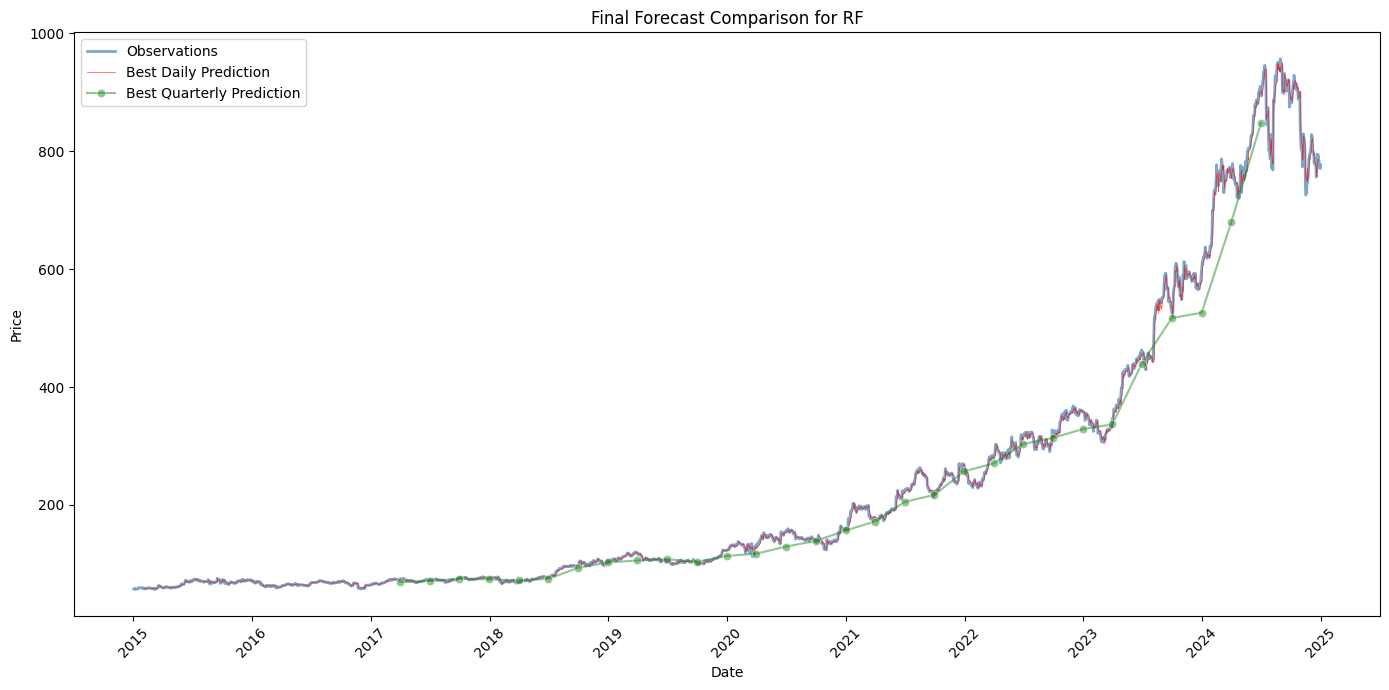

[INFO] Plotting SVM forecasts for LLY...


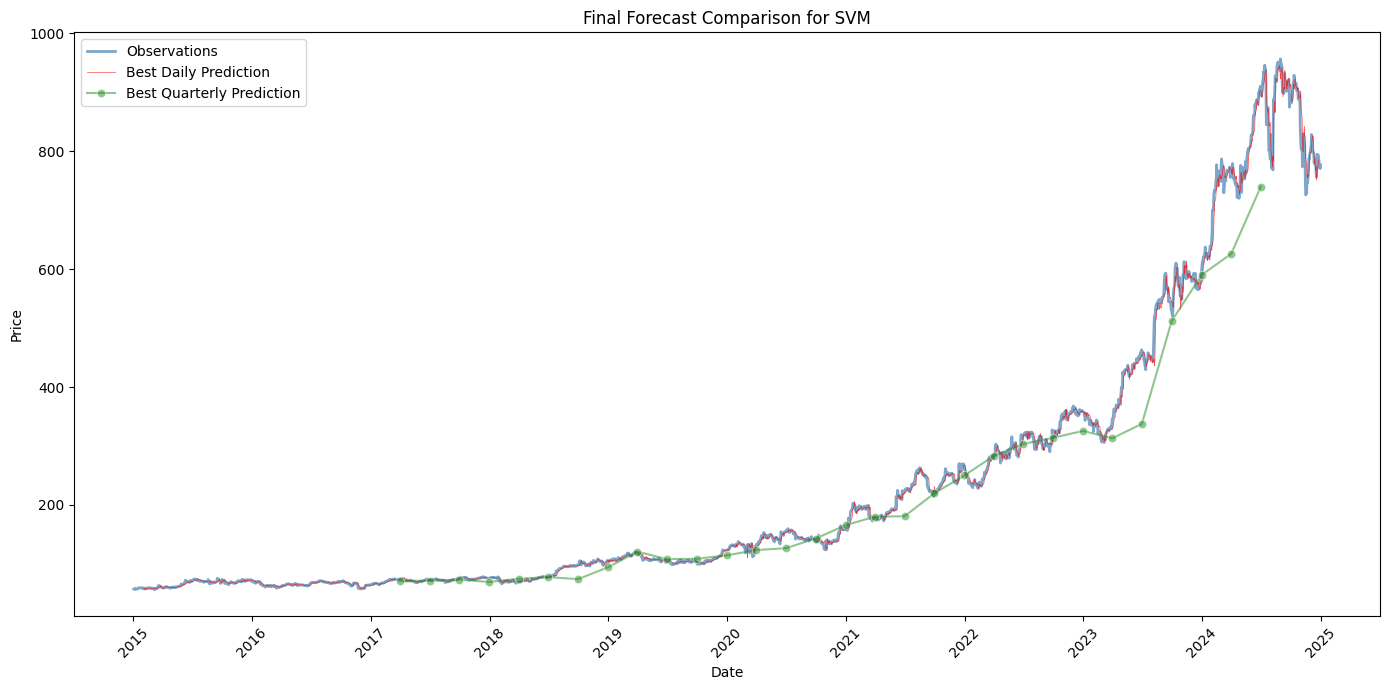

[INFO] Plotting GB forecasts for LLY...


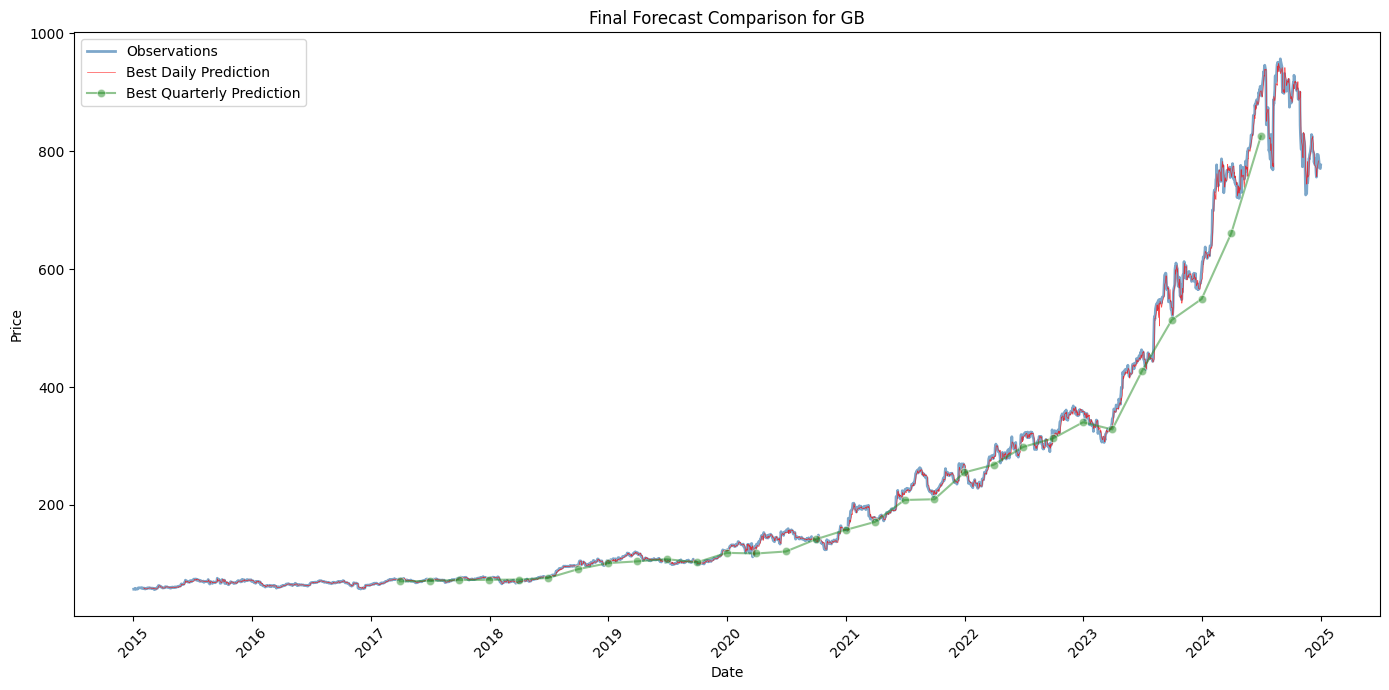

[INFO] Plotting XGB forecasts for LLY...


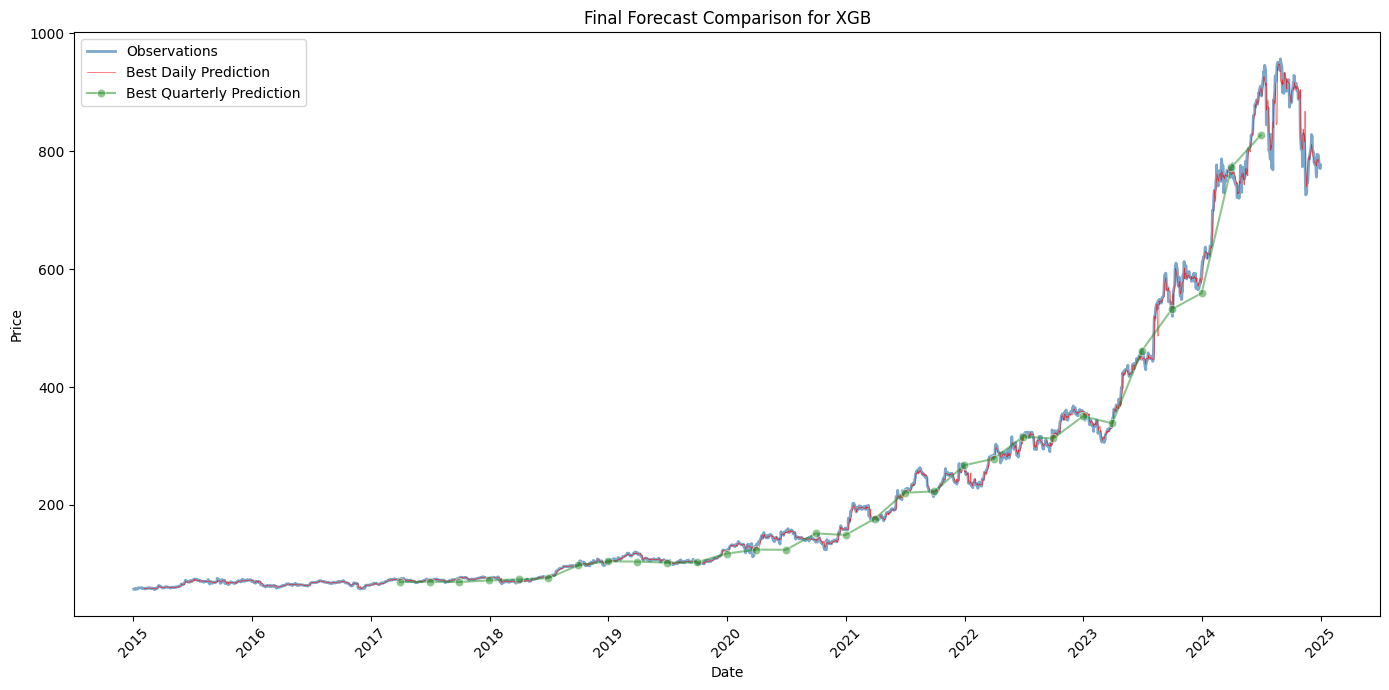

[INFO] Plotting RF forecasts for UNH...


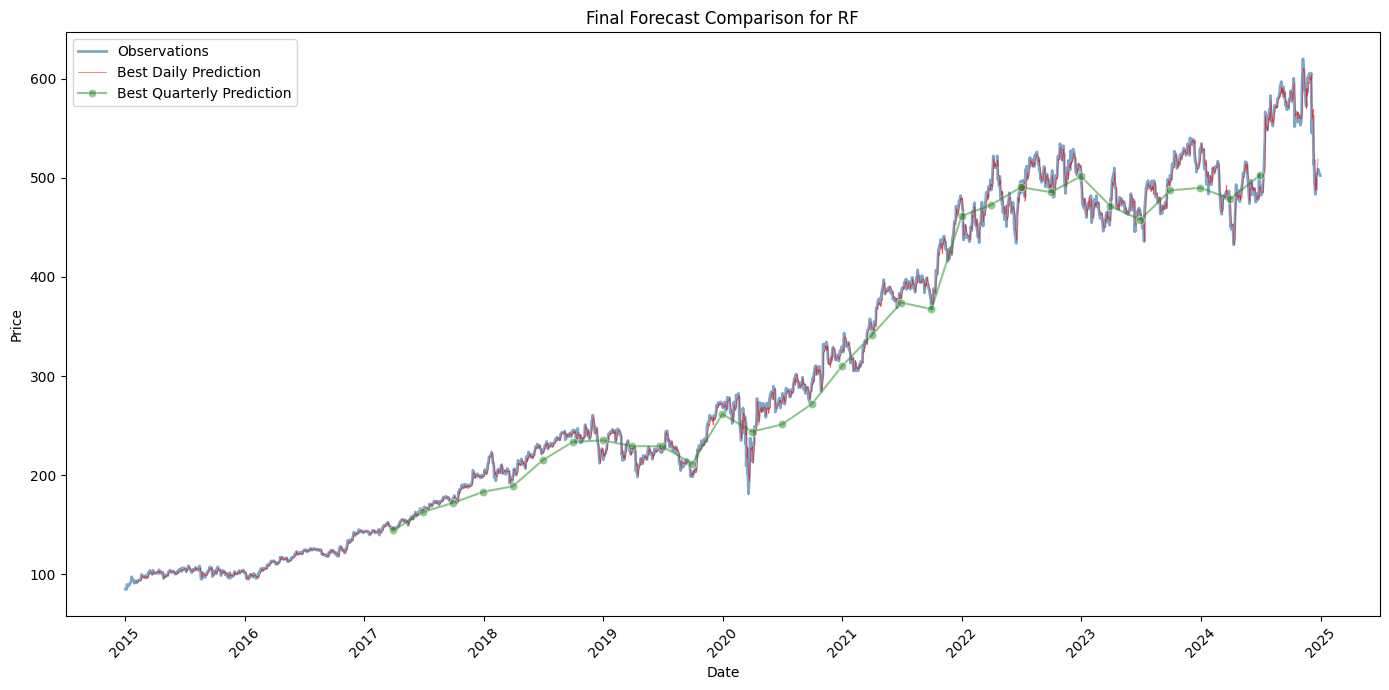

[INFO] Plotting SVM forecasts for UNH...


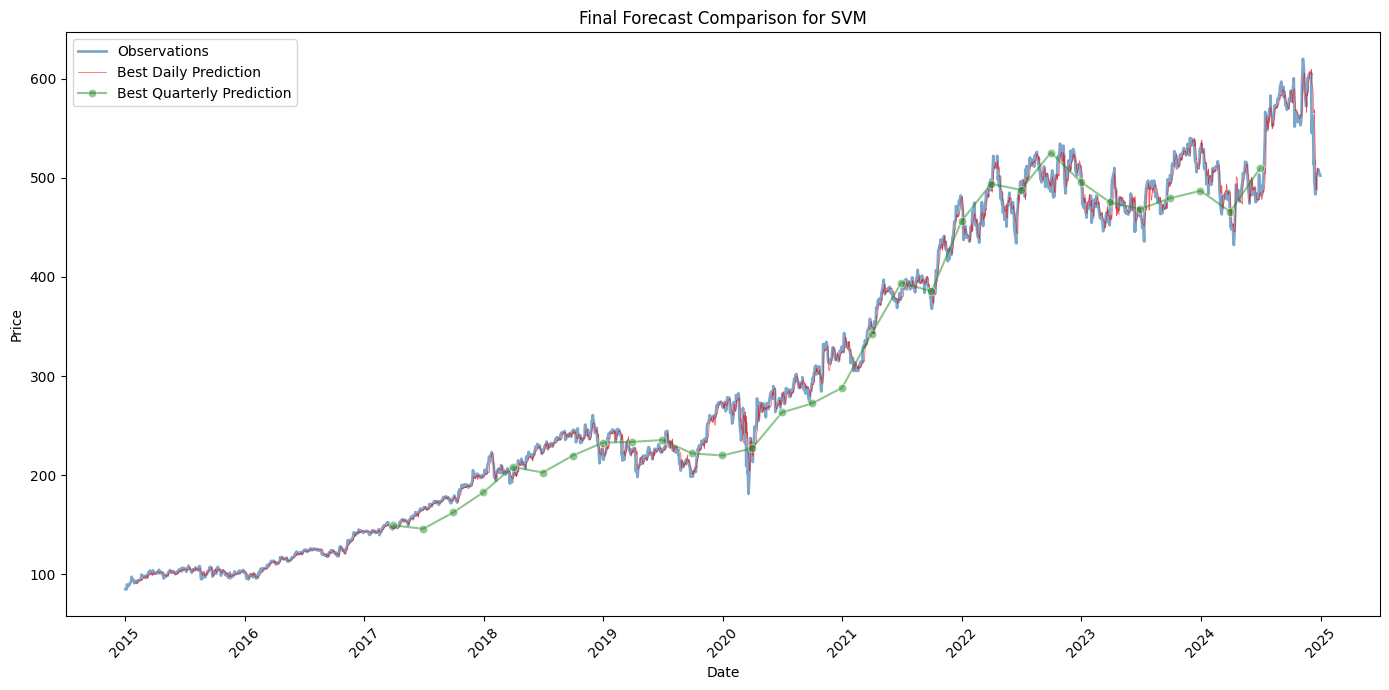

[INFO] Plotting GB forecasts for UNH...


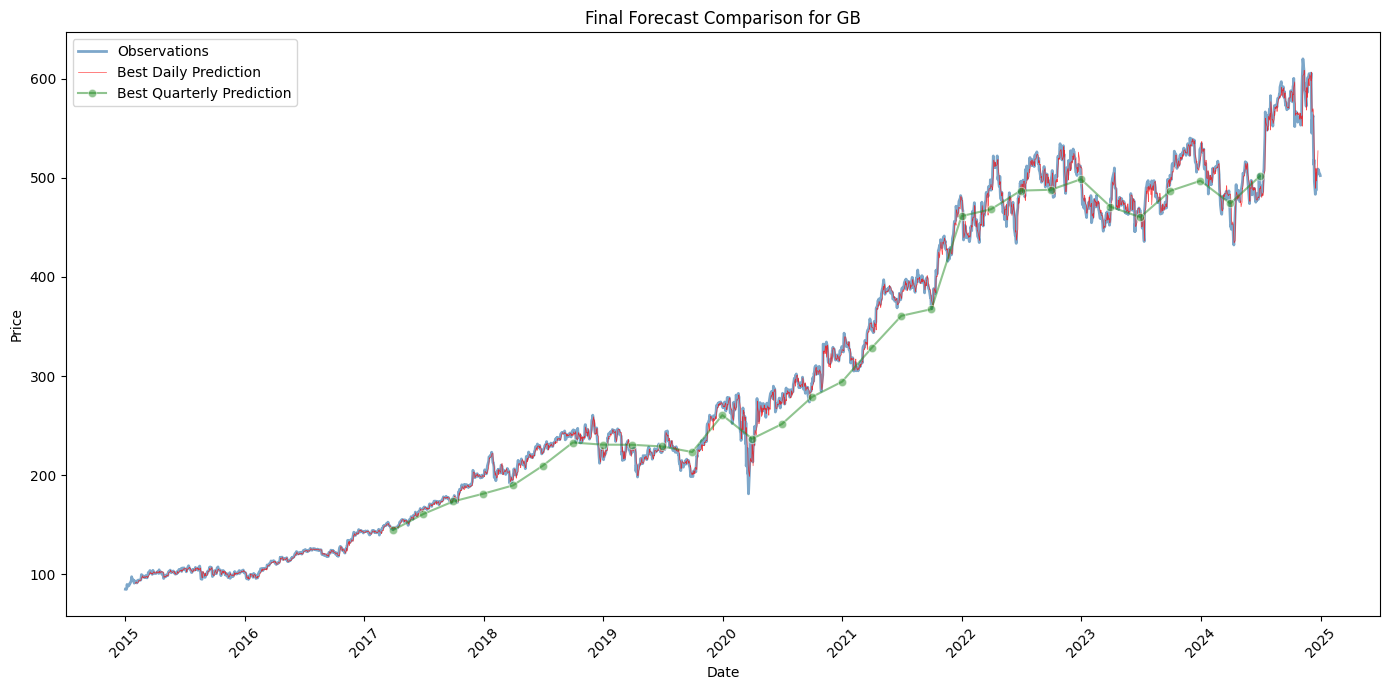

[INFO] Plotting XGB forecasts for UNH...


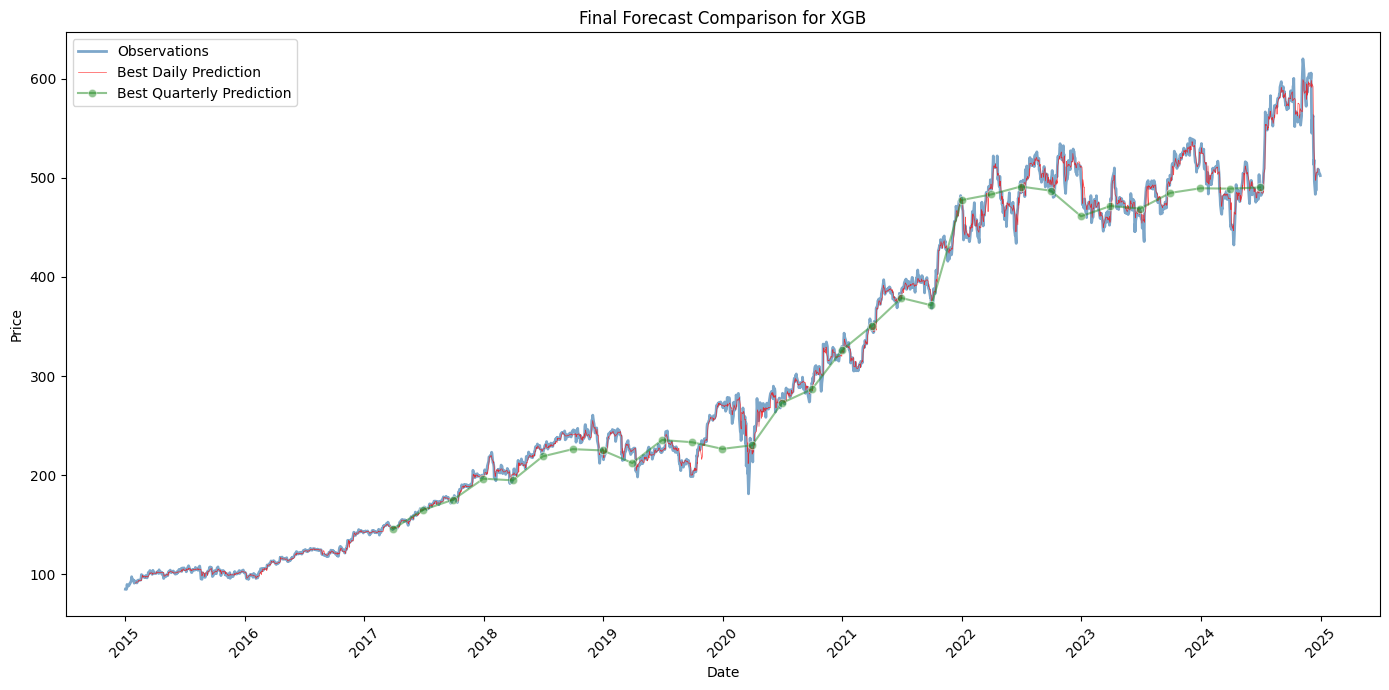

[INFO] Plotting RF forecasts for V...


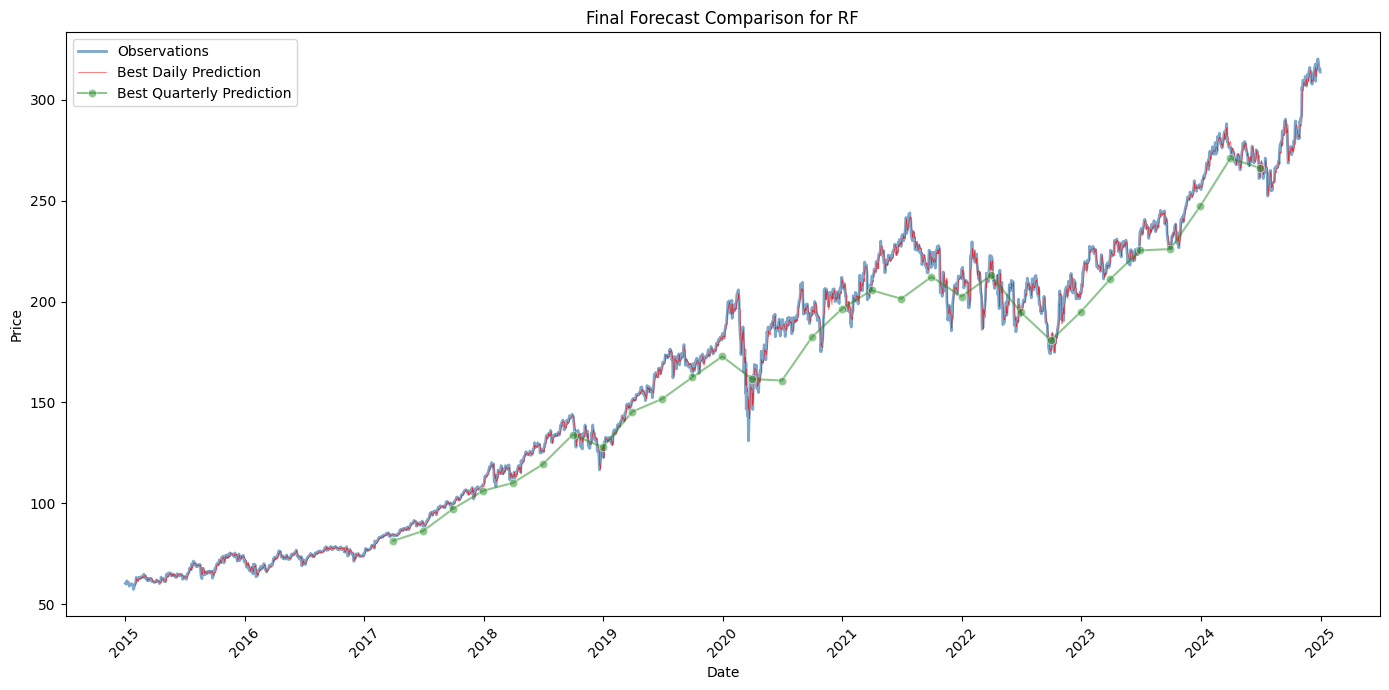

[INFO] Plotting SVM forecasts for V...


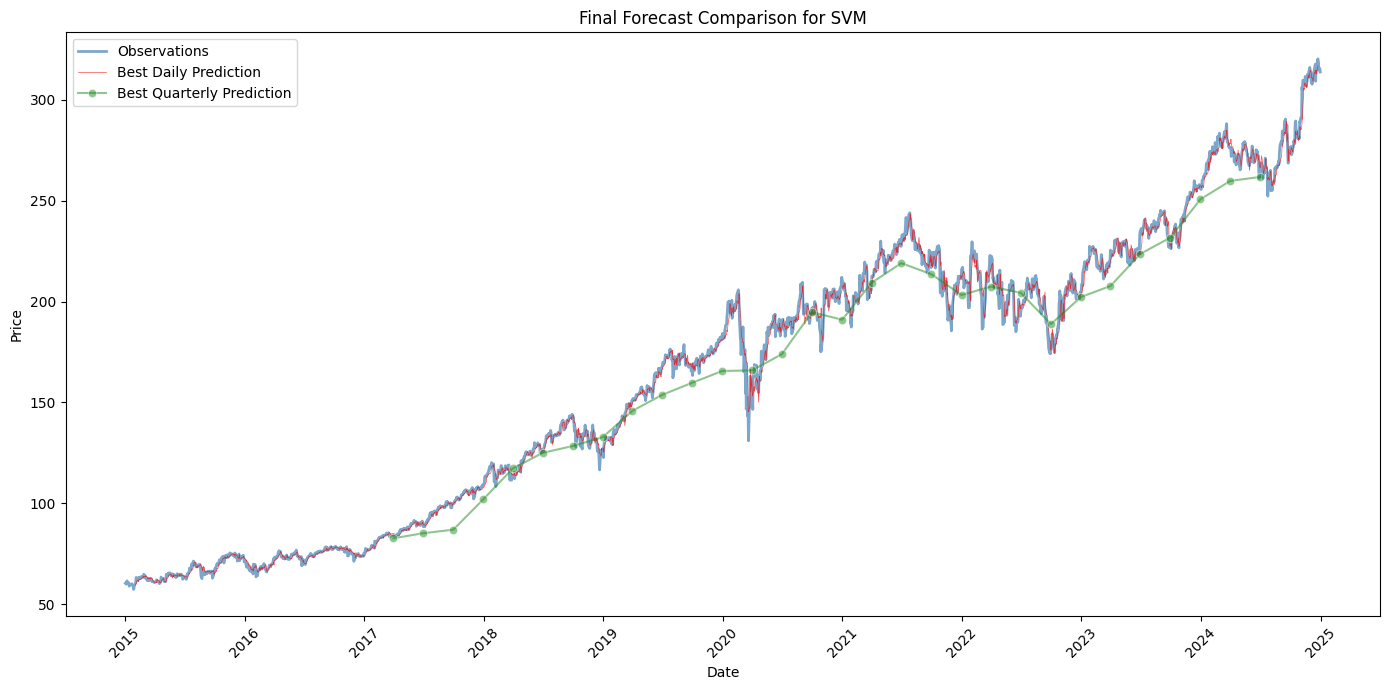

[INFO] Plotting GB forecasts for V...


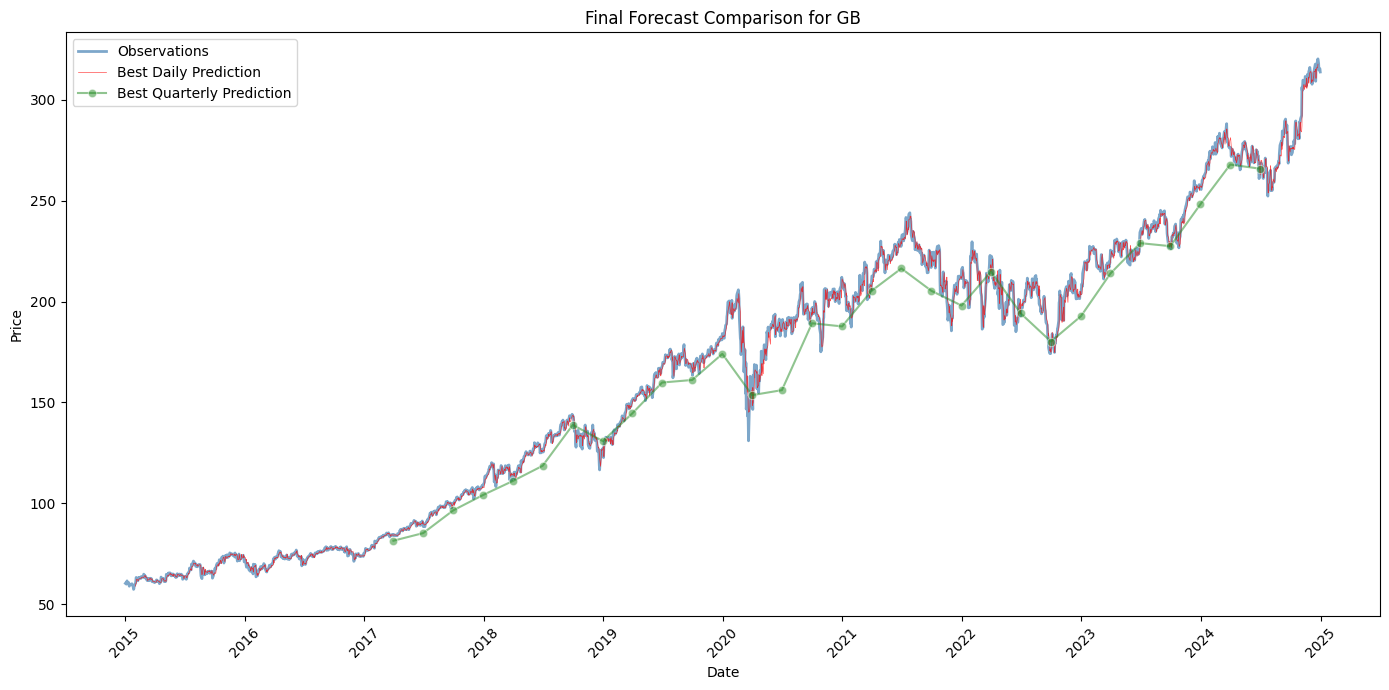

[INFO] Plotting XGB forecasts for V...


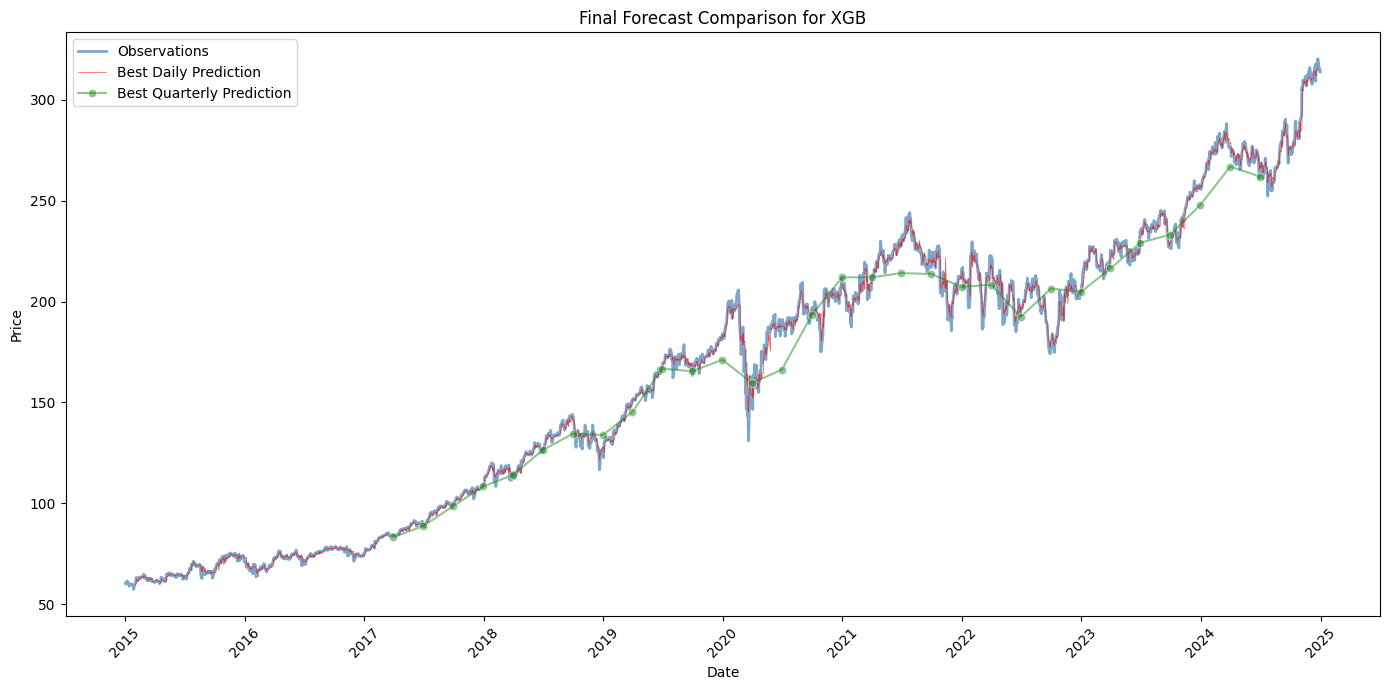

[INFO] Plotting RF forecasts for MA...


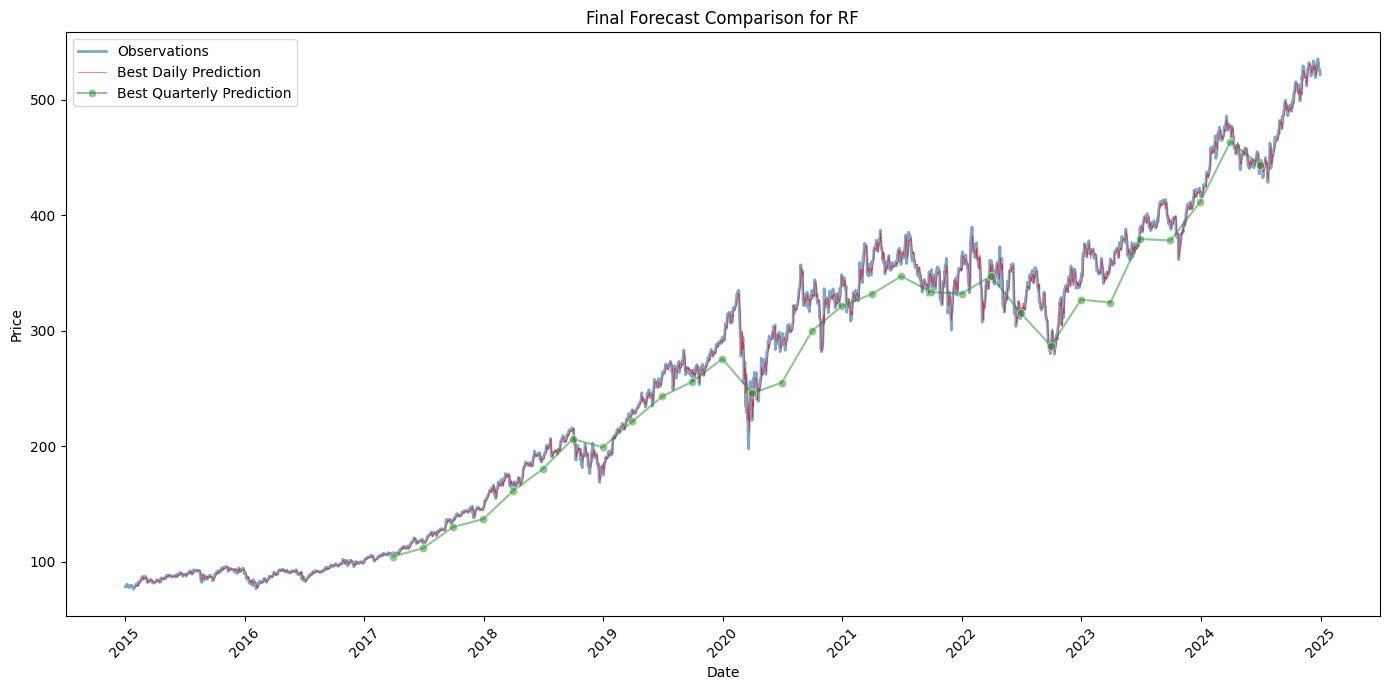

[INFO] Plotting SVM forecasts for MA...


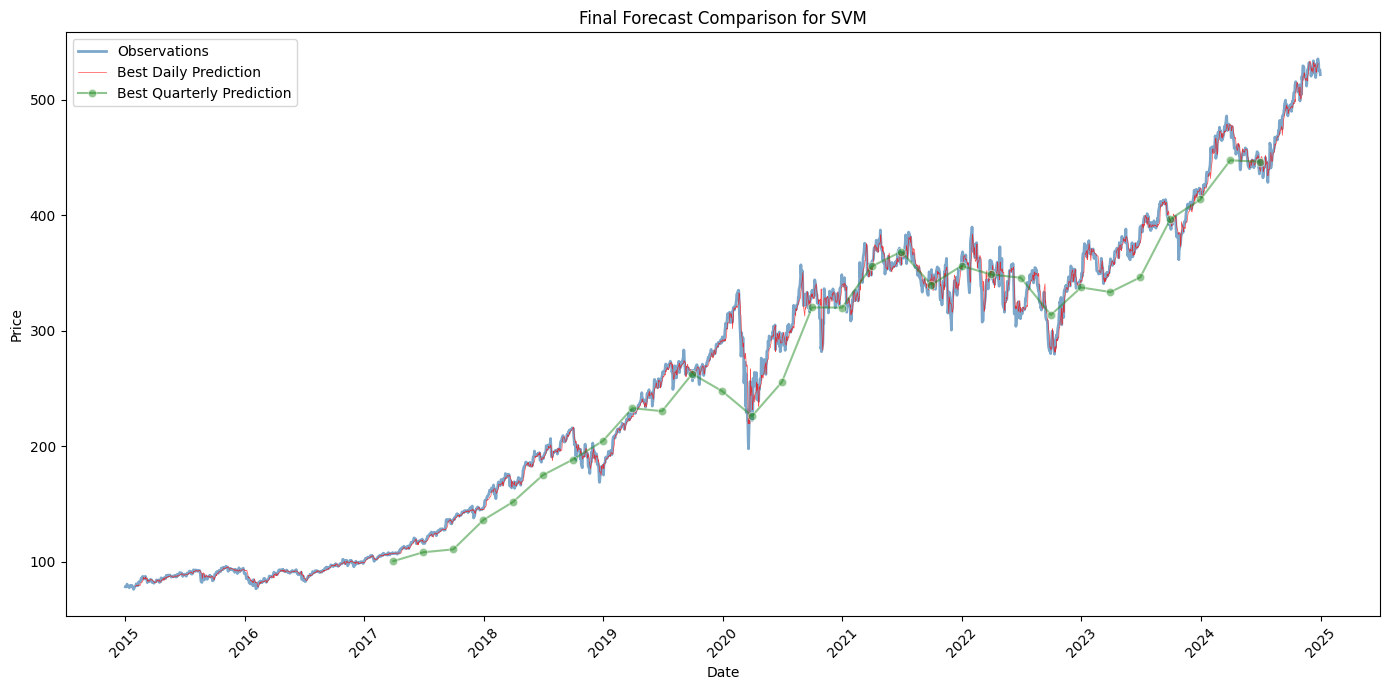

[INFO] Plotting GB forecasts for MA...


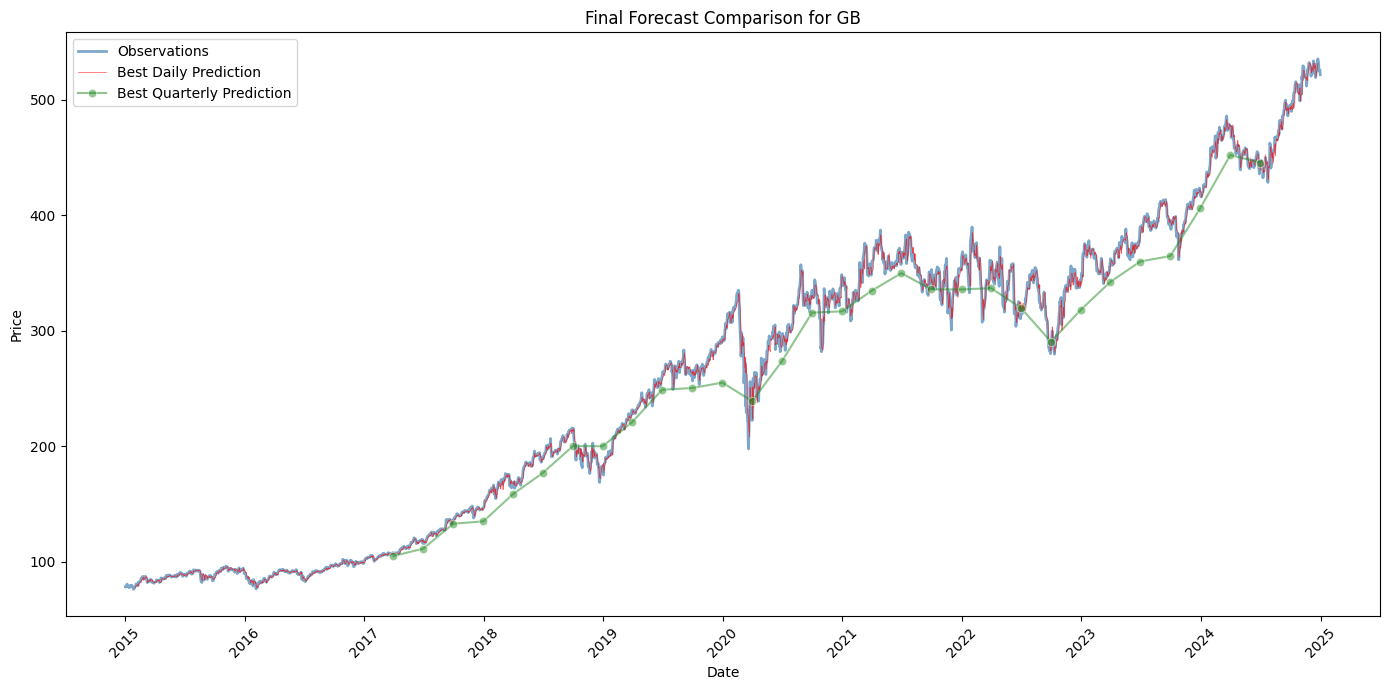

[INFO] Plotting XGB forecasts for MA...


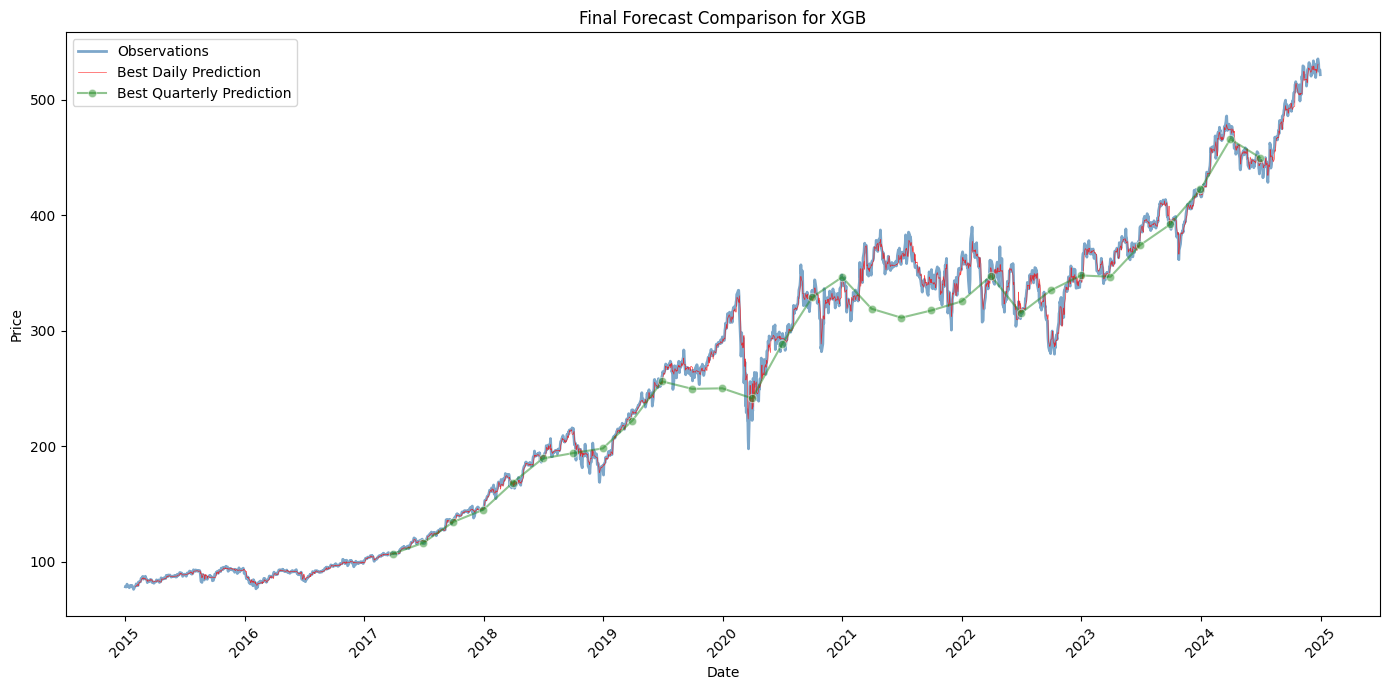

[INFO] Plotting RF forecasts for GOOGL...


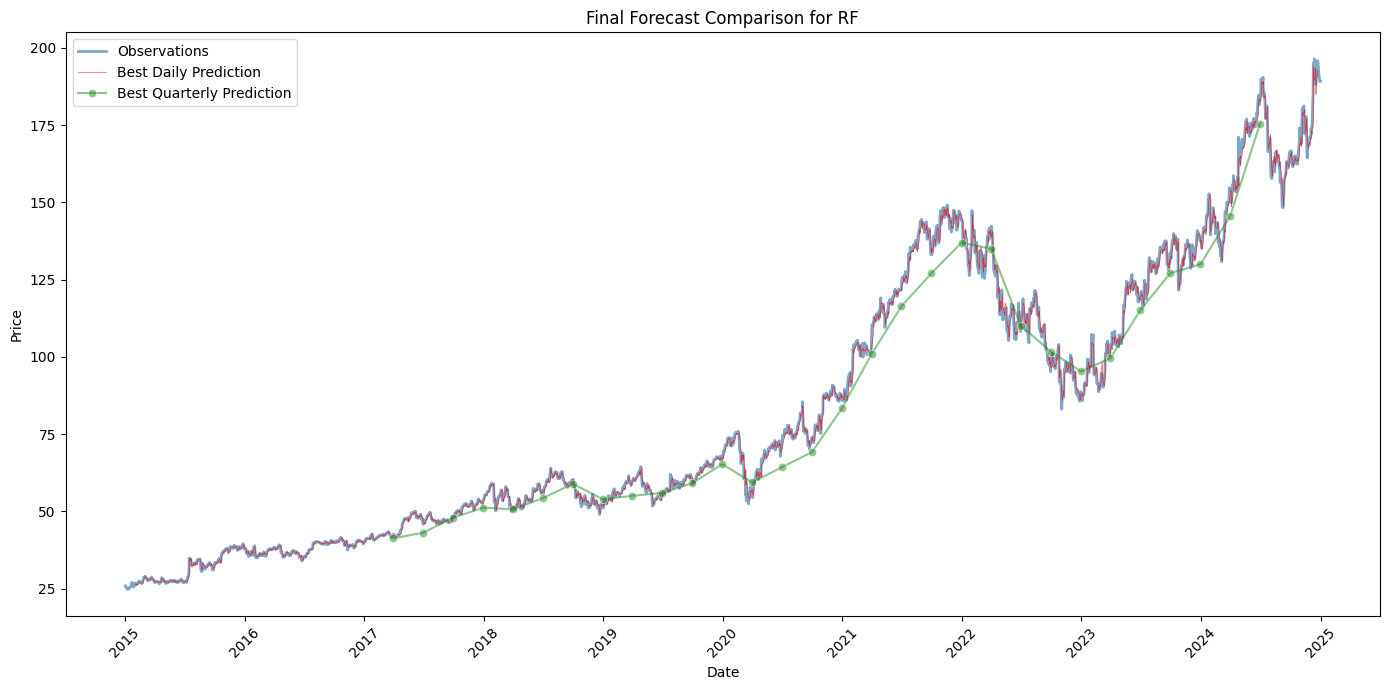

[INFO] Plotting SVM forecasts for GOOGL...


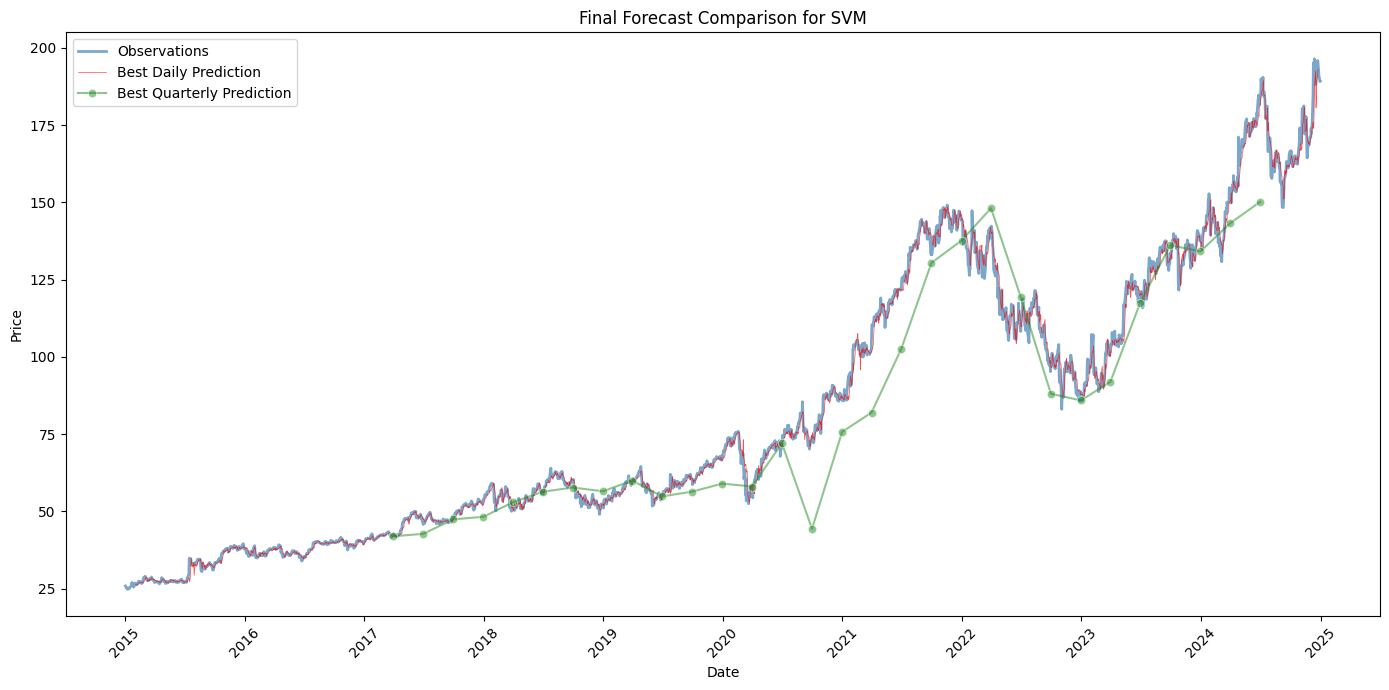

[INFO] Plotting GB forecasts for GOOGL...


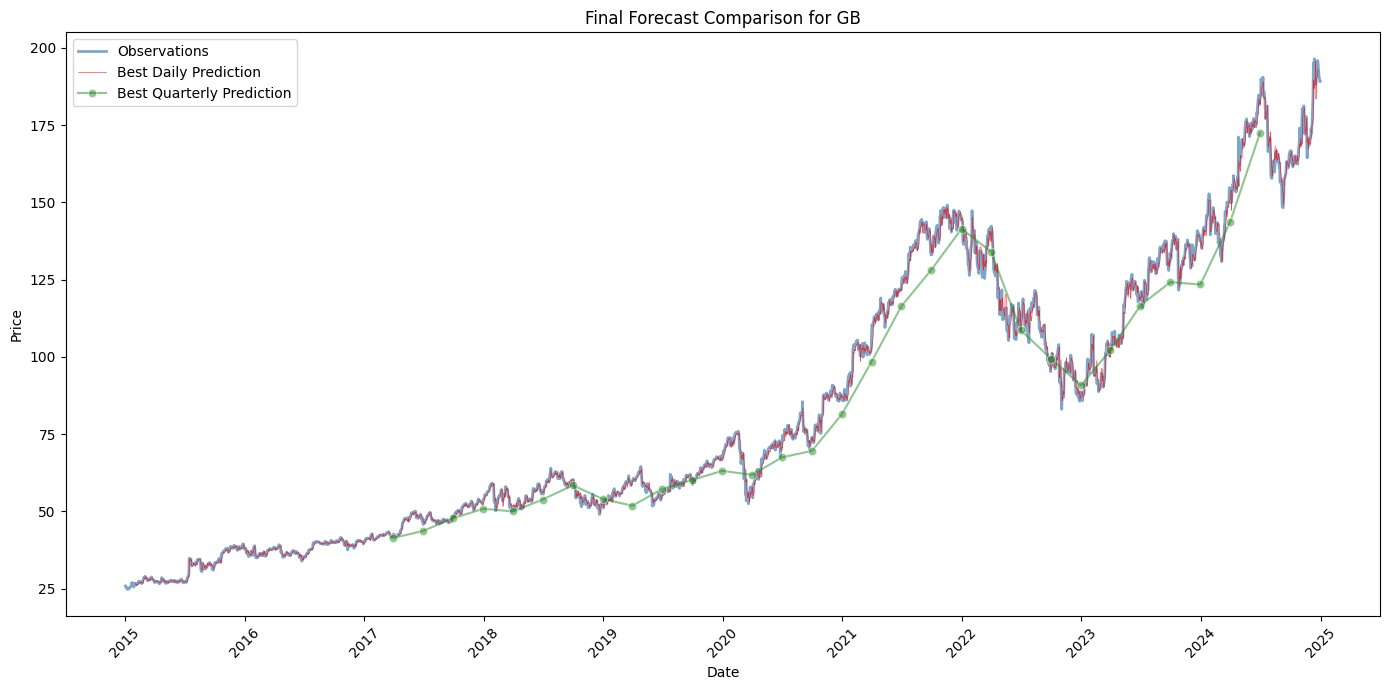

[INFO] Plotting XGB forecasts for GOOGL...


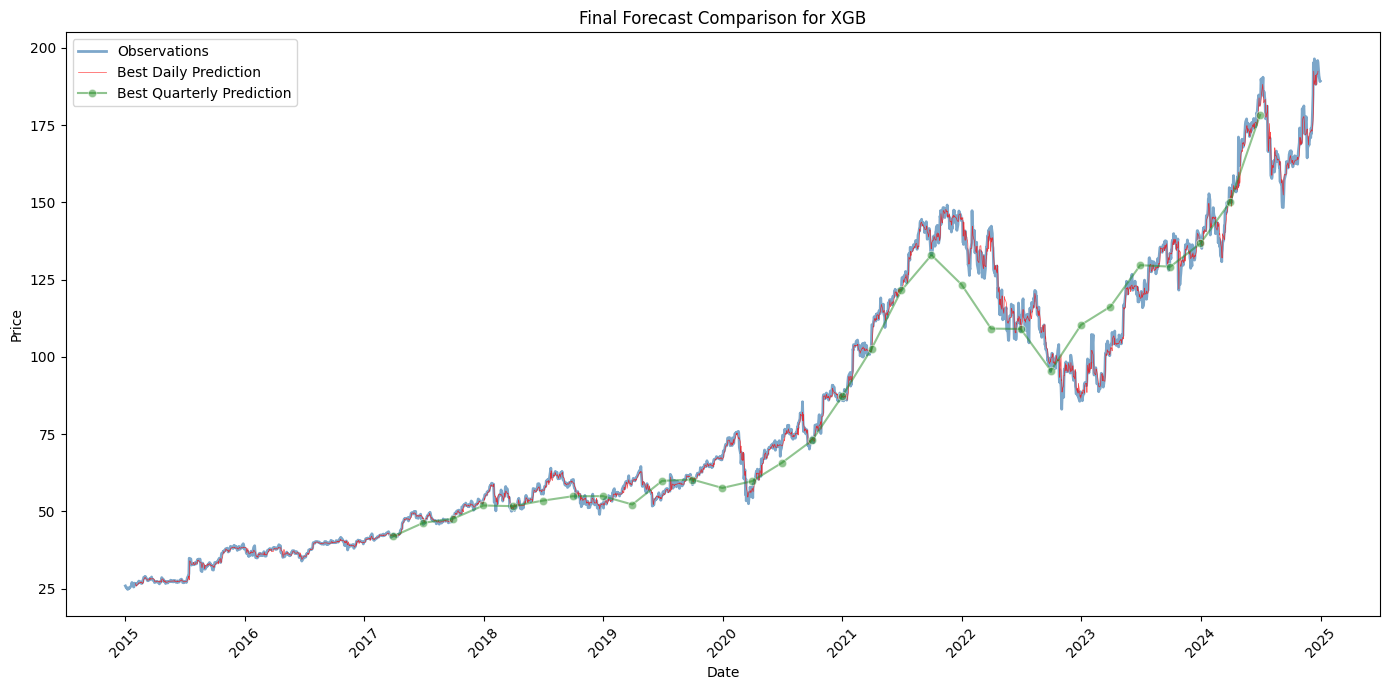

[INFO] Plotting RF forecasts for META...


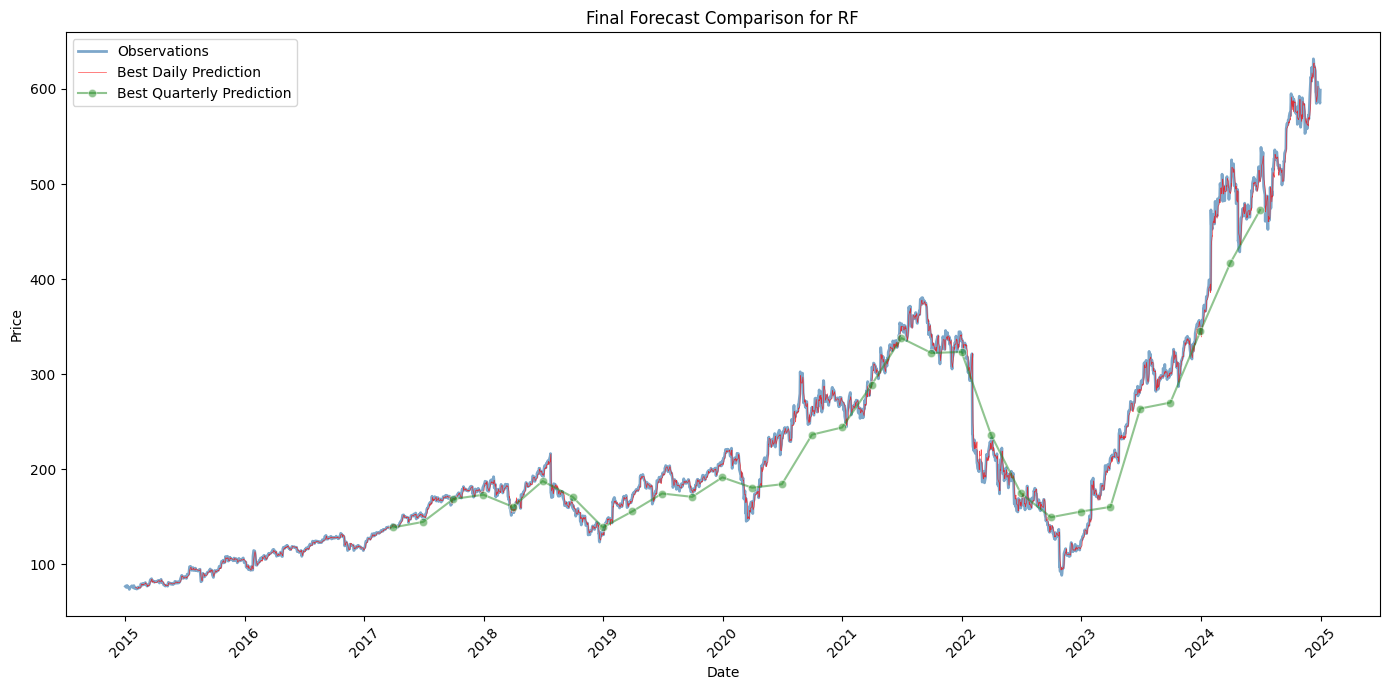

[INFO] Plotting SVM forecasts for META...


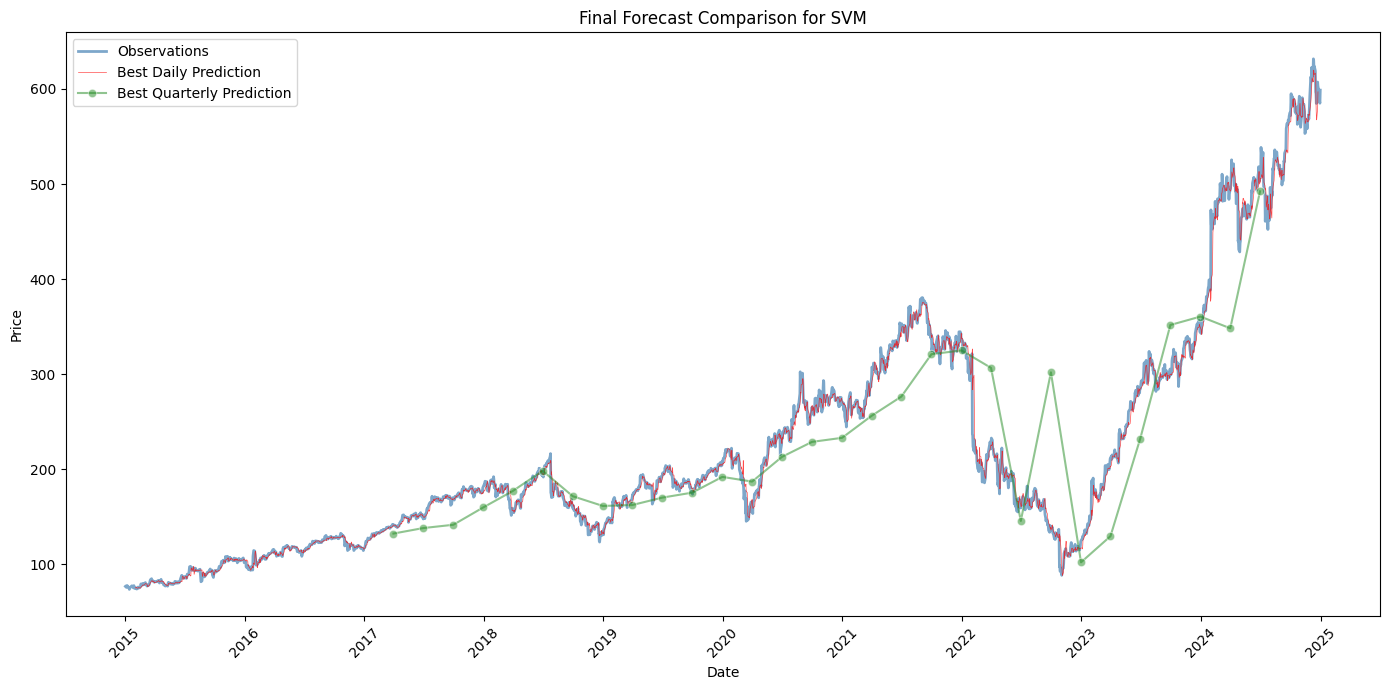

[INFO] Plotting GB forecasts for META...


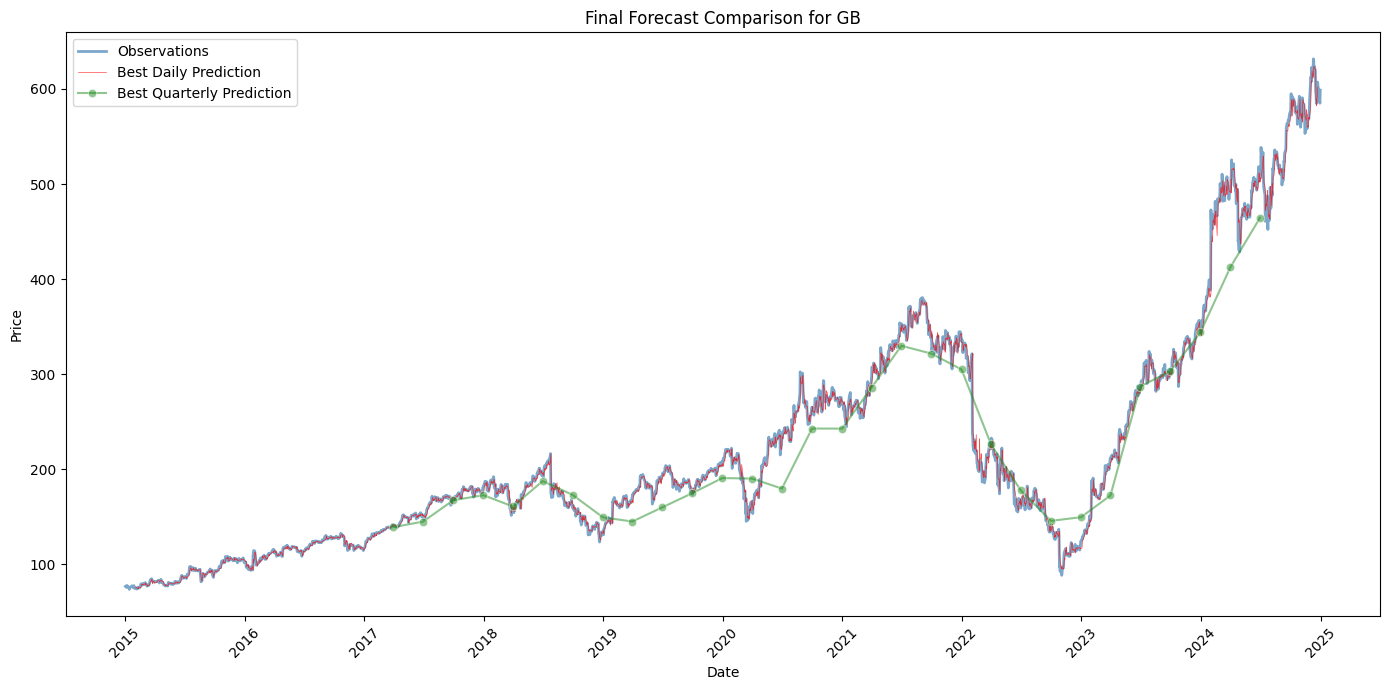

[INFO] Plotting XGB forecasts for META...


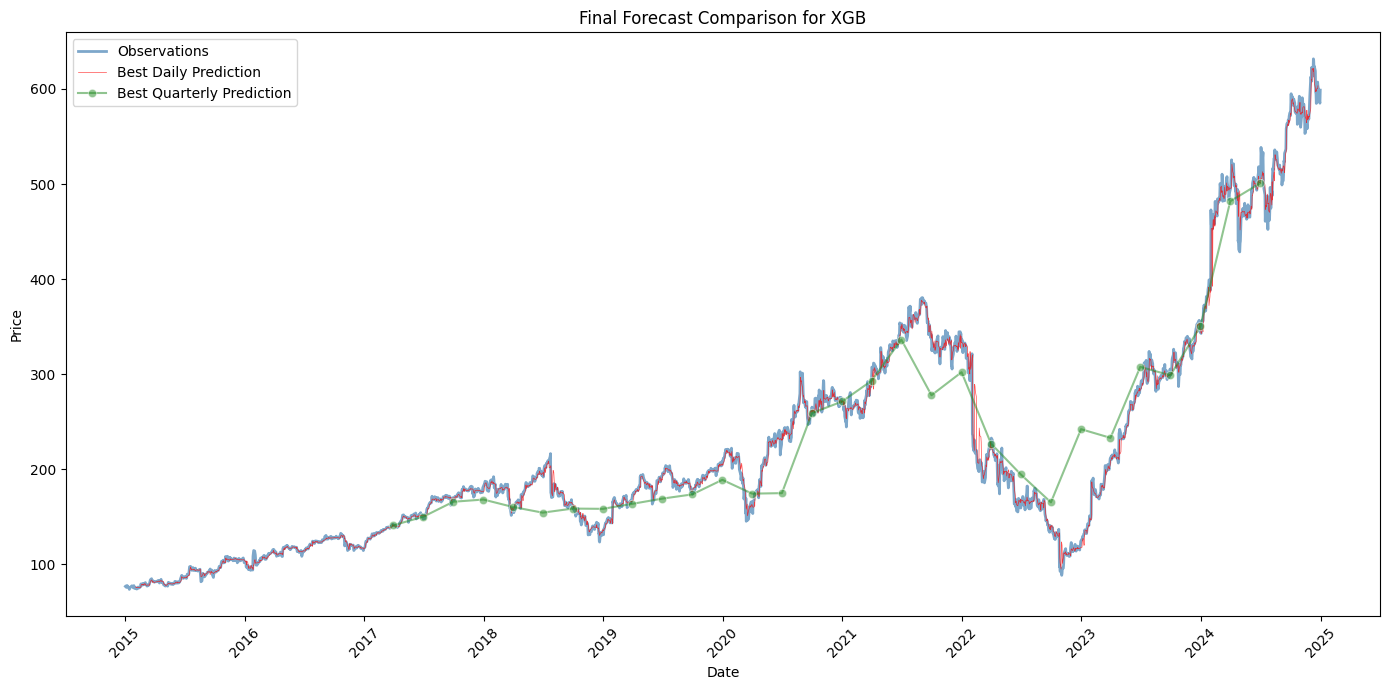

[INFO] Plotting RF forecasts for AMZN...


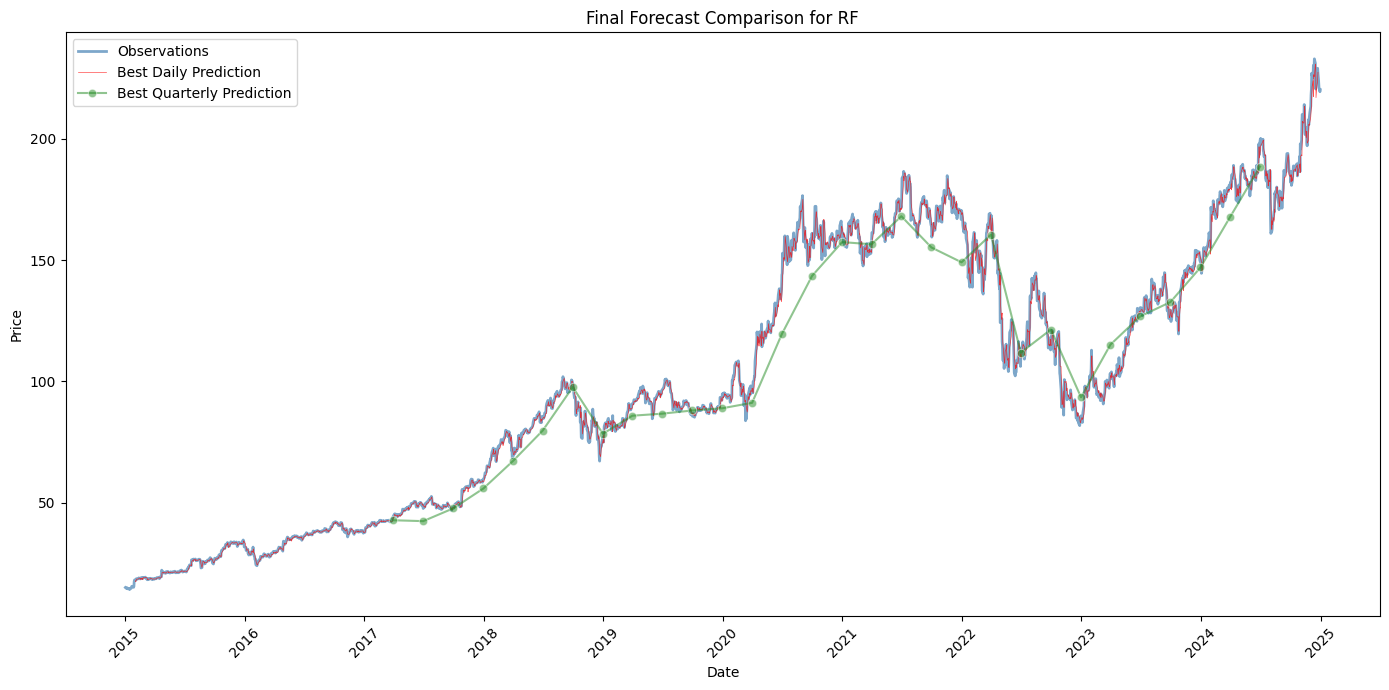

[INFO] Plotting SVM forecasts for AMZN...


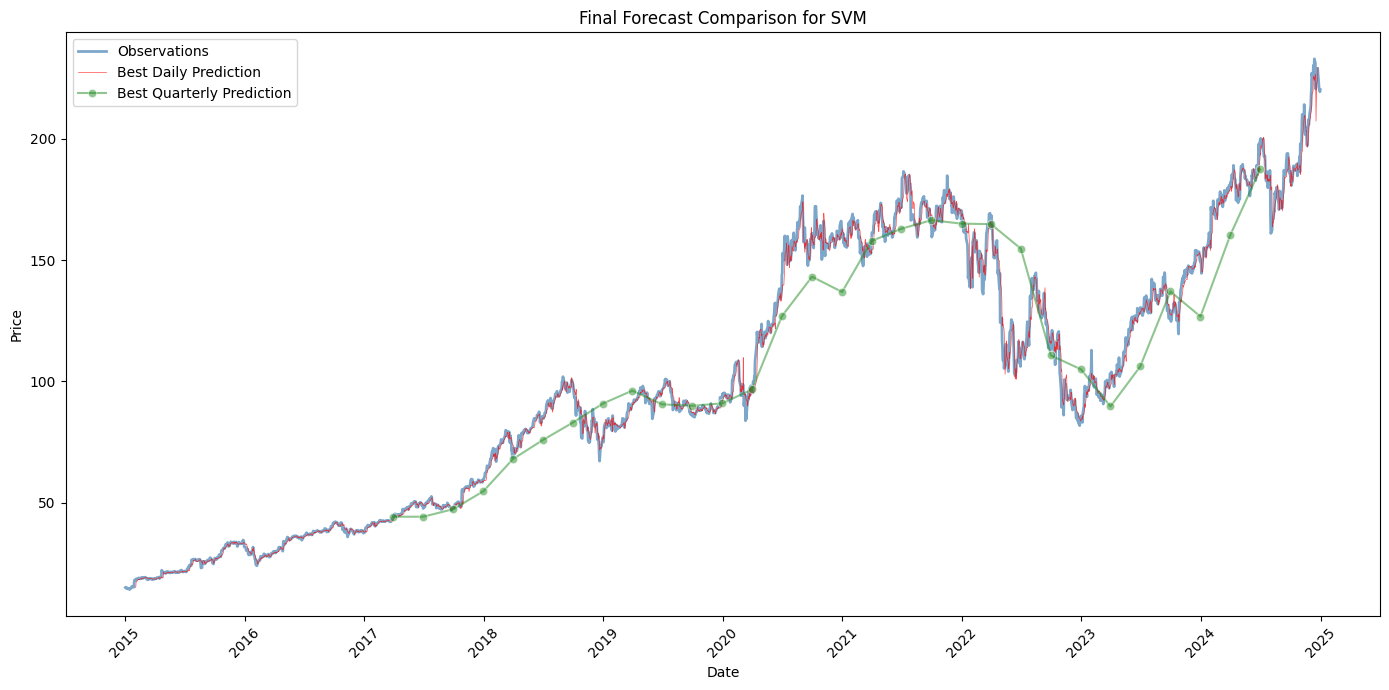

[INFO] Plotting GB forecasts for AMZN...


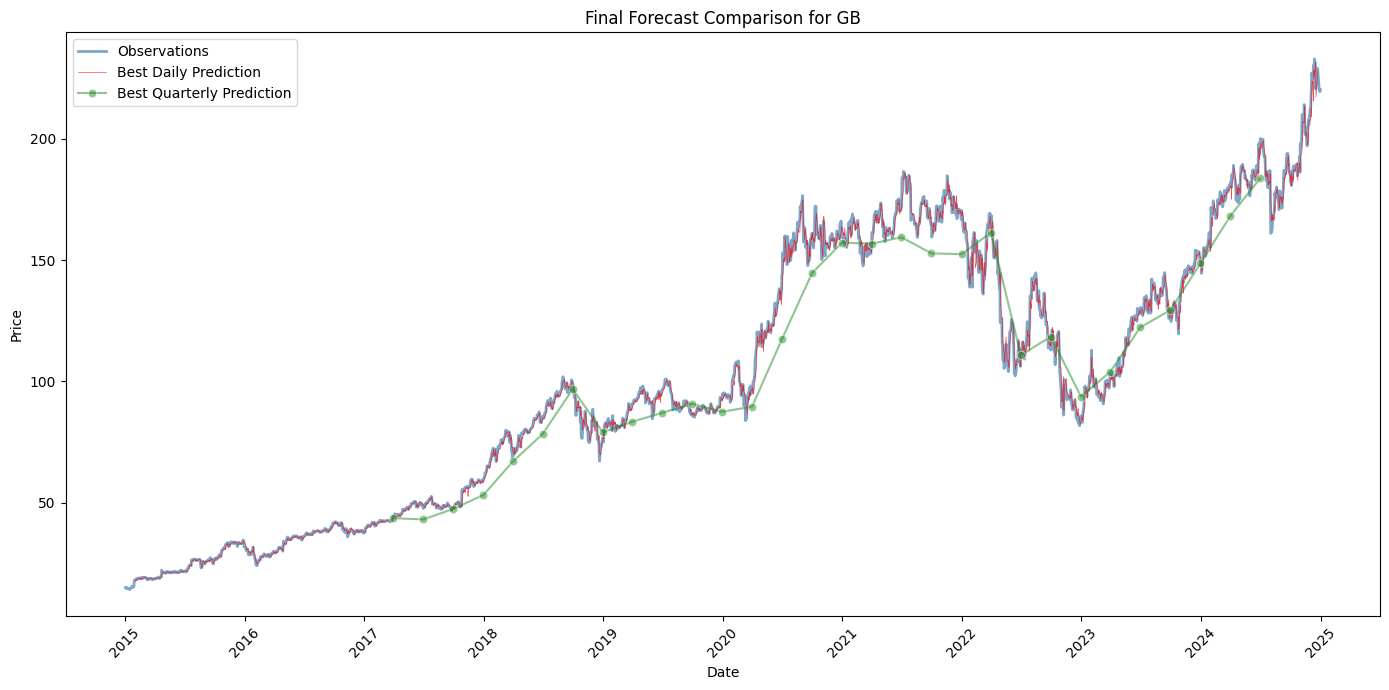

[INFO] Plotting XGB forecasts for AMZN...


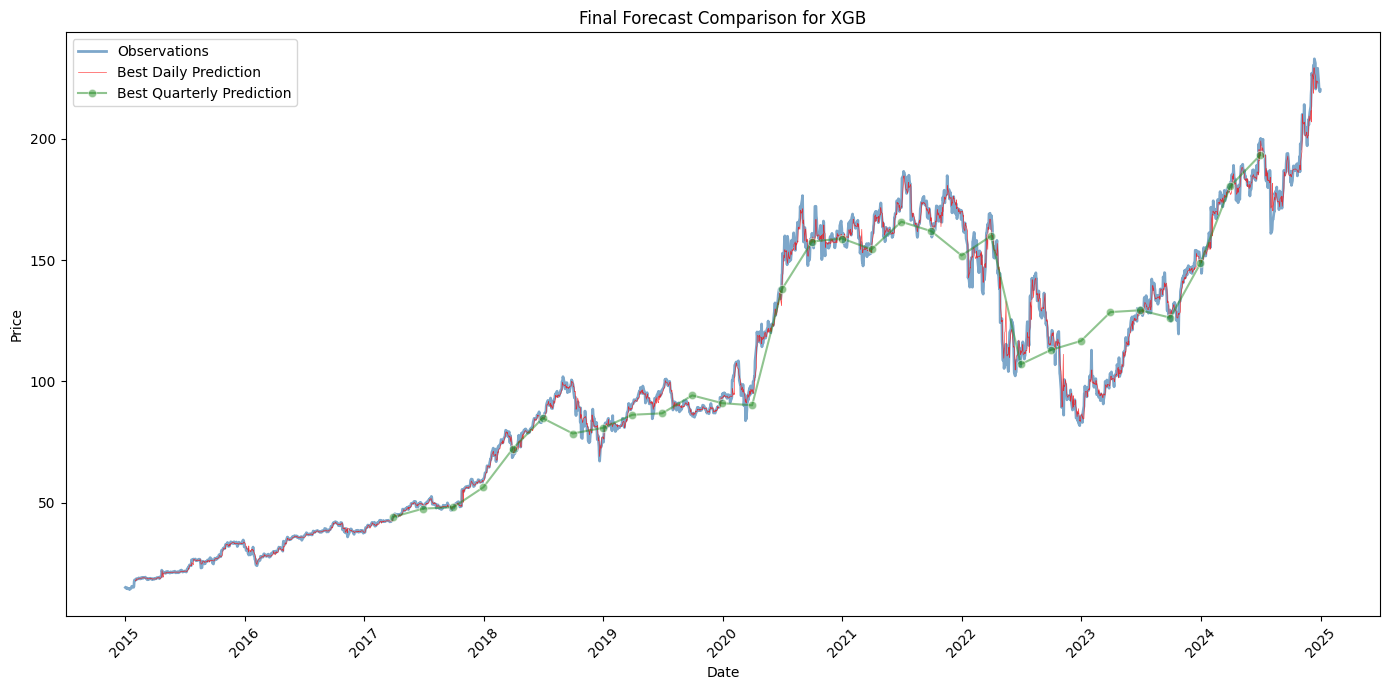

[INFO] Plotting RF forecasts for TSLA...


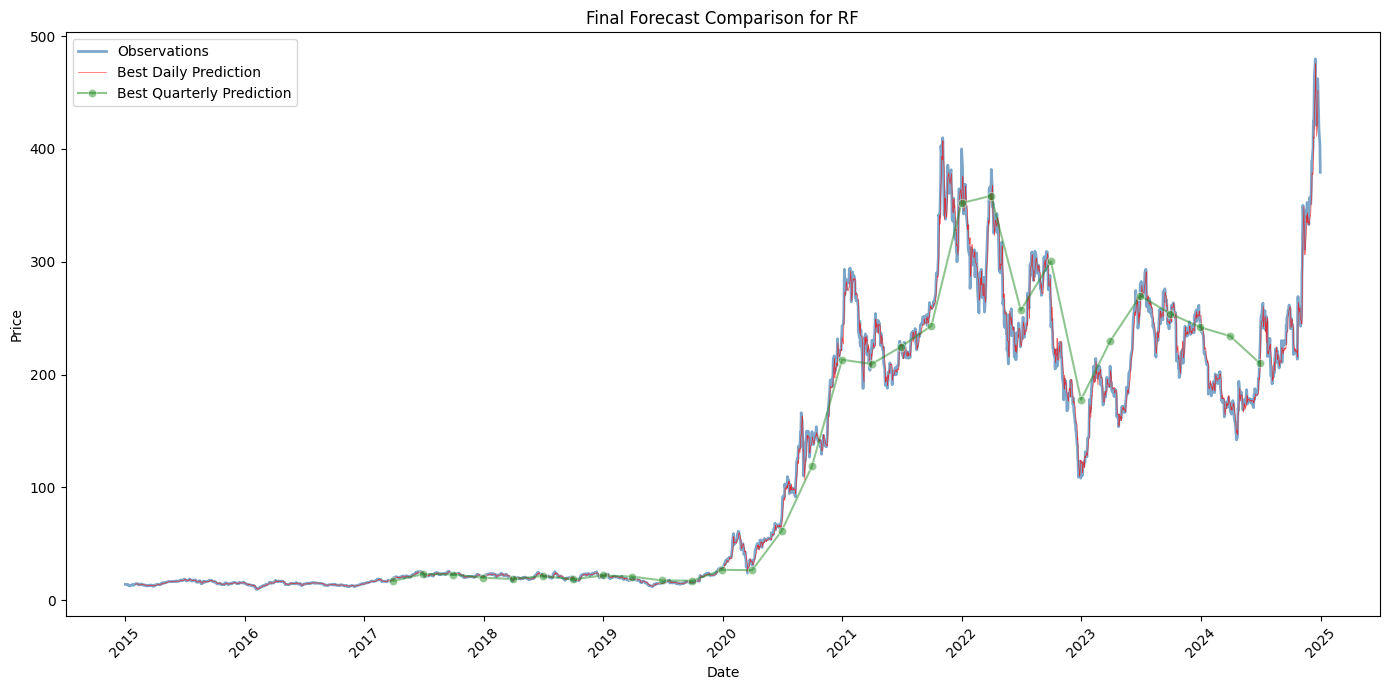

[INFO] Plotting SVM forecasts for TSLA...


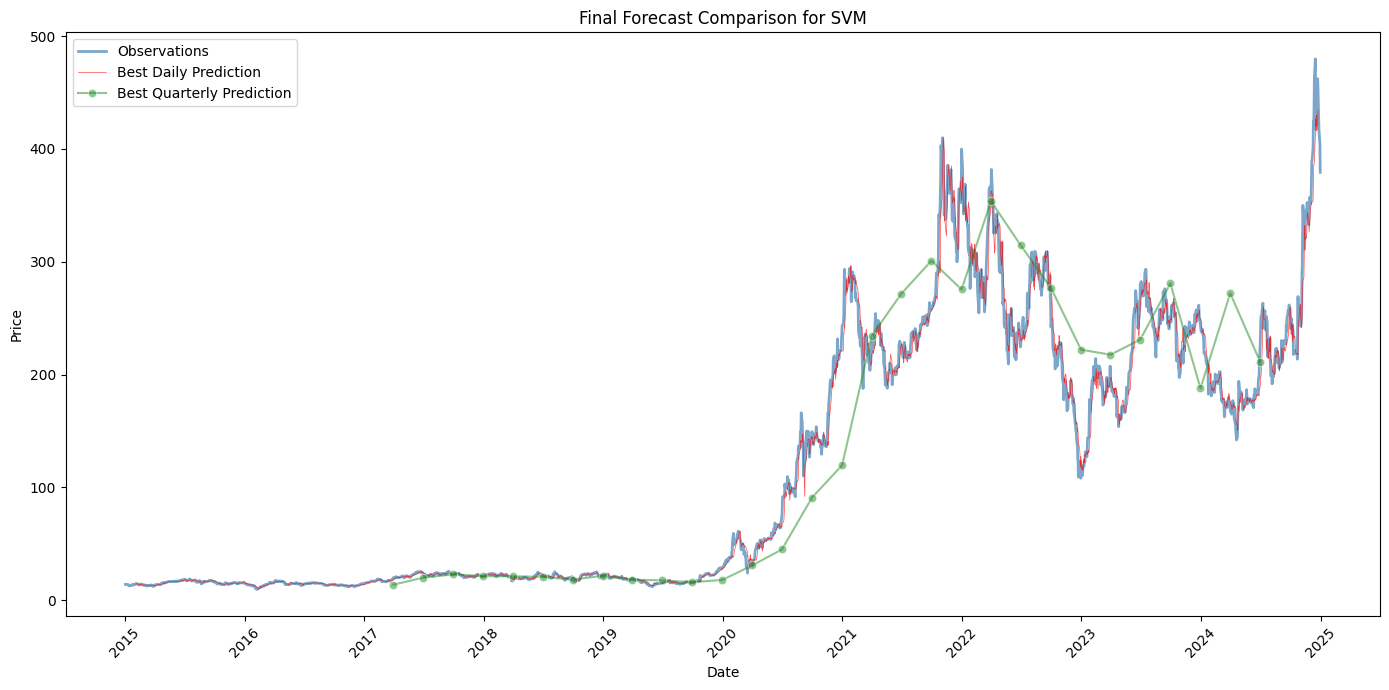

[INFO] Plotting GB forecasts for TSLA...


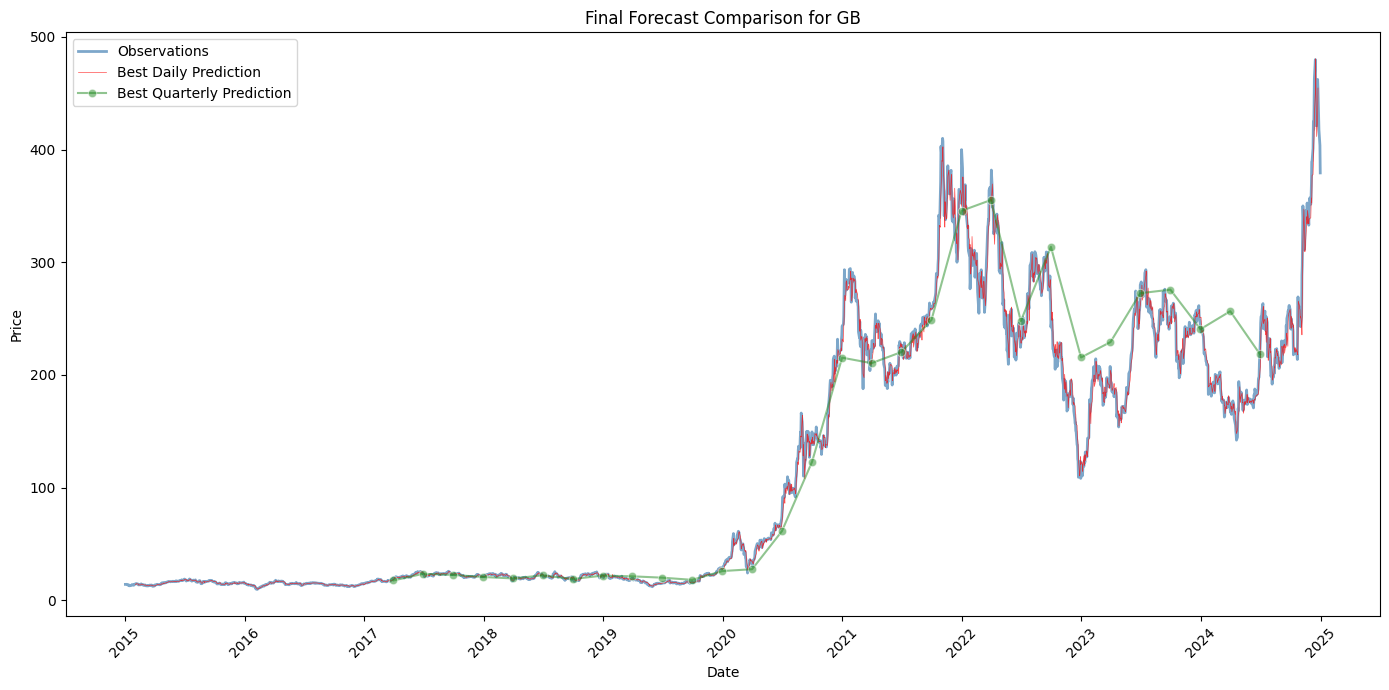

[INFO] Plotting XGB forecasts for TSLA...


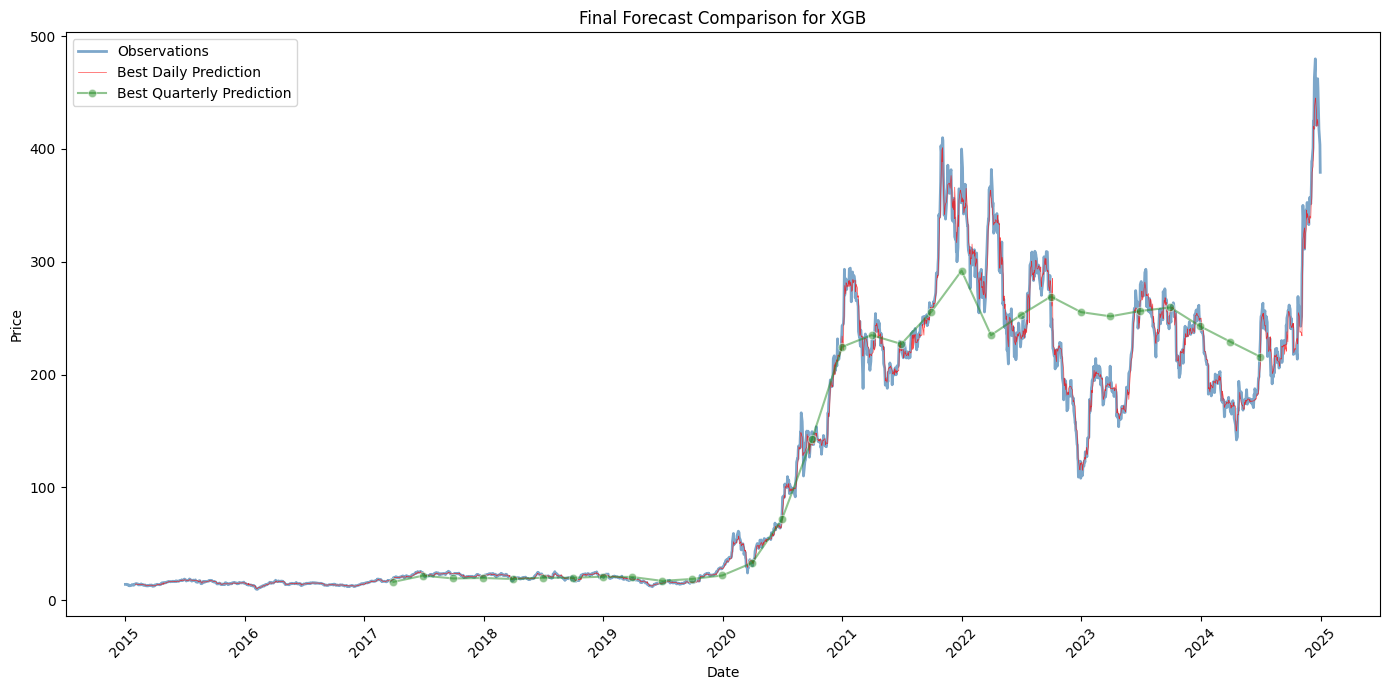

[INFO] Plotting RF forecasts for PG...


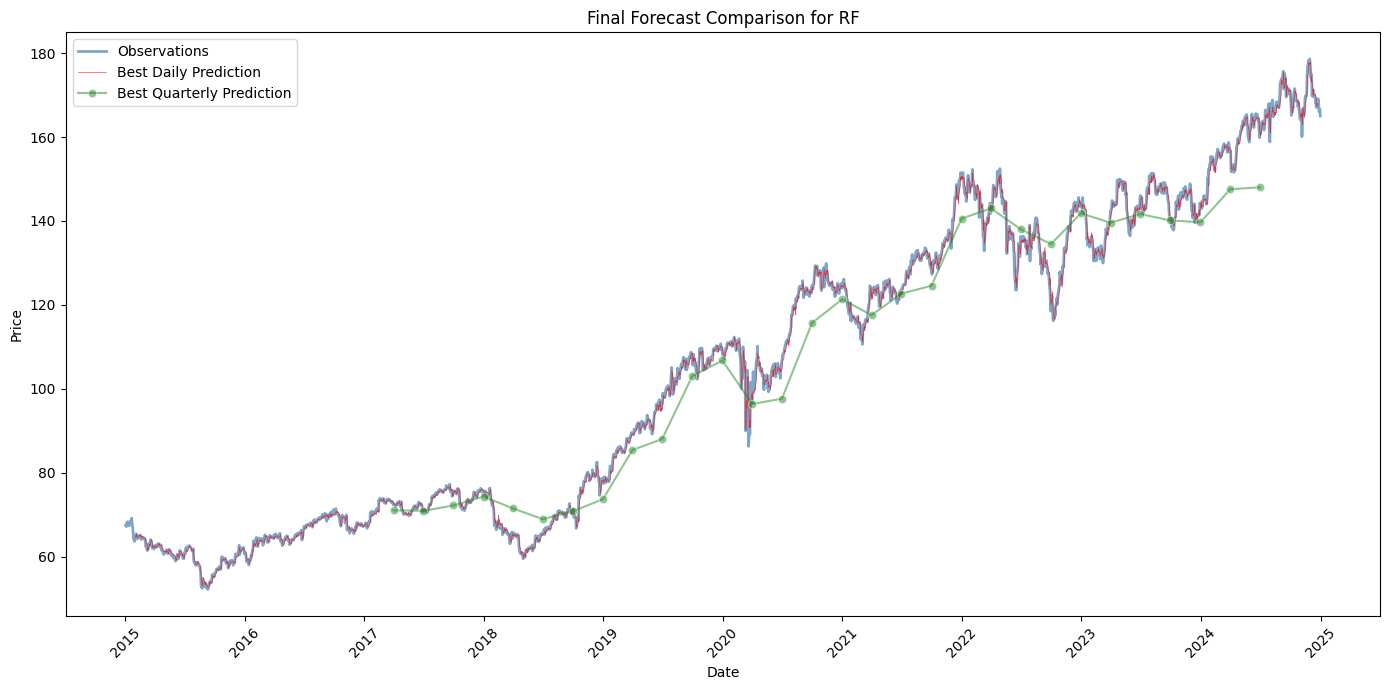

[INFO] Plotting SVM forecasts for PG...


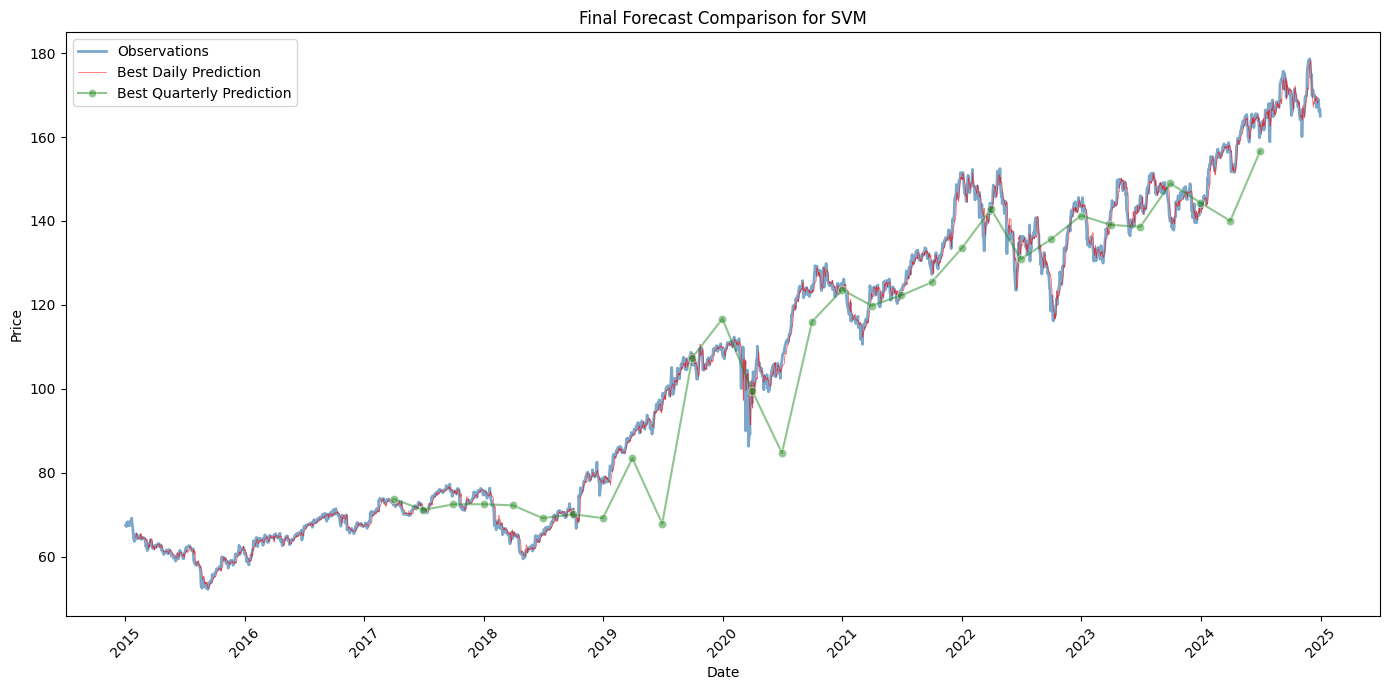

[INFO] Plotting GB forecasts for PG...


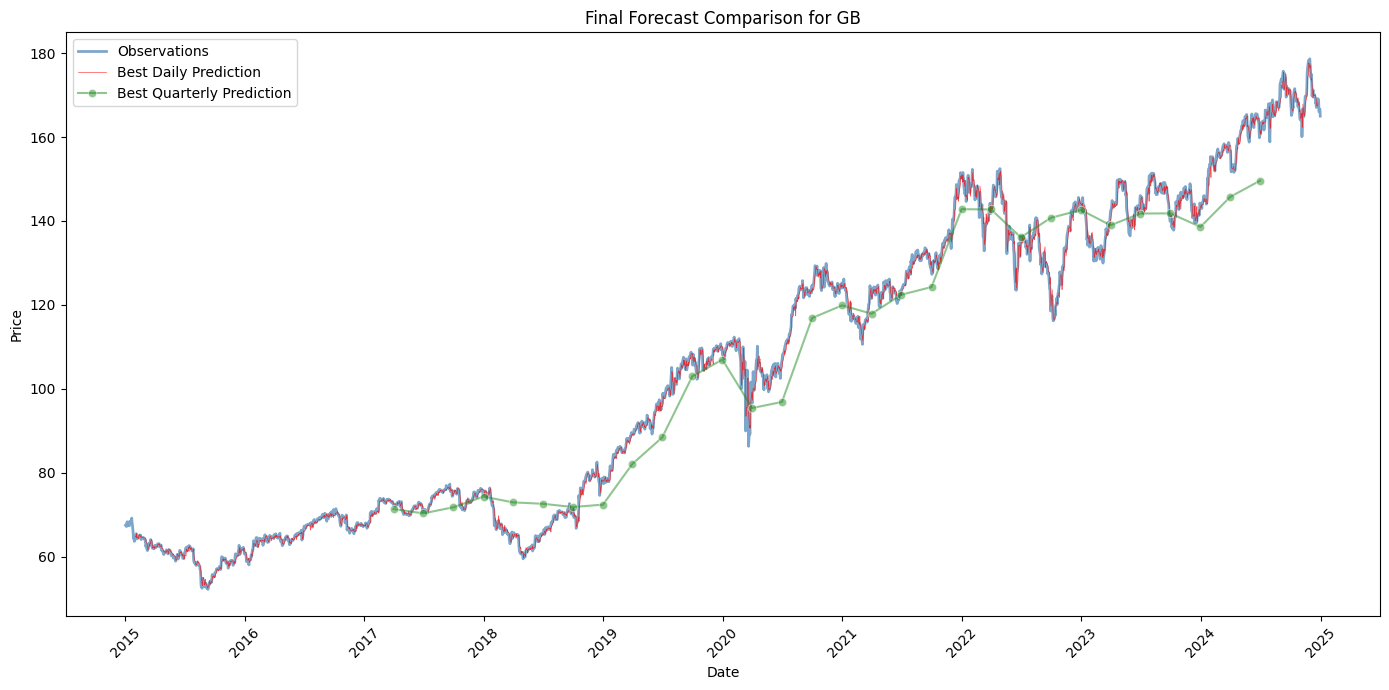

[INFO] Plotting XGB forecasts for PG...


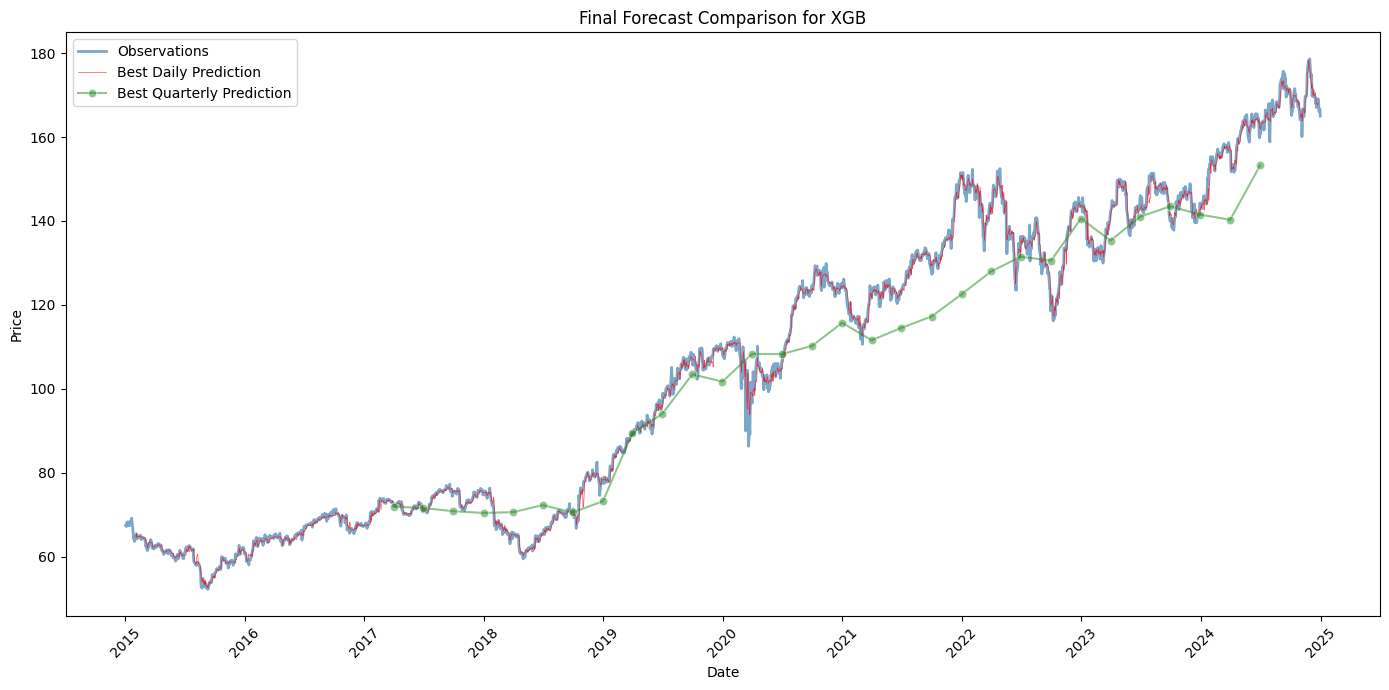

[INFO] Plotting RF forecasts for WMT...


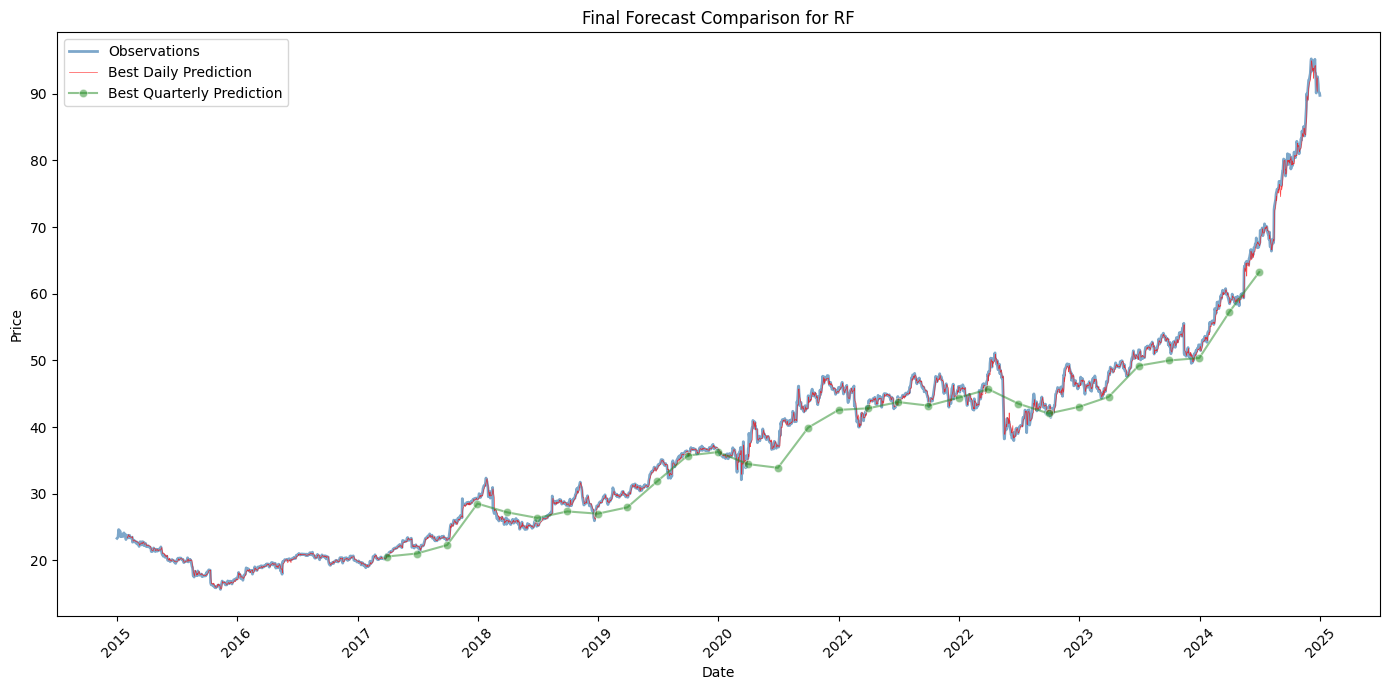

[INFO] Plotting SVM forecasts for WMT...


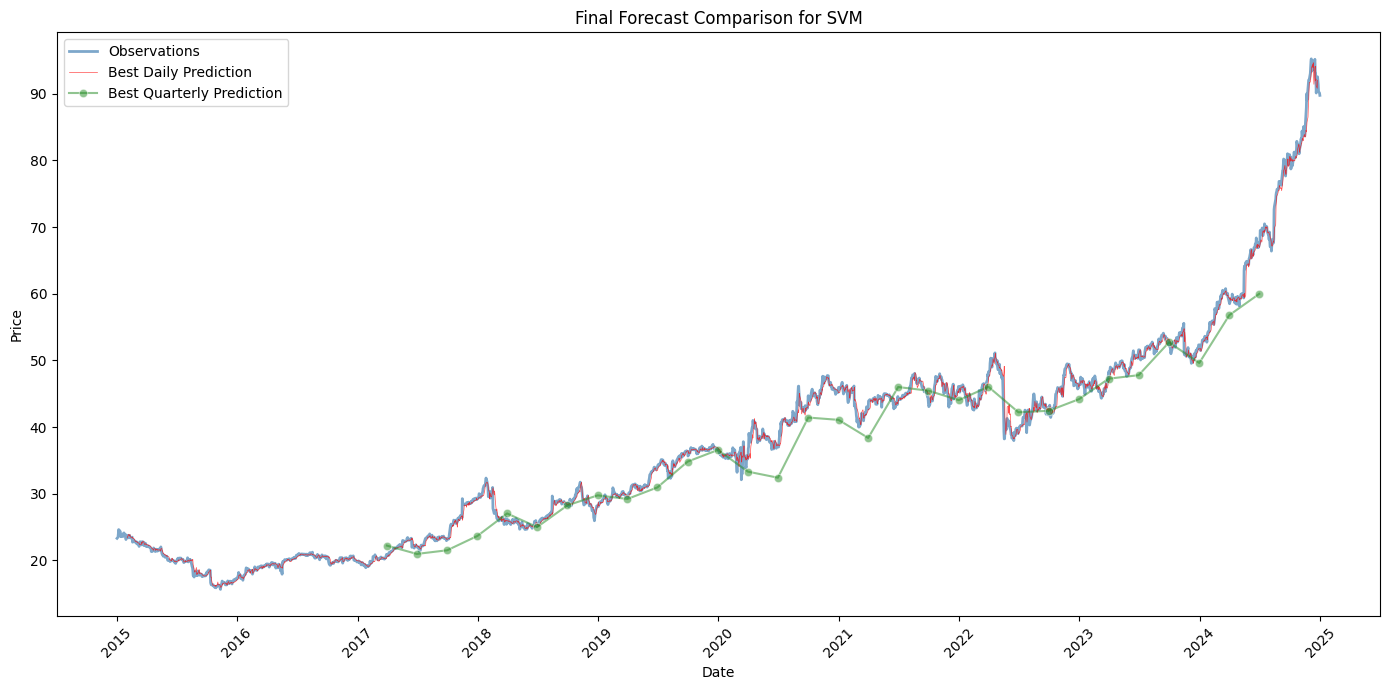

[INFO] Plotting GB forecasts for WMT...


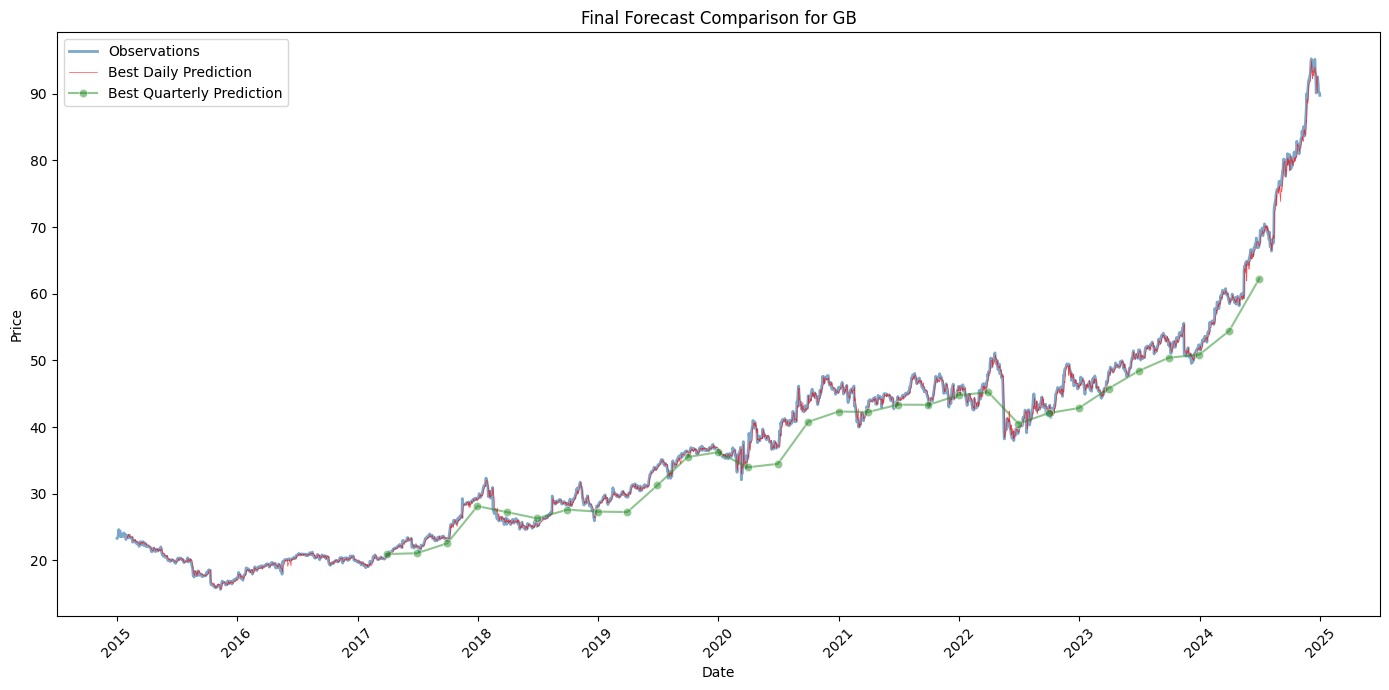

[INFO] Plotting XGB forecasts for WMT...


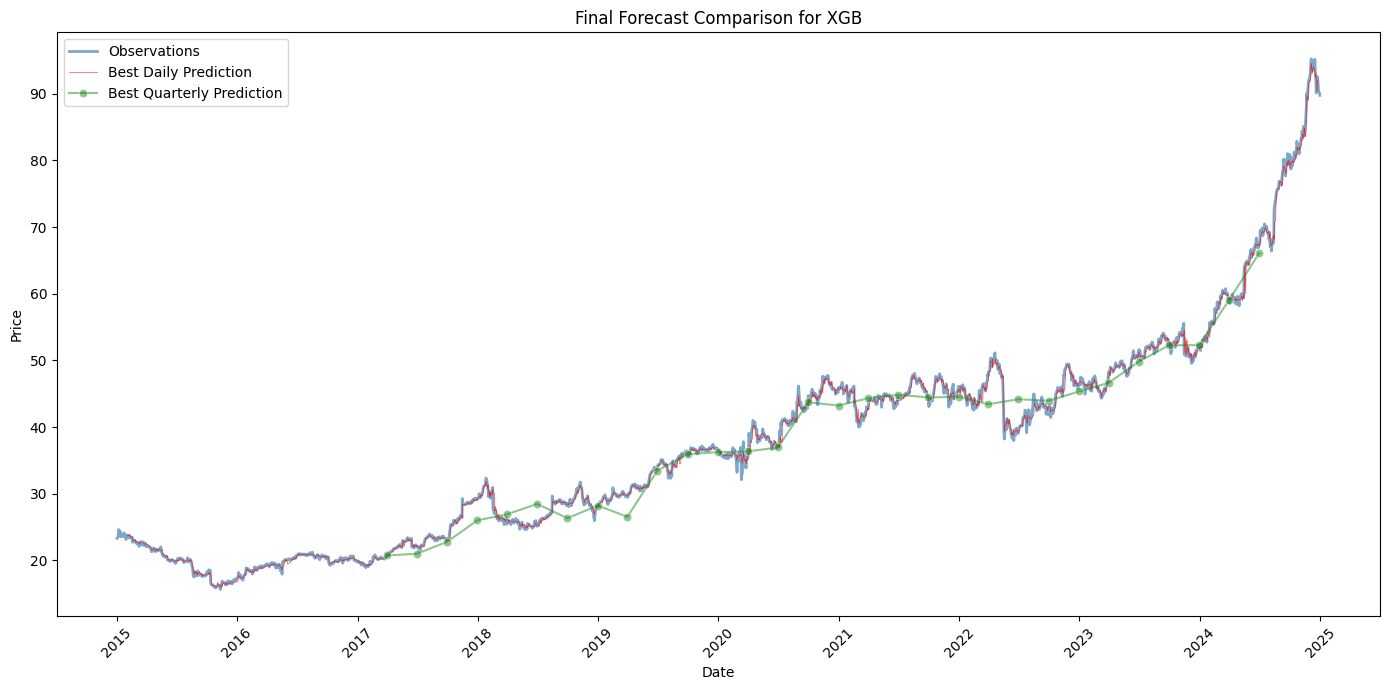

[INFO] Plotting RF forecasts for RTX...


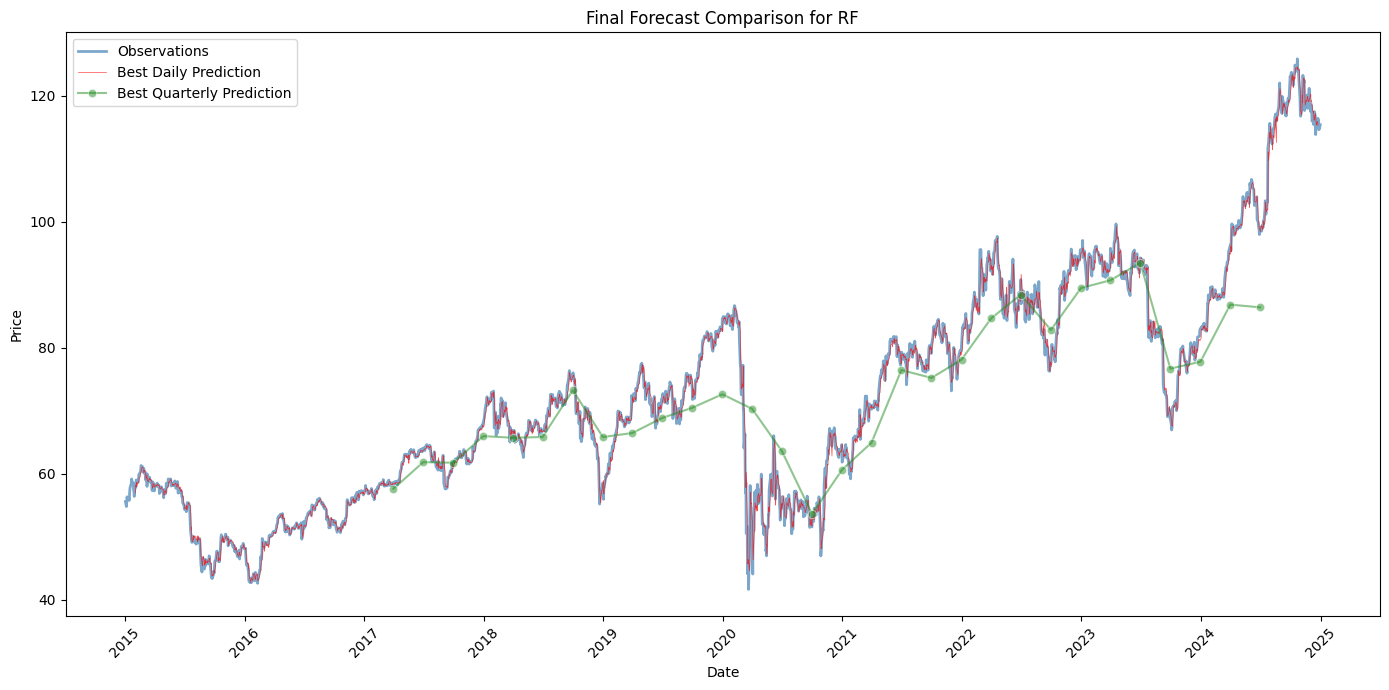

[INFO] Plotting SVM forecasts for RTX...


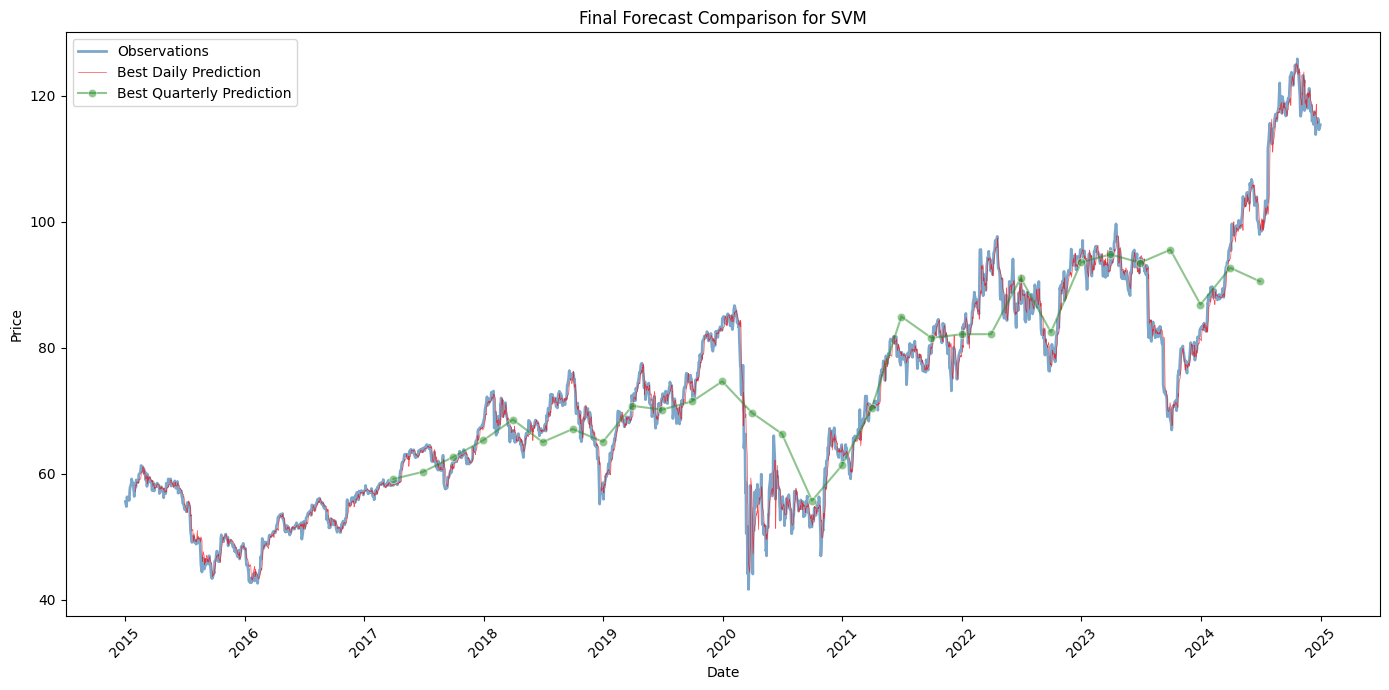

[INFO] Plotting GB forecasts for RTX...


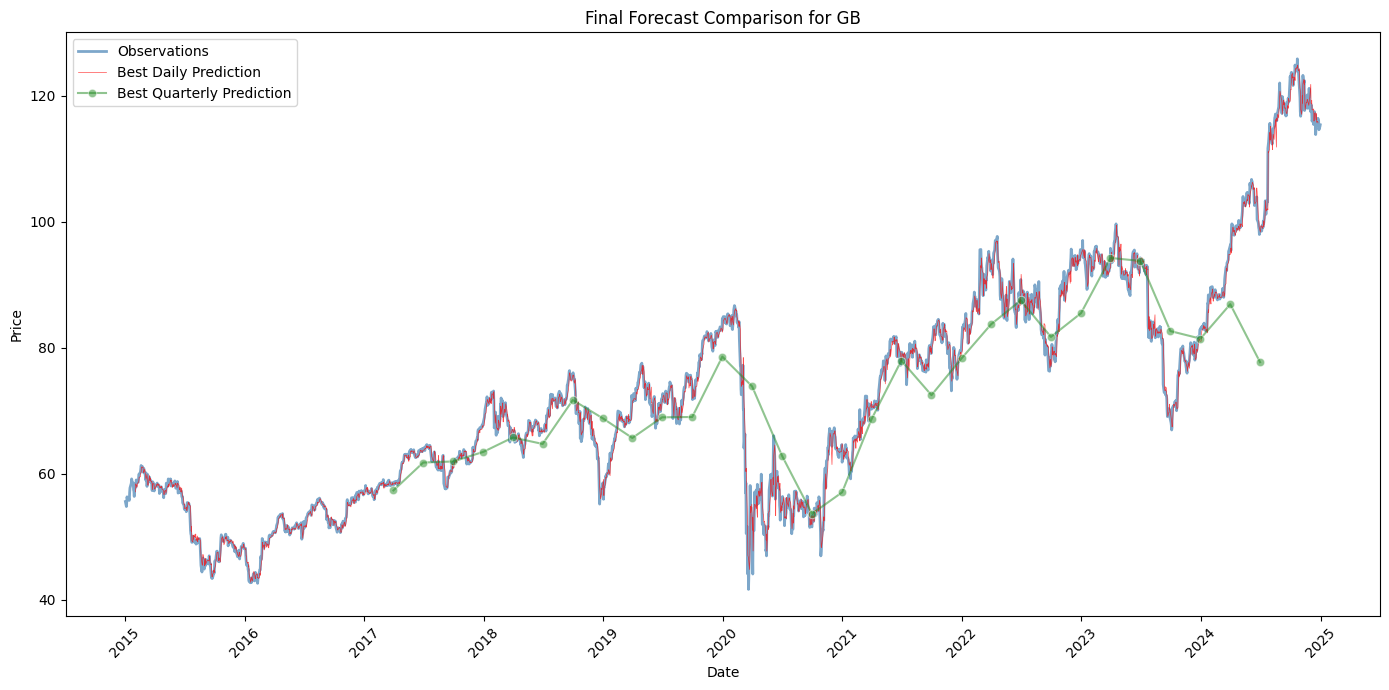

[INFO] Plotting XGB forecasts for RTX...


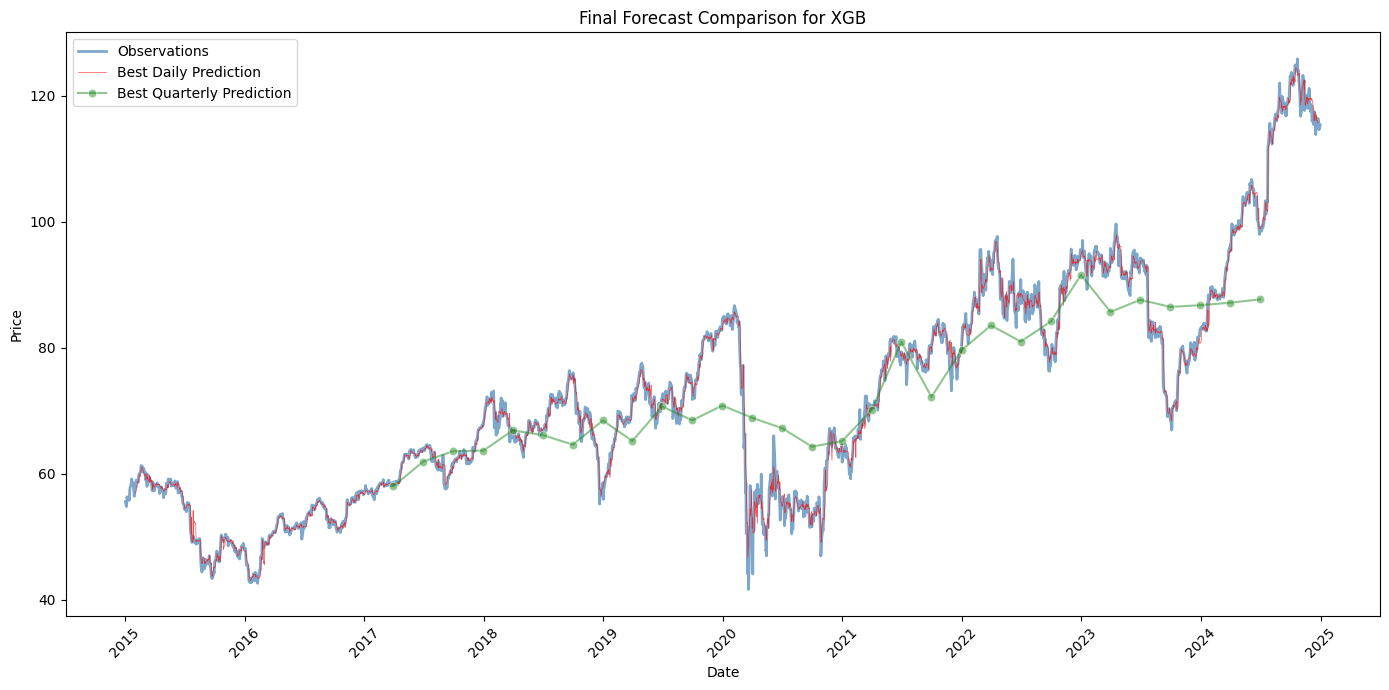

[INFO] Plotting RF forecasts for UNP...


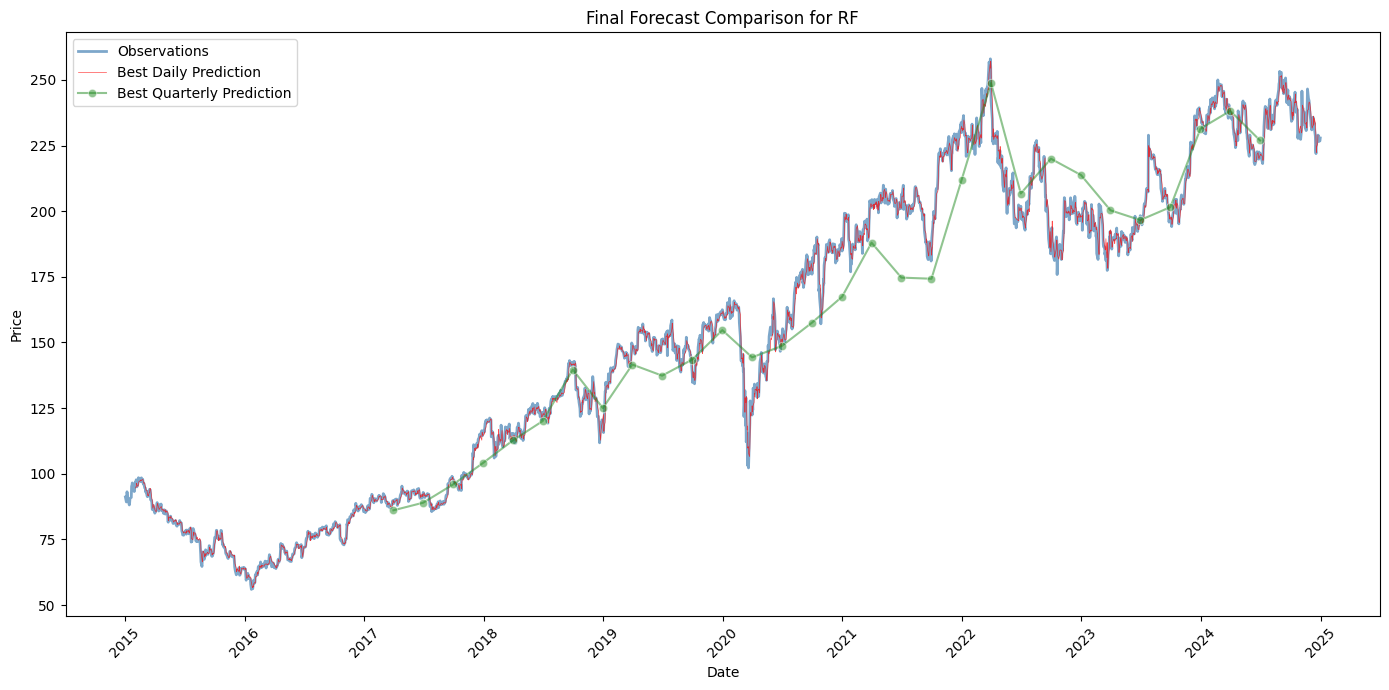

[INFO] Plotting SVM forecasts for UNP...


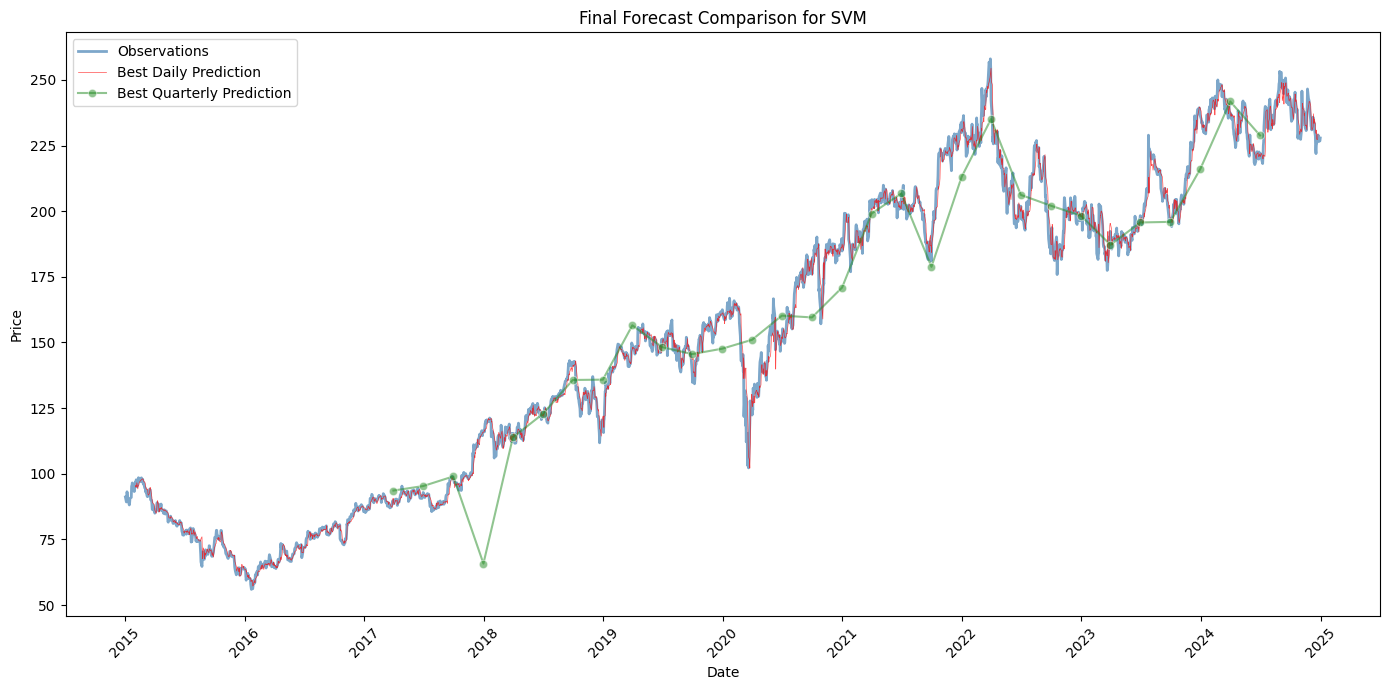

[INFO] Plotting GB forecasts for UNP...


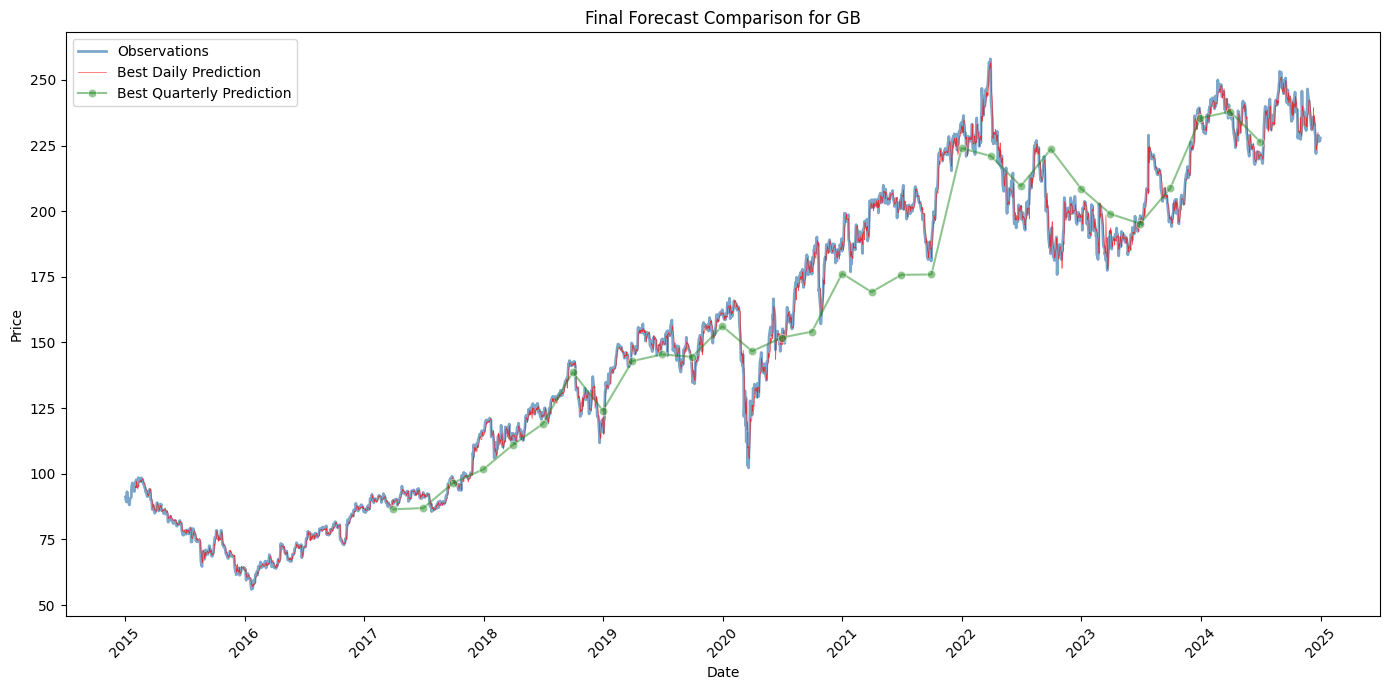

[INFO] Plotting XGB forecasts for UNP...


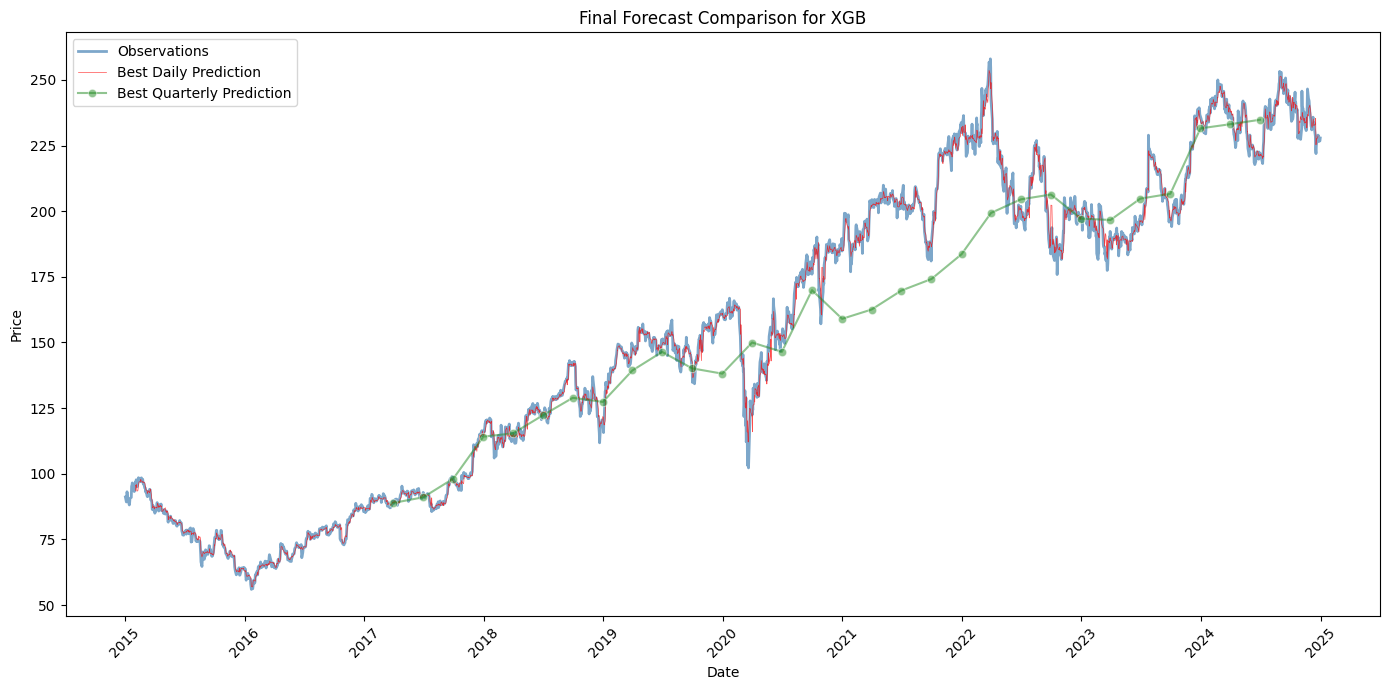

[INFO] Plotting RF forecasts for XOM...


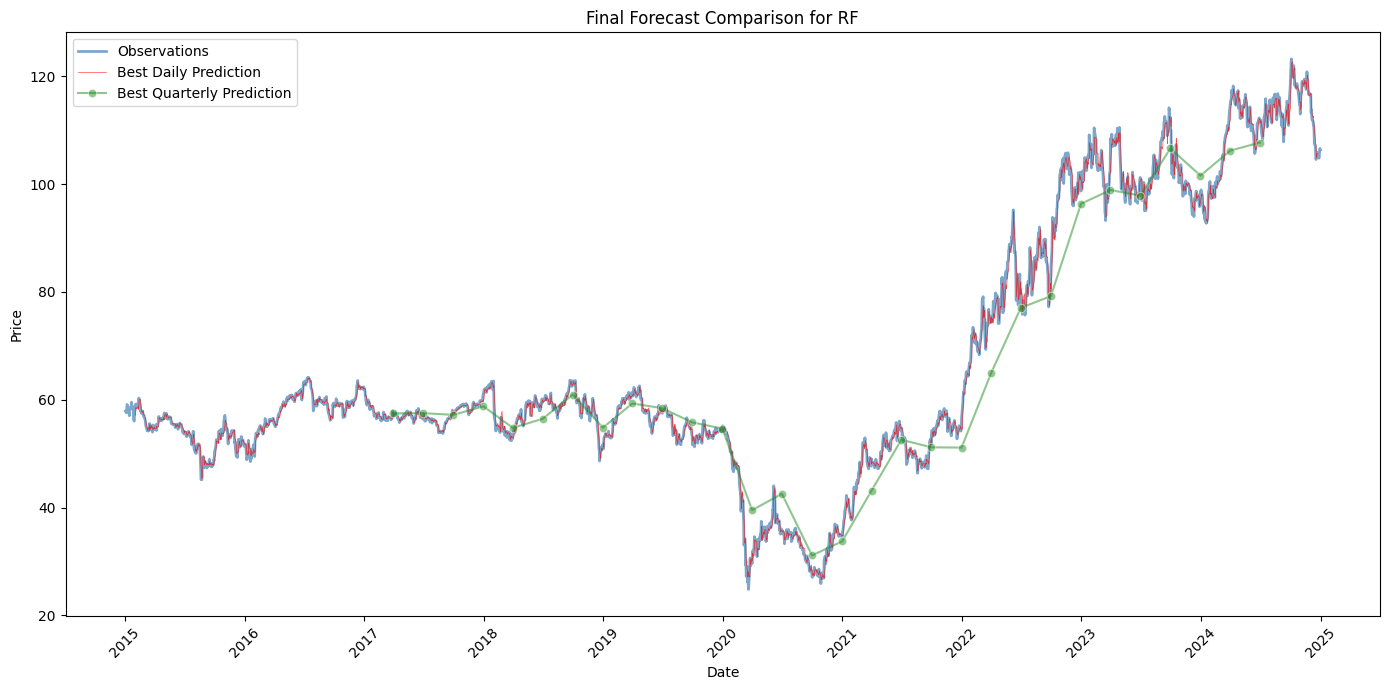

[INFO] Plotting SVM forecasts for XOM...


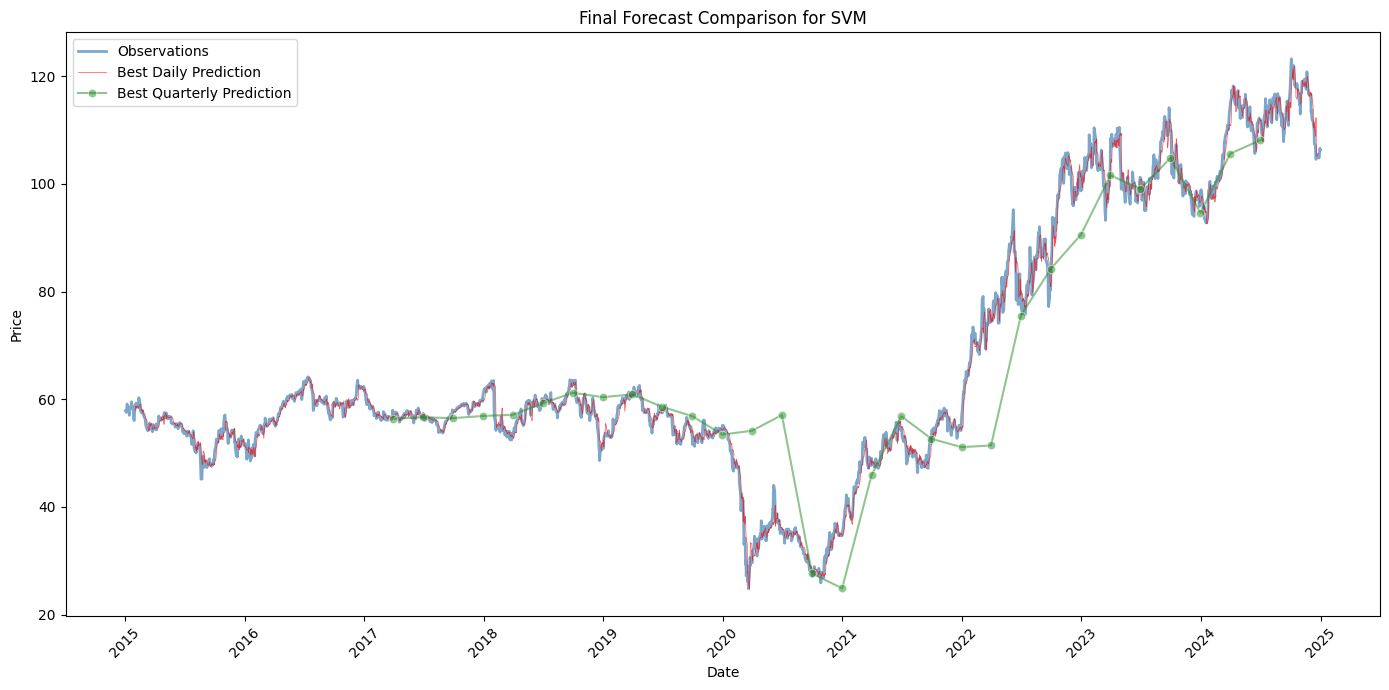

[INFO] Plotting GB forecasts for XOM...


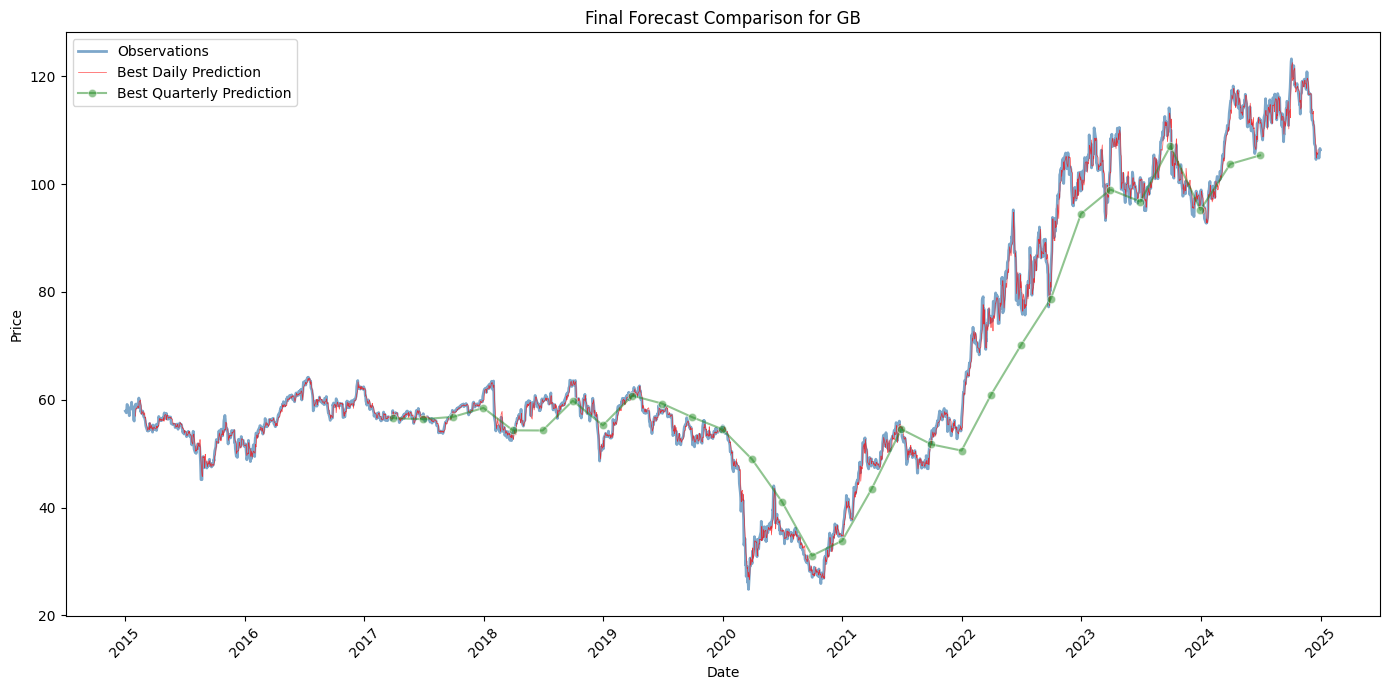

[INFO] Plotting XGB forecasts for XOM...


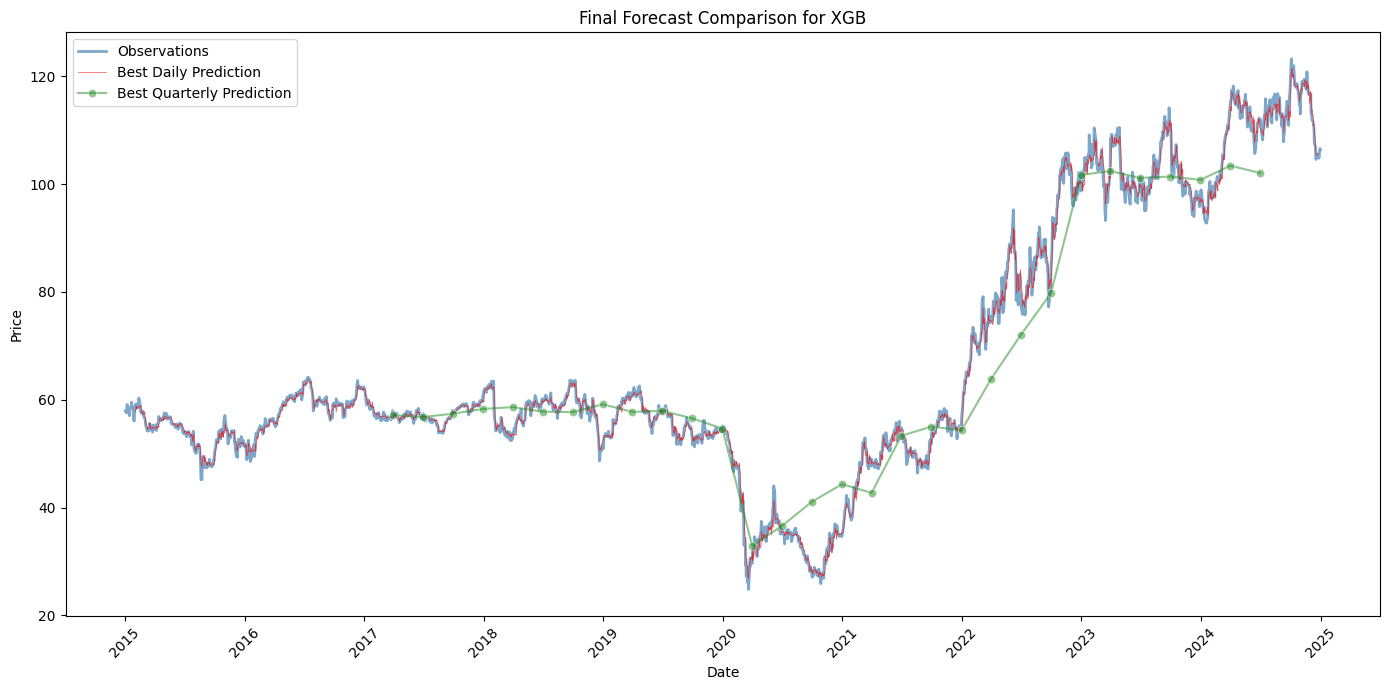

[INFO] Plotting RF forecasts for CVX...


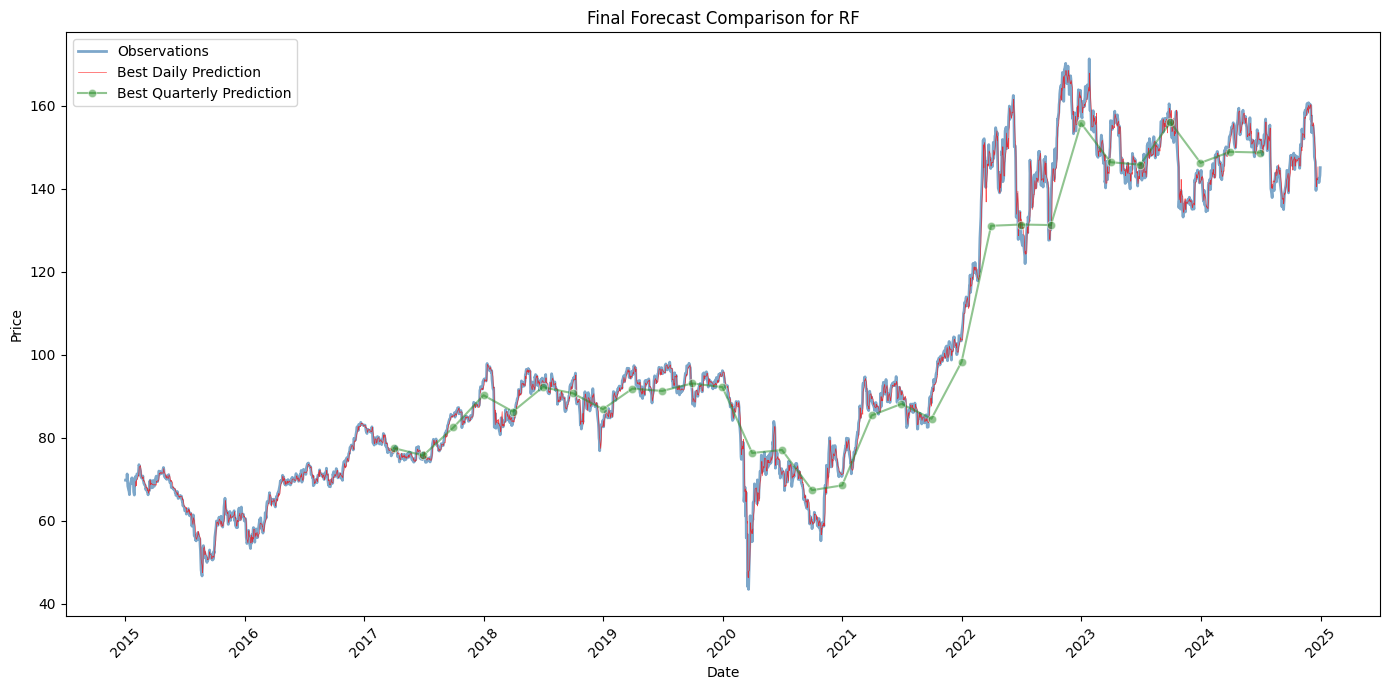

[INFO] Plotting SVM forecasts for CVX...


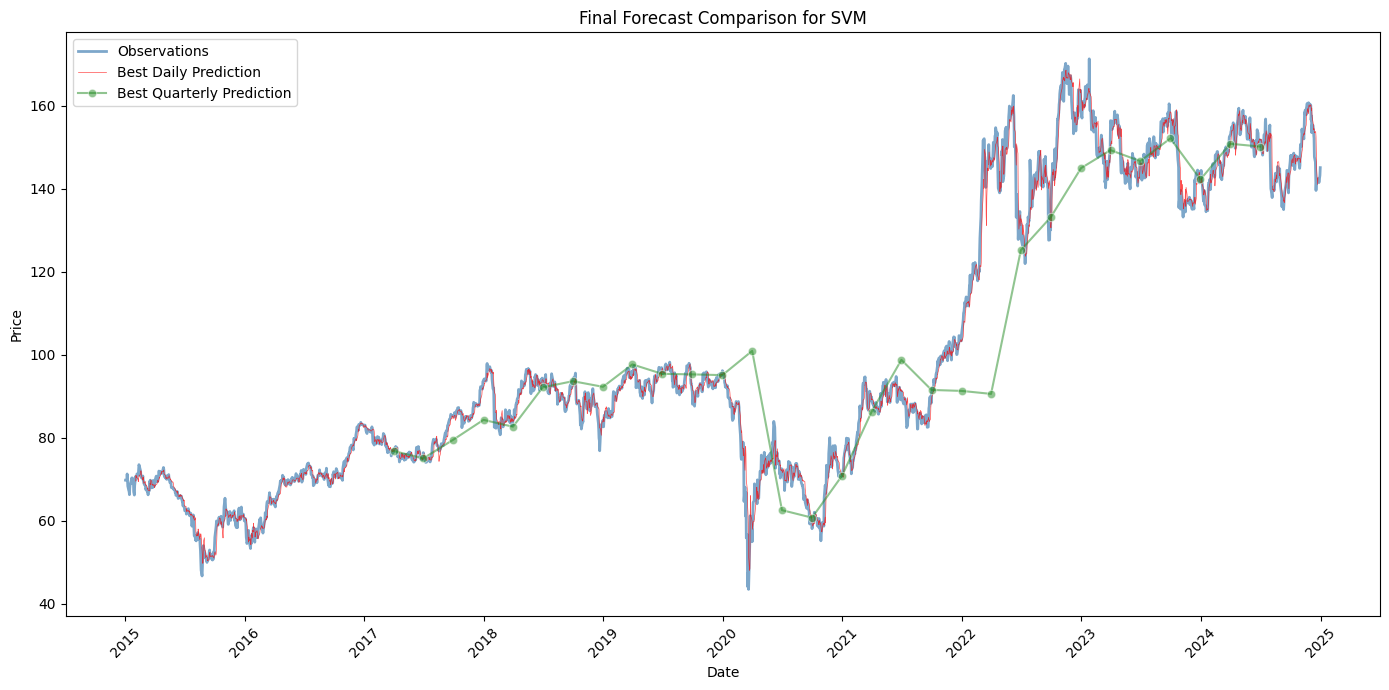

[INFO] Plotting GB forecasts for CVX...


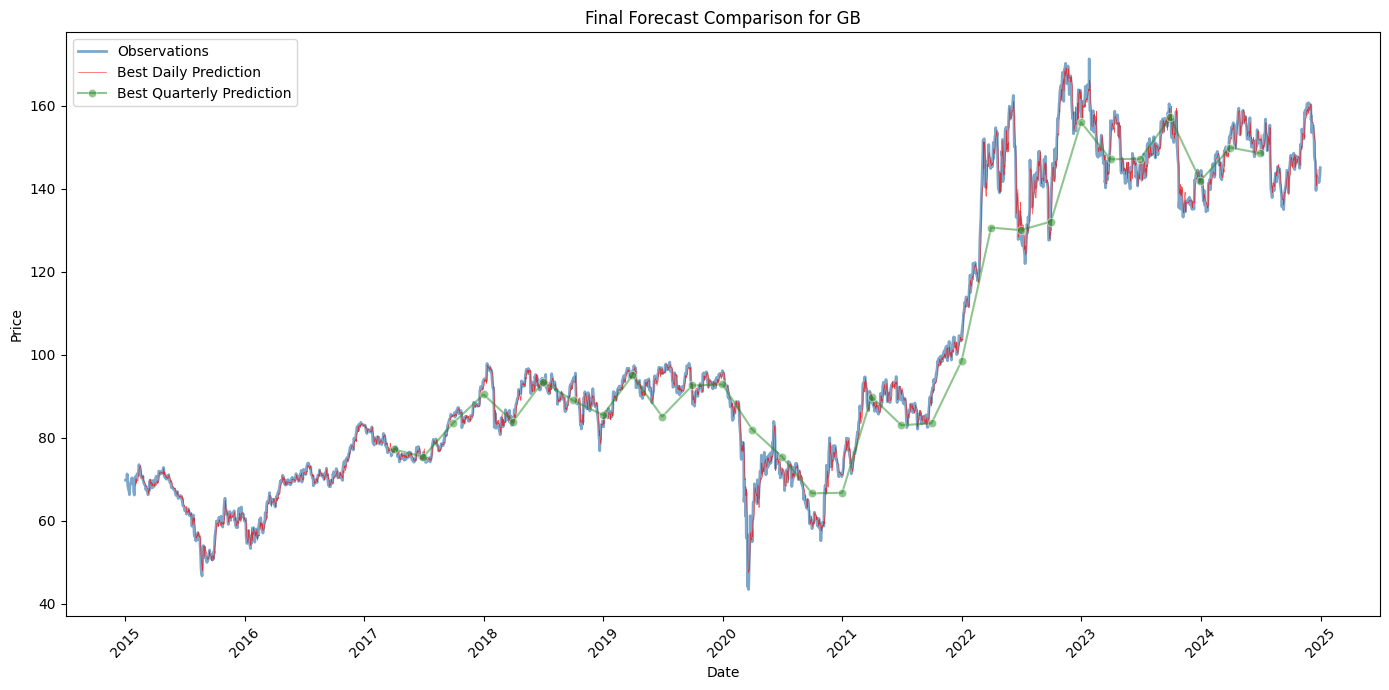

[INFO] Plotting XGB forecasts for CVX...
[ERROR] Log file not found for CVX Daily XGB
[ERROR] Plotting failed for CVX: 'NoneType' object has no attribute 'index'
[INFO] Plotting RF forecasts for LIN...
[ERROR] Log file not found for LIN Daily RF
[ERROR] Plotting failed for LIN: 'NoneType' object has no attribute 'index'
[INFO] Plotting RF forecasts for SHW...
[ERROR] Log file not found for SHW Daily RF
[ERROR] Plotting failed for SHW: 'NoneType' object has no attribute 'index'
[INFO] Plotting RF forecasts for AMT...
[ERROR] Log file not found for AMT Daily RF
[ERROR] Plotting failed for AMT: 'NoneType' object has no attribute 'index'
[INFO] Plotting RF forecasts for PLD...
[ERROR] Log file not found for PLD Daily RF
[ERROR] Plotting failed for PLD: 'NoneType' object has no attribute 'index'
[INFO] Plotting RF forecasts for NEE...
[ERROR] Log file not found for NEE Daily RF
[ERROR] Plotting failed for NEE: 'NoneType' object has no attribute 'index'
[INFO] Plotting RF forecasts for SO...

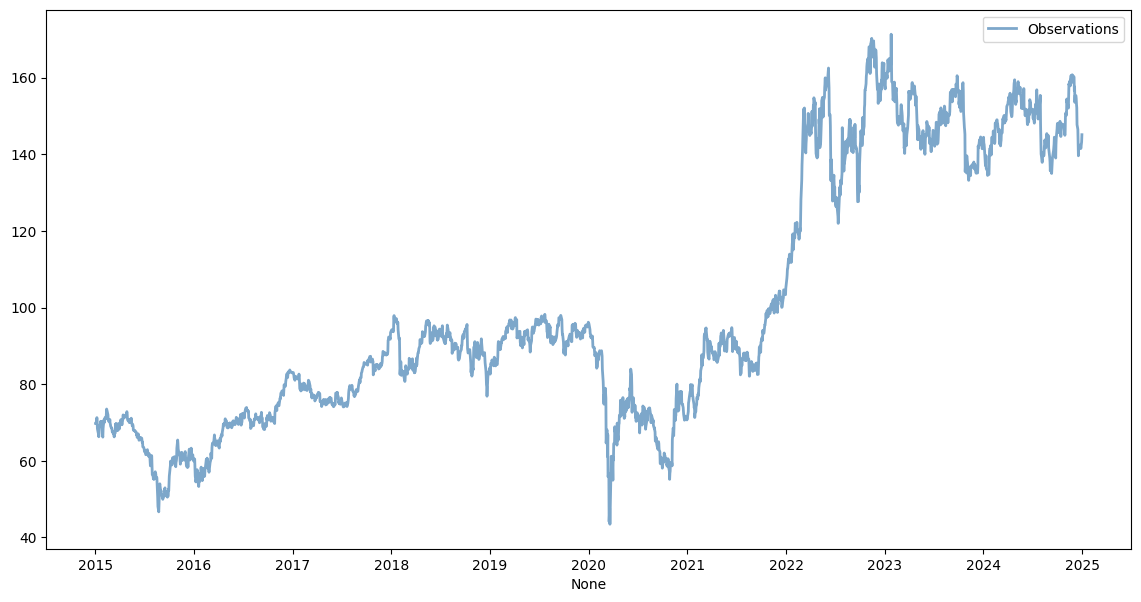

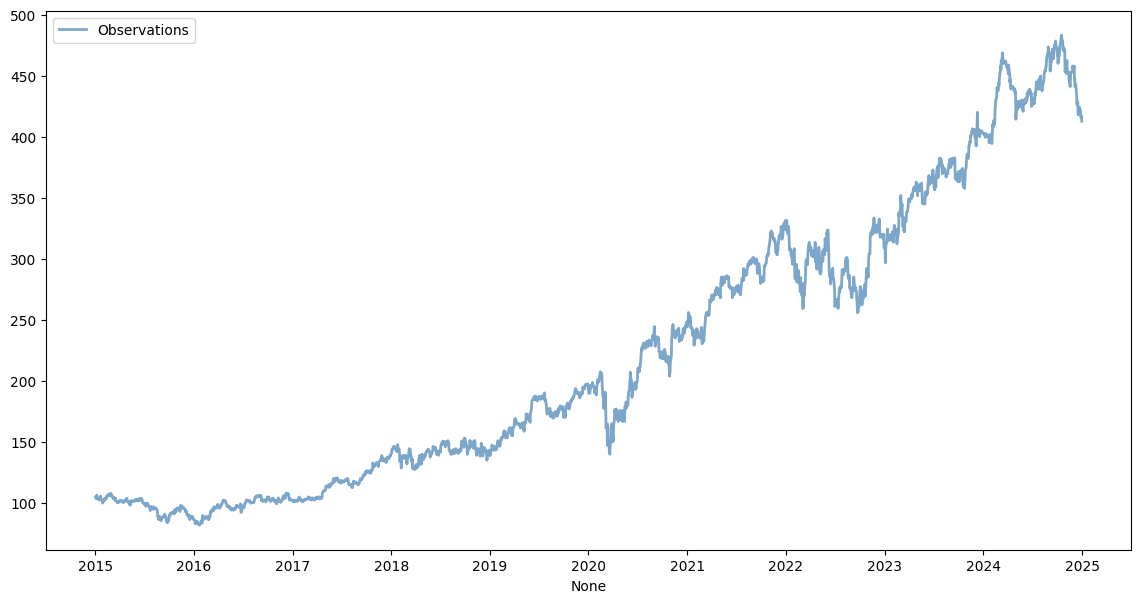

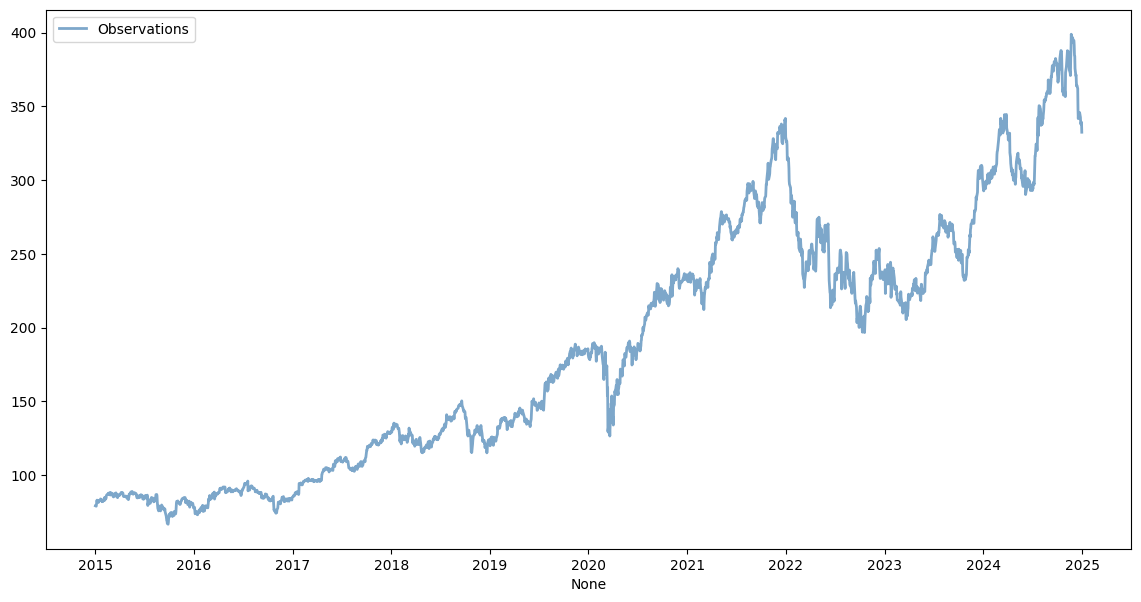

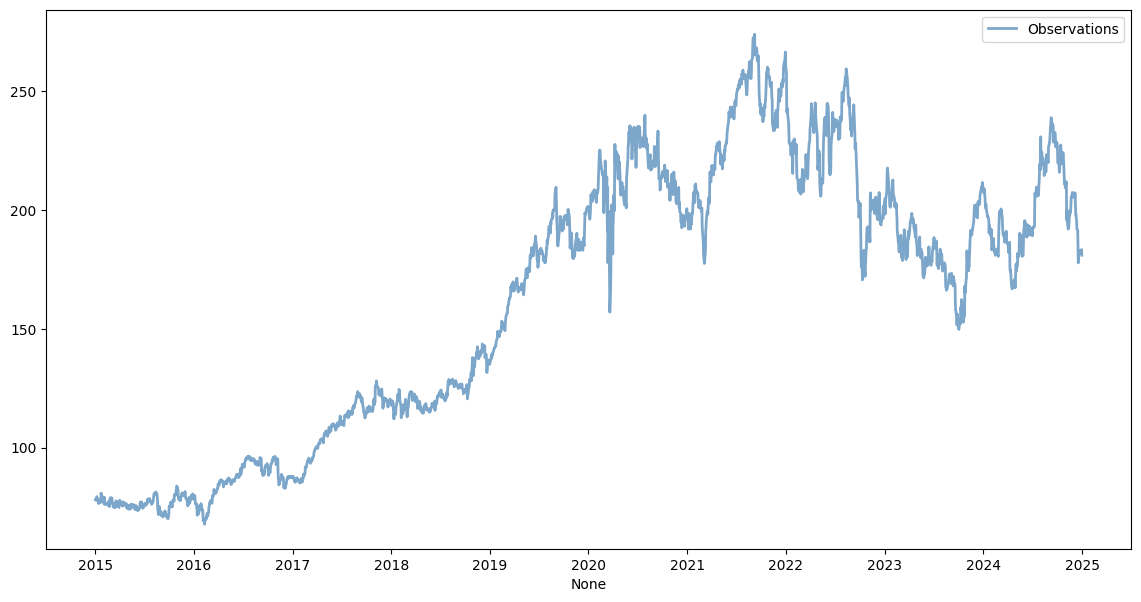

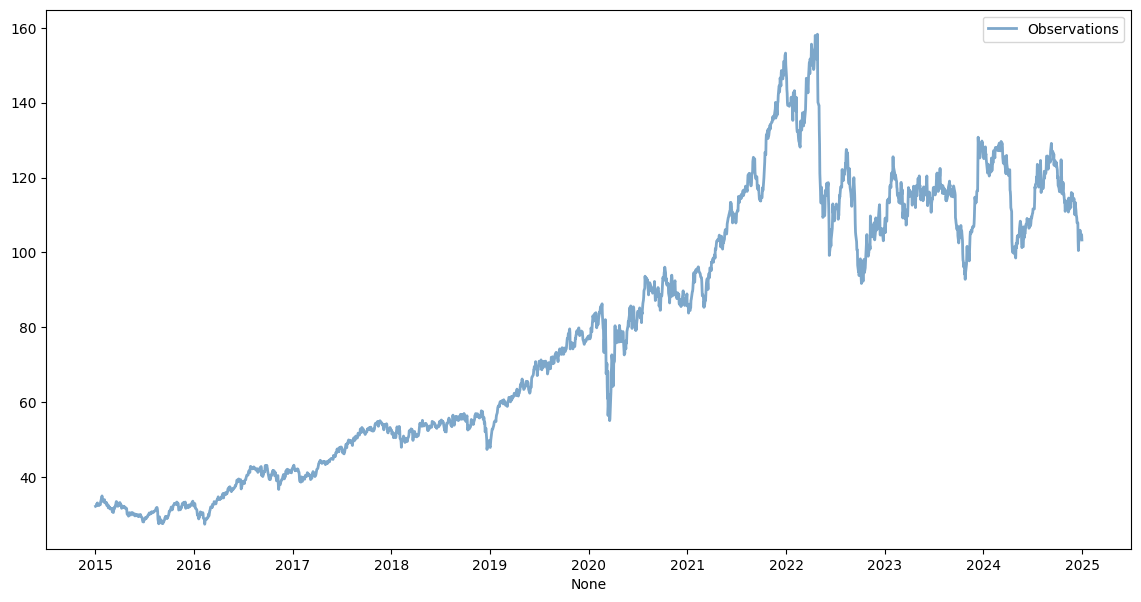

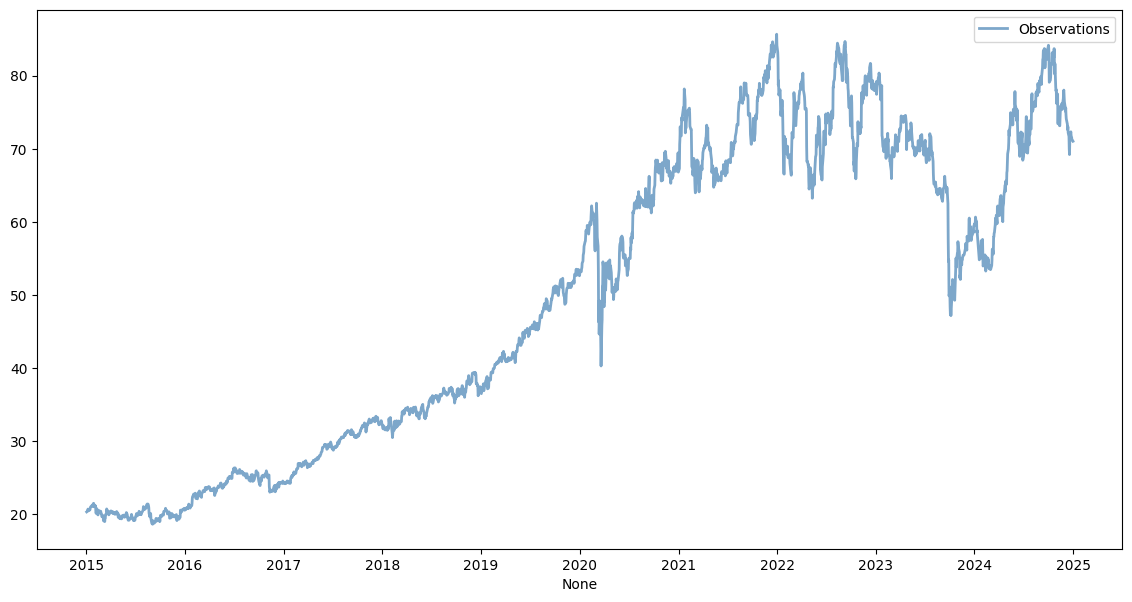

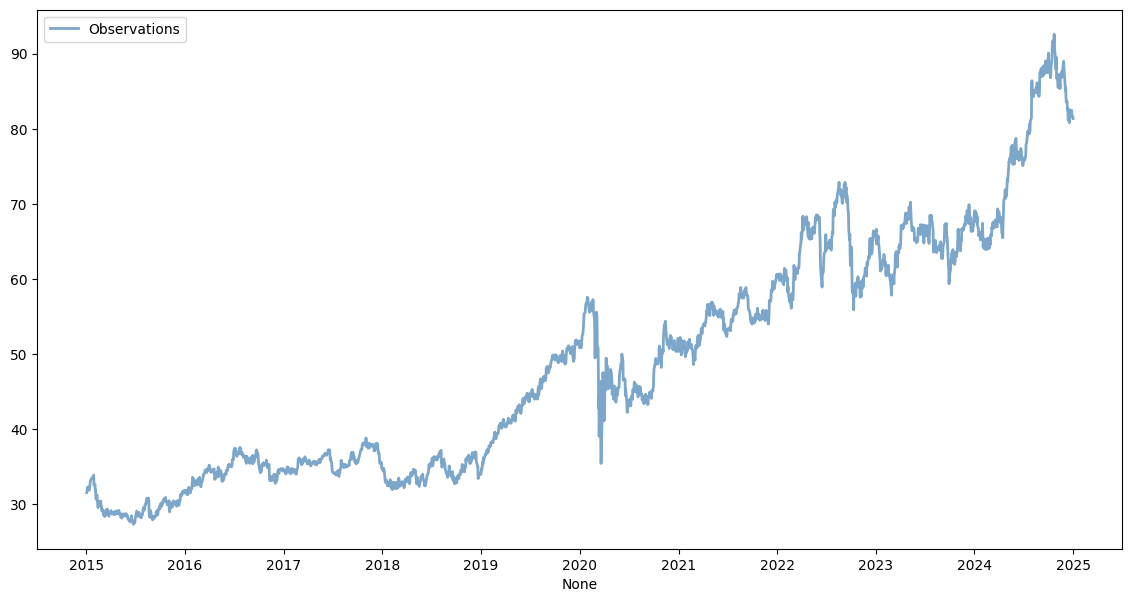

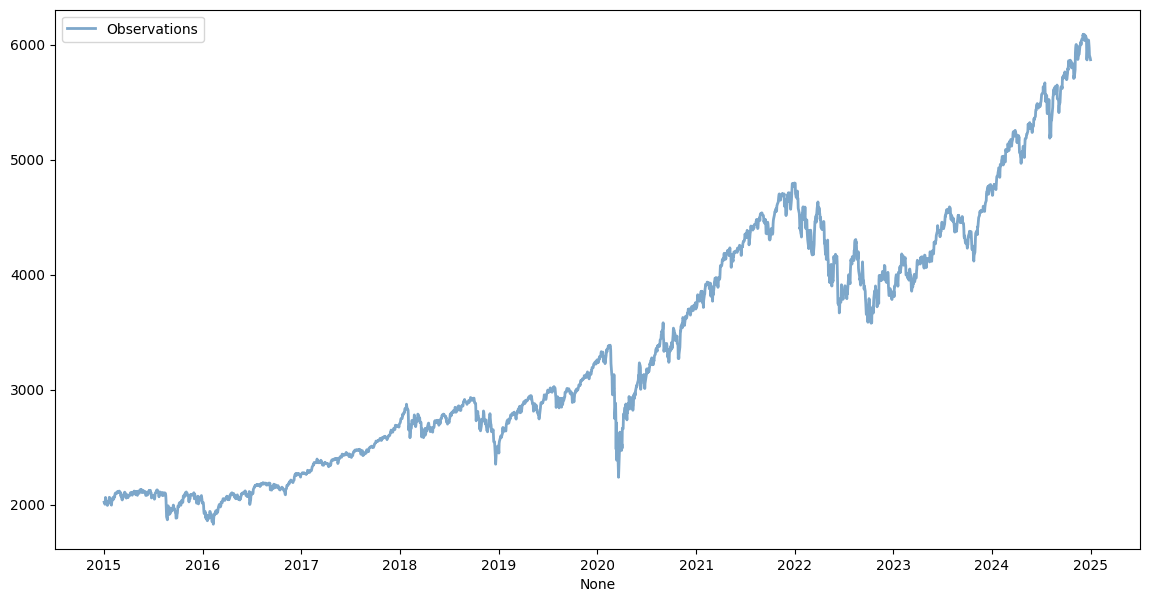

In [16]:
for ticker in daily_data_dict.keys():
    try:
        for m in MODEL_TYPES:
            print(f"[INFO] Plotting {m} forecasts for {ticker}...")

            # Get daily predictions and ensure the index is normalized
            daily_df = daily_data_dict[ticker]
            # If necessary, convert the daily DataFrame index to datetime and normalize
            daily_df.index = pd.to_datetime(daily_df.index).normalize()
            daily_pred_series = get_preds_from_log(ticker, "Daily", m, daily_df)
            
            # Initialize quarterly predictions as None
            quarterly_pred_series = None
            if ticker in quarterly_data_dict:
                # Convert quarterly DataFrame index to datetime and normalize
                quarterly_df = quarterly_data_dict[ticker]
                quarterly_df.index = pd.to_datetime(convert_quarter_index(quarterly_df)).normalize()
                quarterly_pred_series = get_preds_from_log(ticker, "Quarterly", m, quarterly_df)
            
            # Observations from daily data (as our base), and normalize its index
            obs = daily_df["y"]
            obs.index = pd.to_datetime(obs.index).normalize()
            
            # If quarterly predictions are not available, we default to daily predictions for both lines
            if quarterly_pred_series is None:
                quarterly_pred_series = daily_pred_series
            
            # Plot both series on one visual:
            final_line_plot(observations=obs, daily_preds=daily_pred_series, 
                            quarterly_preds=quarterly_pred_series, model_label=m)
    except Exception as e:
        print(f"[ERROR] Plotting failed for {ticker}: {e}")

In [17]:
daily_data_dict['AAPL']

Adj Close       Close        High         Low        Open  \
2015-01-02   24.320433   27.332500   27.860001   26.837500   27.847500   
2015-01-05   23.635281   26.562500   27.162500   26.352501   27.072500   
2015-01-06   23.637518   26.565001   26.857500   26.157499   26.635000   
2015-01-07   23.968964   26.937500   27.049999   26.674999   26.799999   
2015-01-08   24.889904   27.972500   28.037500   27.174999   27.307501   
...                ...         ...         ...         ...         ...   
2024-12-24  257.916443  258.200012  258.209991  255.289993  255.490005   
2024-12-26  258.735504  259.019989  260.100006  257.630005  258.190002   
2024-12-27  255.309296  255.589996  258.700012  253.059998  257.829987   
2024-12-30  251.923019  252.199997  253.500000  250.750000  252.229996   
2024-12-31  250.144974  250.419998  253.279999  249.429993  252.440002   

               Volume        SMA5       SMA50      SMA200  MACDLine  ...  \
2015-01-02  212818400   24.920158   24.811784   21.368268 -0.032423  ...   
2015-01-05  257142000   24.575804   24.828265   21.403677 -0.127245  ...   
2015-01-06  263188400   24.235457   24.836641   21.438444 -0.199907  ...   
2015-01-07  160423600   24.023241   24.849918   21.473879 -0.228118  ...   
2015-01-08  237458000   24.090420   24.882102   21.513011 -0.174156  ...   
...               ...         ...         ...         ...       ...  ...   
2024-12-24   23234700  252.881967  235.564016  211.182570  6.067327  ...   
2024-12-26   27237100  255.073553  236.071997  211.614168  6.300019  ...   
2024-12-27   42355300  256.232281  236.552763  212.039086  6.137217  ...   
2024-12-30   35557500  255.774783  236.958419  212.437766  5.669595  ...   
2024-12-31   39480700  254.805847  237.271641  212.829447  5.096776  ...   

                   ^IXIC          ^DJI       ^VIX       CL=F         GC=F  \
2015-01-02   4726.810059  17832.990234  17.790001  52.689999  1186.000000   
2015-01-05   4652.569824  17501.650391  19.920000  50.040001  1203.900024   
2015-01-06   4592.740234  17371.640625  21.120001  47.930000  1219.300049   
2015-01-07   4650.470215  17584.519531  19.309999  48.650002  1210.599976   
2015-01-08   4736.189941  17907.869141  17.010000  48.790001  1208.400024   
...                  ...           ...        ...        ...          ...   
2024-12-24  20031.130859  43297.031250  14.270000  70.099998  2620.000000   
2024-12-26  20020.359375  43325.800781  14.730000  69.620003  2638.800049   
2024-12-27  19722.029297  42992.210938  15.950000  70.599998  2617.199951   
2024-12-30  19486.789062  42573.730469  17.400000  70.989998  2606.100098   
2024-12-31  19310.789062  42544.218750  17.350000  71.720001  2629.199951   

                 SI=F   ^TNX    DX-Y.NYB  FedFundsRate           y  
2015-01-02  15.734000  2.123   91.080002          0.12   23.635281  
2015-01-05  16.179001  2.039   91.379997          0.12   23.637518  
2015-01-06  16.603001  1.963   91.500000          0.12   23.968964  
2015-01-07  16.510000  1.954   91.889999          0.12   24.889904  
2015-01-08  16.351000  2.016   92.370003          0.12   24.916597  
...               ...    ...         ...           ...         ...  
2024-12-24  29.974001  4.591  108.260002          4.33  258.735504  
2024-12-26  30.047001  4.579  108.129997          4.33  255.309296  
2024-12-27  29.655001  4.619  108.000000          4.33  251.923019  
2024-12-30  29.106001  4.545  108.129997          4.33  250.144974  
2024-12-31  28.940001  4.573  108.489998          4.33  243.582199  

[2516 rows x 39 columns]

In [18]:
# Build summary DataFrames
daily_summary_df = pd.DataFrame.from_dict(daily_results, orient="index")
quarterly_summary_df = pd.DataFrame.from_dict(quarterly_results, orient="index")
daily_summary_df.loc["Total Average"] = daily_summary_df.mean(numeric_only=True)
quarterly_summary_df.loc["Total Average"] = quarterly_summary_df.mean(numeric_only=True)

print("\n[SUCCESS] Daily Performance Summary:")
display(daily_summary_df)
print("\n[SUCCESS] Quarterly Performance Summary:")
display(quarterly_summary_df)
print("\nOverall model performance summary printed above.")

# Optionally, save the summary tables to CSV files
daily_summary_df.to_csv(os.path.join("temp_output", "daily_performance_summary.csv"))
quarterly_summary_df.to_csv(os.path.join("temp_output", "quarterly_performance_summary.csv"))
print("[SUCCESS] Performance summaries saved to temp_output/")


[SUCCESS] Daily Performance Summary:


Ticker     RF_MSE   RF_MAPE     RF_R2     SVM_MSE  SVM_MAPE  \
AAPL            AAPL   4.723181  0.014485  0.998897    7.653408  0.018533   
MSFT            MSFT  14.831899  0.013121  0.999023   21.942842  0.016105   
LLY              LLY  48.482458  0.013697  0.999090   87.694109  0.017973   
UNH              UNH  37.163466  0.012556  0.998420   62.406399  0.015929   
V                  V   8.395282  0.011659  0.998231   12.466444  0.014277   
MA                MA  26.286859  0.012789  0.998368   42.013465  0.015741   
GOOGL          GOOGL   3.708655  0.014309  0.998021    5.833388  0.018014   
META            META  41.774229  0.017807  0.997124   70.835161  0.023240   
AMZN            AMZN   7.079620  0.016365  0.997543   12.112332  0.021304   
TSLA            TSLA  49.591288  0.029281  0.996176  103.104720  0.040765   
PG                PG   2.056199  0.008902  0.998374    3.287909  0.011325   
WMT              WMT   0.351124  0.010145  0.998558    0.667722  0.013110   
RTX              RTX   1.672647  0.012307  0.994673    3.212294  0.016446   
UNP              UNP   7.697008  0.012697  0.997659   13.178416  0.016304   
XOM              XOM   1.574847  0.013672  0.997172    2.648130  0.017510   
Total Average    NaN  17.025917  0.014253  0.997822   29.937116  0.018438   

                 SVM_R2     GB_MSE   GB_MAPE     GB_R2    XGB_MSE  XGB_MAPE  \
AAPL           0.998212   5.168083  0.015138  0.998793   4.935725  0.014457   
MSFT           0.998554  16.278237  0.013767  0.998928  15.302281  0.013377   
LLY            0.998354  53.279698  0.014474  0.999000  59.952682  0.013904   
UNH            0.997346  41.468404  0.013260  0.998236  38.831265  0.012729   
V              0.997373   8.870941  0.012096  0.998131   8.818247  0.011697   
MA             0.997392  28.356513  0.013326  0.998240  26.719020  0.012657   
GOOGL          0.996888   4.089158  0.014992  0.997818   3.918194  0.014305   
META           0.995123  45.446472  0.018714  0.996871  56.470857  0.018802   
AMZN           0.995797   7.733038  0.017056  0.997317   7.701012  0.016822   
TSLA           0.992051  54.618447  0.030706  0.995789  48.805370  0.028790   
PG             0.997399   2.177725  0.009286  0.998278   2.089229  0.008886   
WMT            0.997258   0.395141  0.010773  0.998377   0.361433  0.010110   
RTX            0.989769   1.832700  0.012975  0.994163   1.758779  0.012451   
UNP            0.995992   8.397161  0.013270  0.997446   8.302542  0.012946   
XOM            0.995245   1.754701  0.014480  0.996849   1.620271  0.013702   
Total Average  0.996184  18.657761  0.014954  0.997616  19.039127  0.014376   

                 XGB_R2  
AAPL           0.998847  
MSFT           0.998992  
LLY            0.998875  
UNH            0.998349  
V              0.998142  
MA             0.998341  
GOOGL          0.997910  
META           0.996112  
AMZN           0.997328  
TSLA           0.996237  
PG             0.998348  
WMT            0.998516  
RTX            0.994399  
UNP            0.997475  
XOM            0.997090  
Total Average  0.997664


[SUCCESS] Quarterly Performance Summary:


Ticker       RF_MSE   RF_MAPE     RF_R2      SVM_MSE  SVM_MAPE  \
AAPL            AAPL   445.581028  0.147022  0.877762   460.389729  0.142228   
MSFT            MSFT  1150.512695  0.129124  0.907980  1599.032768  0.137915   
LLY              LLY  5125.808683  0.124700  0.907737  6949.790477  0.142341   
UNH              UNH  1419.928170  0.089612  0.916476  1338.991308  0.090860   
V                  V   379.235964  0.096939  0.854193   284.992776  0.084862   
MA                MA  1412.688317  0.117700  0.853984  1362.674878  0.115775   
GOOGL          GOOGL   199.156765  0.118563  0.871126   368.170491  0.138979   
META            META  3495.077013  0.193864  0.726703  6024.914500  0.260078   
AMZN            AMZN   445.389128  0.144039  0.751751   572.710171  0.148475   
TSLA            TSLA  3201.472579  0.260785  0.752812  3589.458661  0.285035   
PG                PG   147.425497  0.080866  0.845823   217.421789  0.093521   
WMT              WMT    30.033325  0.093496  0.819353    36.272198  0.095591   
RTX              RTX   152.106189  0.133514  0.366374   129.408112  0.122170   
UNP              UNP   595.266398  0.113877  0.710553   559.132188  0.105983   
XOM              XOM   108.504357  0.138853  0.839077   165.545311  0.180367   
CVX              CVX   213.753883  0.098747  0.787497   305.937273  0.116795   
LIN              LIN  1090.165661  0.105529  0.901414   876.339933  0.099886   
SHW              SHW  1585.318158  0.145542  0.711423  1469.709491  0.134163   
AMT              AMT   487.669671  0.093929  0.730932   607.218230  0.110570   
PLD              PLD   219.900551  0.117085  0.755055   246.463124  0.116680   
NEE              NEE    51.970178  0.095830  0.815486    66.101347  0.107926   
SO                SO    25.269602  0.069765  0.874507    41.007742  0.091667   
Total Average    NaN   999.192446  0.123154  0.799001  1239.621932  0.132812   

                 SVM_R2       GB_MSE   GB_MAPE     GB_R2      XGB_MSE  \
AAPL           0.873699   426.991153  0.147920  0.882862   314.919562   
MSFT           0.872106  1254.471962  0.129615  0.899665   865.110867   
LLY            0.874906  5332.190559  0.127389  0.904022  3307.272578   
UNH            0.921237  1470.724364  0.092318  0.913488  1103.607430   
V              0.890427   398.390258  0.099069  0.846828   234.347808   
MA             0.859153  1291.039086  0.111894  0.866558   882.645697   
GOOGL          0.761757   208.279688  0.116001  0.865222   112.073506   
META           0.528882  3195.835807  0.185154  0.750102  2273.780538   
AMZN           0.680785   471.732868  0.149007  0.737068   331.567223   
TSLA           0.722855  3330.004227  0.272690  0.742888  2069.399355   
PG             0.772621   149.800623  0.082515  0.843339   154.134519   
WMT            0.781827    32.148328  0.093172  0.806632    18.747935   
RTX            0.460927   185.590389  0.140189  0.226889   113.247249   
UNP            0.728123   498.489791  0.107722  0.757610   577.391696   
XOM            0.754480   132.347427  0.158346  0.803715    90.681372   
CVX            0.695852   222.325603  0.104786  0.778975   193.254265   
LIN            0.920751  1232.683179  0.110816  0.888526   934.685374   
SHW            0.732468  1723.211448  0.150411  0.686323  1225.568269   
AMT            0.664972   489.231355  0.094568  0.730071   308.877719   
PLD            0.725467   322.280669  0.137385  0.641015   131.957707   
NEE            0.765315    50.158993  0.096649  0.821916    34.279358   
SO             0.796349    27.171049  0.072796  0.865064    18.065882   
Total Average  0.762953  1020.231765  0.126382  0.784490   695.255269   

               XGB_MAPE    XGB_R2  
AAPL           0.111938  0.913607  
MSFT           0.092612  0.930807  
LLY            0.107239  0.940470  
UNH            0.069606  0.935083  
V              0.073019  0.909899  
MA             0.091216  0.908769  
GOOGL          0.081091  0.927477  
META           0.160802  0.822202  
AMZN           0


Overall model performance summary printed above.
[SUCCESS] Performance summaries saved to temp_output/
